In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from skimage.measure import regionprops, label

import os
cwd = os.getcwd()

path = Path(cwd + '/data/')
path.ls()

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImages.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImagesToDuplicate.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/AdditionalNotTrustedImagesRemoved.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/NoBoneImages.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/codes.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/NotTrusted'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/valid.txt')]

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.51
fastprogress  : 0.1.20
torch         : 1.0.1
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7301 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1041-azure-x86_64-with-debian-stretch-sid
distro        : #45-Ubuntu SMP Fri Mar 15 14:41:00 UTC 2019
conda env     : py35
python        : /data/anaconda/envs/py35/bin/python
sys.path      : /opt/caffe/python
/opt/caffe2/build
/data/home/thor/notebooks/sensorx-contaminant-detection
/data/anaconda/envs/py35/lib/python36.zip
/data/anaconda/envs/py35/lib/python3.6
/data/anaconda/envs/py35/lib/python3.6/lib-dynload

/data/anaconda/envs/py35/lib/python3.6/site-packages
/data/anaconda/envs/py35/lib/python3.6/site-packages/IPython/extensions
/data/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into foru

In [3]:
path_lbl = path/'masks'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_48_-1CL_0.0481968kg.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_48_-1CL_0.0481968kg.tif')]

In [6]:
# Select 10% validation images and handpicked meatl images
metal = ['MAGNA_3_86.3626CL_3.97524kg.tif',
'MAGNA_20_78.9422CL_0.960883kg.tif', 
'MAGNA_48_-1CL_0.437527kg.tif', 
'MAGNA_49_-1CL_0.440395kg.tif', 
'MAGNA_50_-1CL_0.317512kg.tif', 
'MAGNA_51_-1CL_0.453667kg.tif', 
'MAGNA_52_-1CL_0.360127kg.tif', 
'MAGNA_53_-1CL_0.446551kg.tif', 
'MAGNA_54_-1CL_0.441927kg.tif', 
'MAGNA_55_-1CL_0.454831kg.tif', 
'MAGNA_56_-1CL_0.446517kg.tif', 
'MAGNA_57_-1CL_0.442111kg.tif', 
'MAGNA_58_-1CL_0.453068kg.tif', 
'MAGNA_59_-1CL_0.328768kg.tif', 
'MAGNA_60_-1CL_0.439103kg.tif', 
'MAGNA_61_83.7706CL_3.88116kg.tif']

no_metal_names = np.array([img.name for img in fnames])
for metal_img in metal:
    no_metal_names = no_metal_names[no_metal_names != metal_img]

validation_count = len(no_metal_names) // 10 # 10% of the non-metal images
validation_files = np.random.choice(no_metal_names, size=validation_count, replace=False)
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
                             'MAGNA_54_-1CL_0.441927kg.tif']
validation_files = np.append(validation_files, validation_metal)

outF = open("data/valid.txt", "w")
output = map(lambda x: x + '\n', validation_files)
outF.writelines(output)
outF.close()

def numb_contaminants(data):
    data = data.cpu().numpy().astype(int)
            
#     pixel_count = len(data[data == 2]) + len(data[data == 3])
#     if pixel_count > 400:
#         print(name)
#         print("Has {} contaminant pixels".format(pixel_count))
        
    data[data == 1] = 0  # Set meat as background

    labels = label(data, background=0) # same image_binary as above
    regions = regionprops(labels)
    contaminant_count = len(regions)
    return float(contaminant_count)

def numb_incorrect_contaminants(input, target):
    '''Computes the average number of incorrect number of contaminants in labeled image'''
    
    target = target.squeeze(1)
    input = input.argmax(dim=1)
    
    count_incorrect = np.abs(numb_contaminants(input) - numb_contaminants(target))
    
    ret = torch.Tensor(1)
    ret[0] = count_incorrect
    return ret

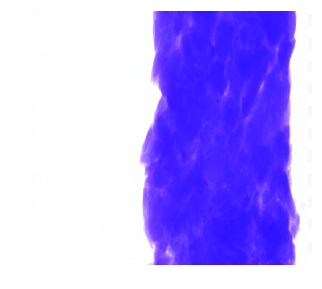

In [7]:
## Data

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [8]:
img_f.parent.parent

PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data')

[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


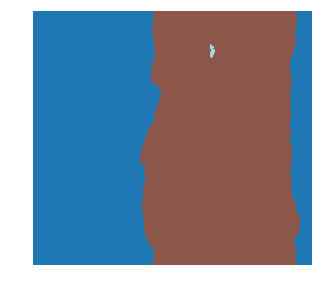

In [9]:
def get_y_fn(x):
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [10]:
## Datasets
bs,size = 8,src_size//2
transforms = ([RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)],
              [RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=1.0, resolved={}, do_run=True, is_random=True)])

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(transforms, size=size, tfm_y=True) # tfm_y=True to apply the same transform to the mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [11]:
print(data.train_ds)
print()
print(data.test_ds)
print()
print(data.valid_ds)

LabelList (3453 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images

None

LabelList (385 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images


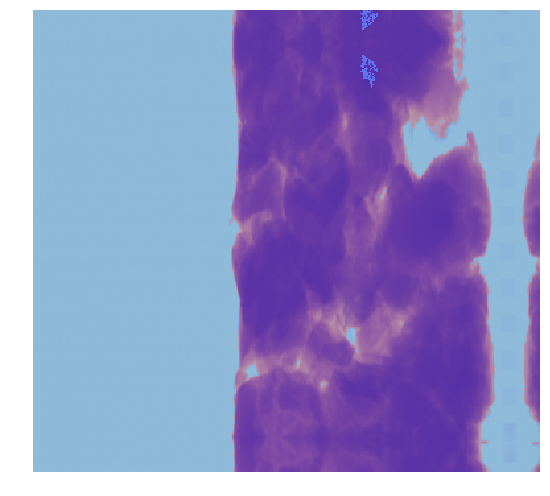

In [12]:
data.show_batch(1, figsize=(10,7))

In [13]:
# weights = torch.FloatTensor([0., 1., 10., 100.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
# def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
#     y_hat = y_hat.argmax(dim=1)
#     y = y.squeeze(1)
    
#     costs = weights[y] * torch.log(y_hat.float() + 1e-16) # epsilon=1e-45
#     cost = costs.sum().double()
#     return cost

weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
def customLossFunction(input, target): # Works
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
# Works
class CustomLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [15]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    return dice(input, targs, iou=True)

In [16]:
wd=1e-2

In [17]:
# The image is reduced by half (data.batch_stats), and has 3 chanels by default (the other two are set to 1)
def pretrained_model(pretrained=True):
    return models.resnet34(pretrained)

learn = unet_learner(data, pretrained_model, wd=wd)#, loss_func=nn.CrossEntropyLoss(weight))#, loss_func=CustomLoss()) #customLossFunction

learn.crit = FocalLoss(5.0)
learn.metrics=[dice, IoU, numb_incorrect_contaminants]

In [18]:
x, y = data.one_batch(DatasetType.Train, True, True)
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (3453 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images;

Valid: LabelList (385 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images;

Test: None>

In [19]:
learn.loss_func, data.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [20]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


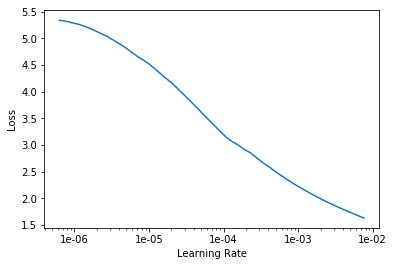

In [21]:
learn.recorder.plot()

In [22]:
lr=1e-4

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [24]:
learn.save('stage-1-big')

In [25]:
learn.load('stage-1-big');

In [26]:
learn.unfreeze()

In [27]:
lrs = slice(1e-6,lr/10)

In [28]:
learn.fit_one_cycle(10, lrs)

In [29]:
learn.save('stage-2-big')

In [30]:
learn.load('stage-2-big');

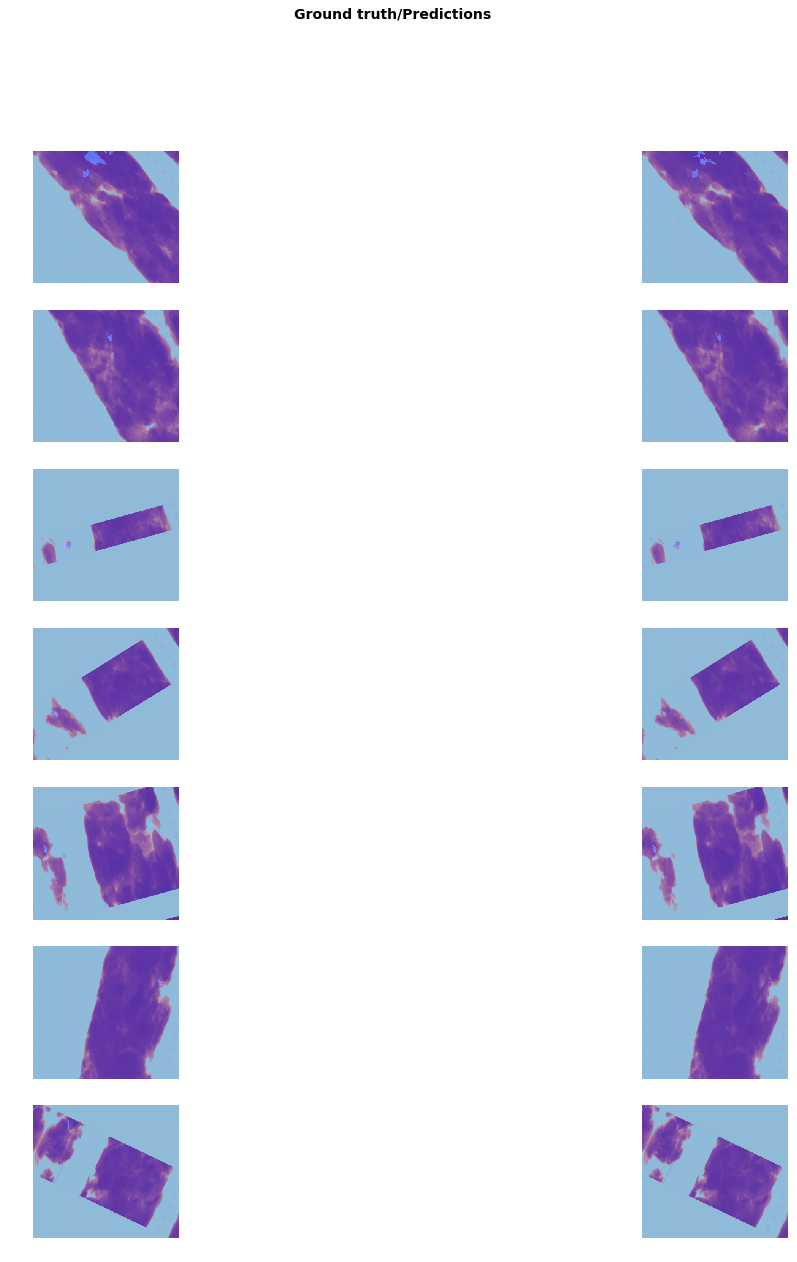

In [31]:
learn.show_results(rows=learn.data.batch_size-1, figsize=(20,20)) # This shows incorrect predictions?

In [32]:
preds,y = learn.get_preds()

In [33]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1978, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 1450, Metal: 0, Groups total: 4.0


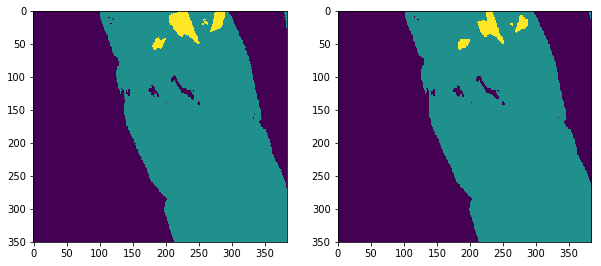

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 125, Metal: 0, Groups total: 1.0


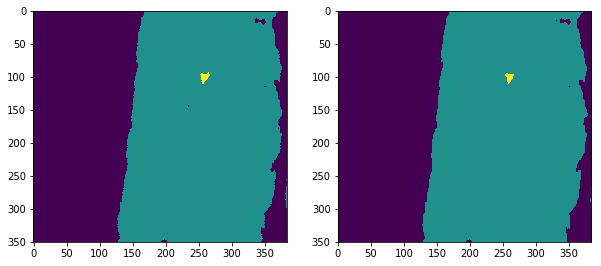

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 219, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 212, Metal: 0, Groups total: 2.0


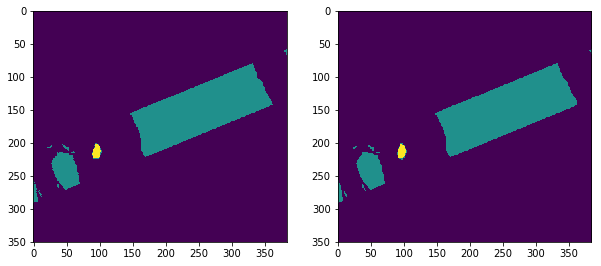

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 130, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 95, Metal: 0, Groups total: 1.0


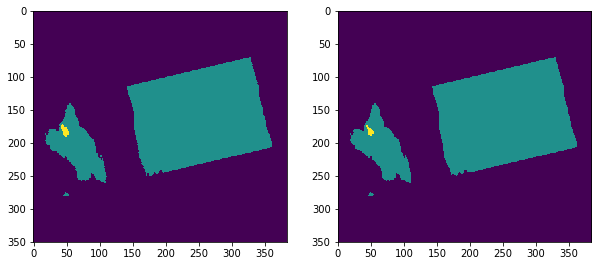

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 287, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 239, Metal: 0, Groups total: 3.0


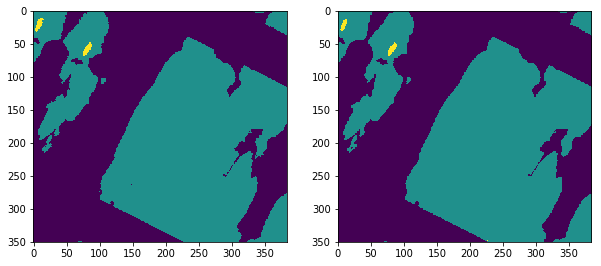

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 62, Metal: 0, Groups total: 1.0


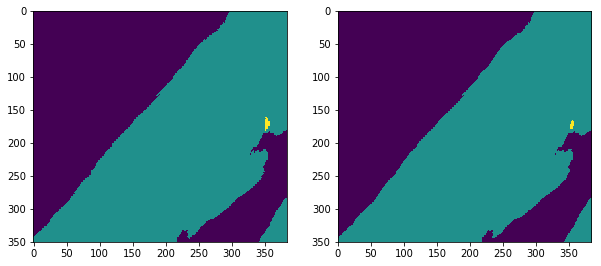

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 66, Metal: 0, Groups total: 2.0


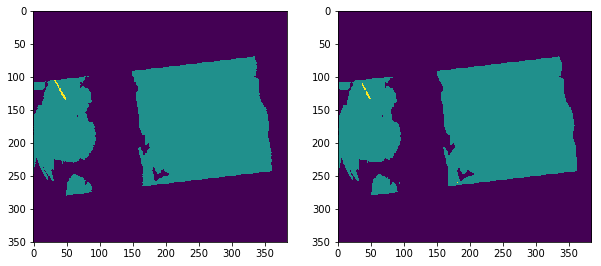

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 251, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 44, Metal: 0, Groups total: 3.0


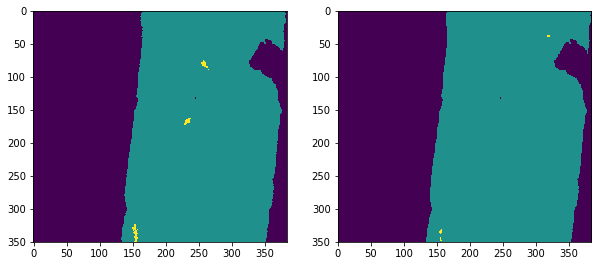

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 19, Metal: 0, Groups total: 1.0


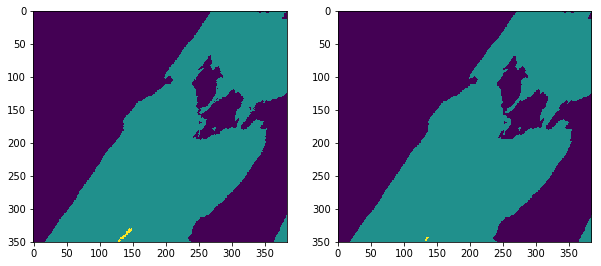

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 219, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 151, Metal: 0, Groups total: 1.0


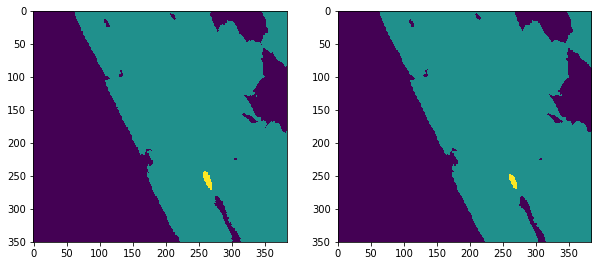

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 468, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 371, Metal: 0, Groups total: 4.0


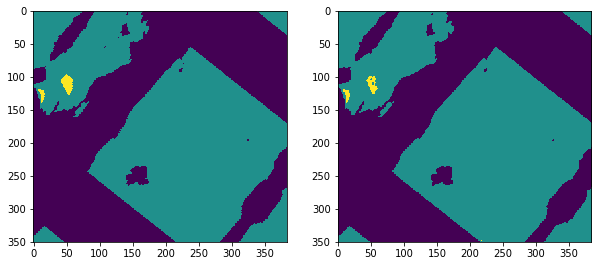

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 237, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 191, Metal: 0, Groups total: 1.0


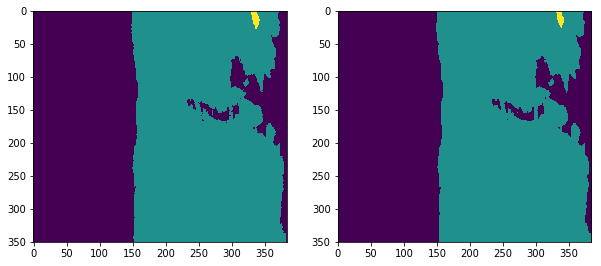

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 313, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 259, Metal: 0, Groups total: 1.0


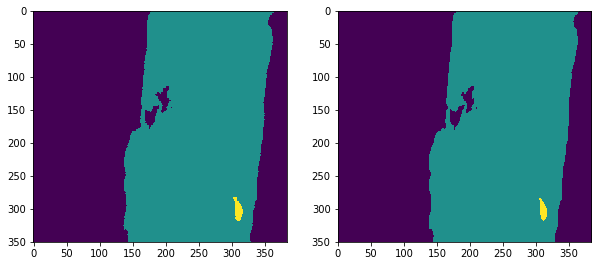

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 50, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 42, Metal: 0, Groups total: 1.0


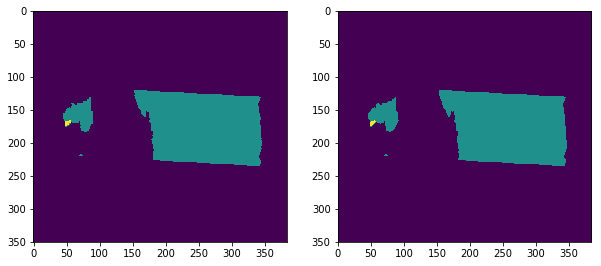

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 498, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 495, Metal: 0, Groups total: 1.0


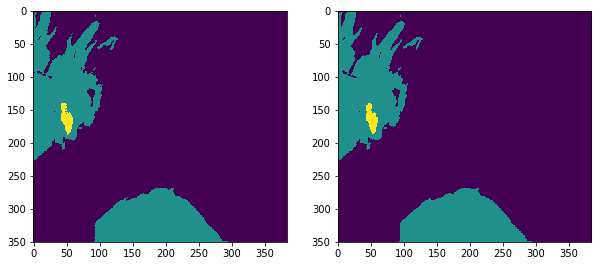

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 93, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 101, Metal: 0, Groups total: 2.0


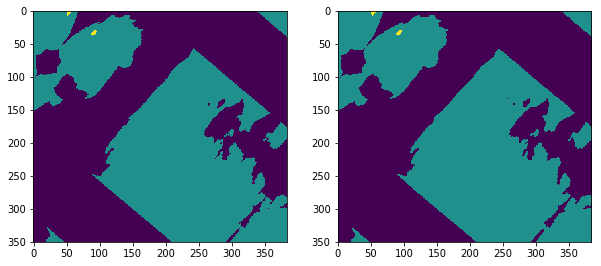

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 153, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 153, Metal: 0, Groups total: 1.0


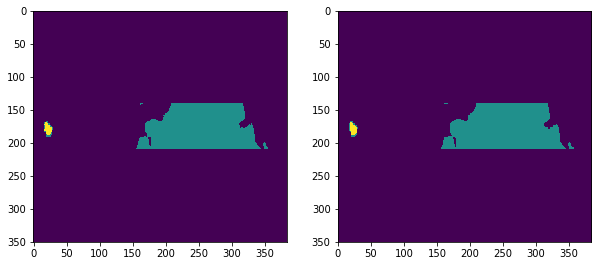

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 258, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 248, Metal: 0, Groups total: 2.0


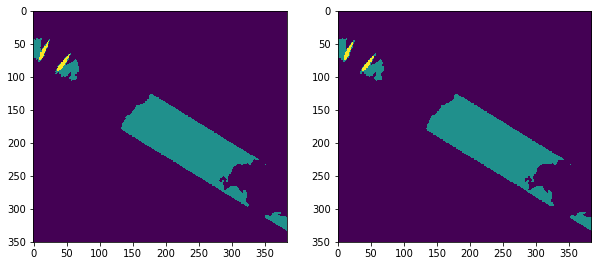

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 46, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 17, Metal: 0, Groups total: 2.0


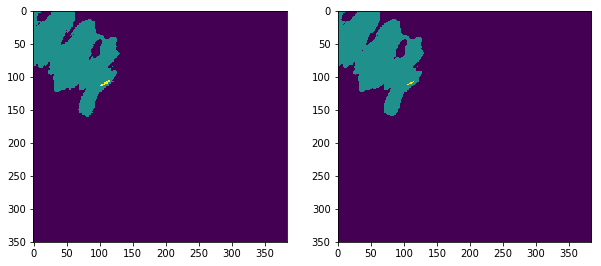

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 3.0


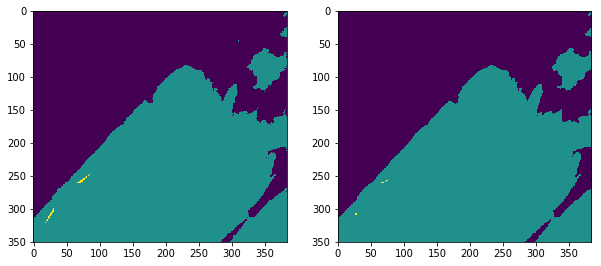

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 350, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 94, Metal: 0, Groups total: 5.0


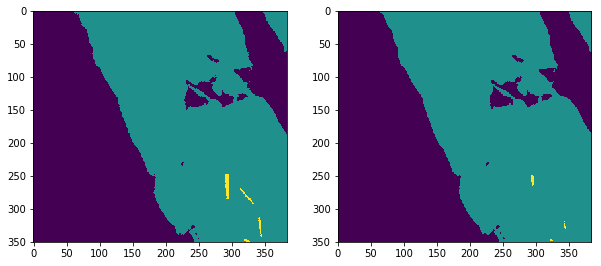

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 183, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


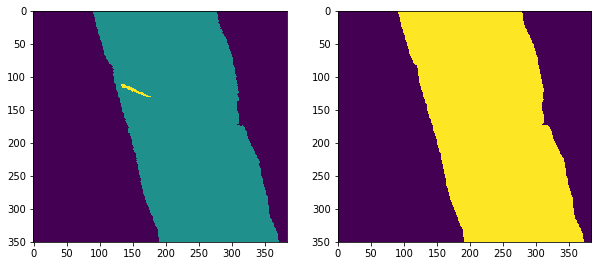

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 112, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 19, Metal: 0, Groups total: 1.0


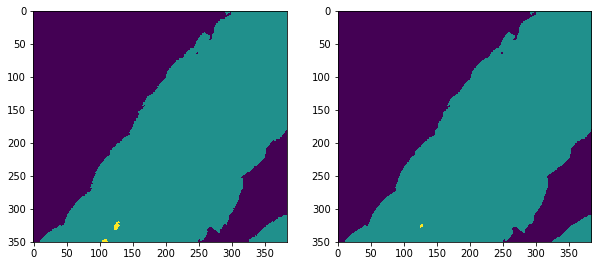

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 185, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 222, Metal: 0, Groups total: 1.0


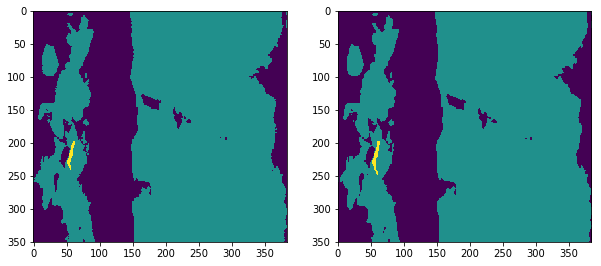

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 38, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 13, Metal: 0, Groups total: 1.0


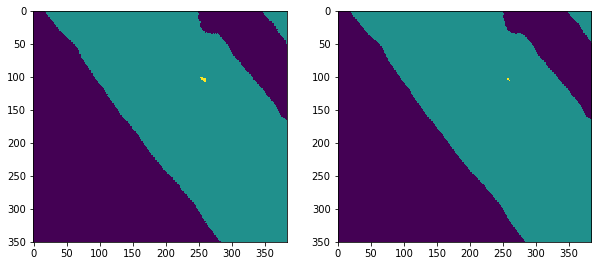

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 110, Metal: 0, Groups total: 1.0


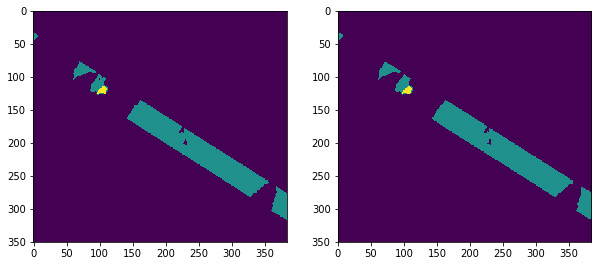

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 493, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 533, Metal: 0, Groups total: 2.0


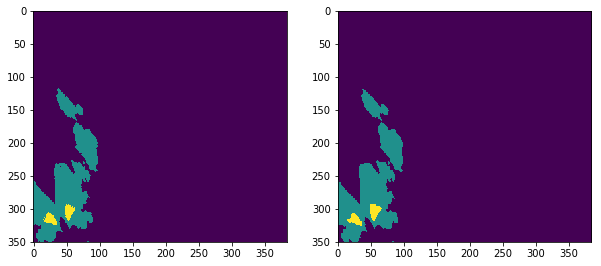

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 1.0


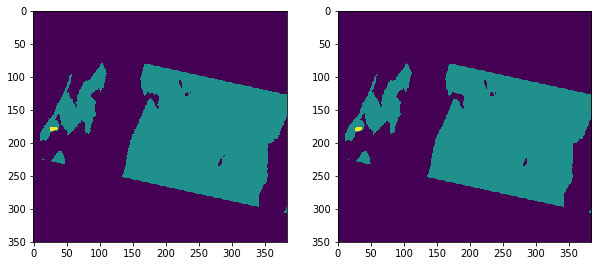

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 163, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 213, Metal: 0, Groups total: 2.0


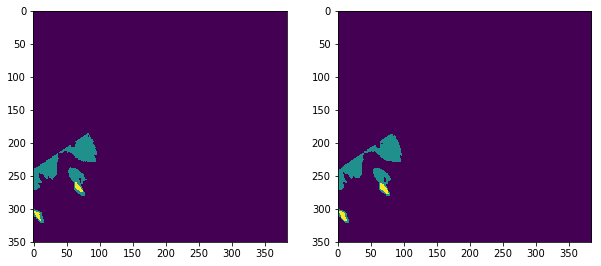

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 281, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 247, Metal: 0, Groups total: 2.0


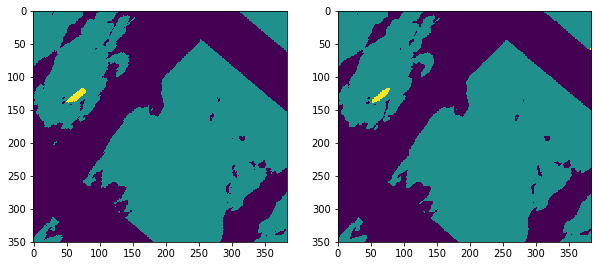

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 391, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 323, Metal: 0, Groups total: 2.0


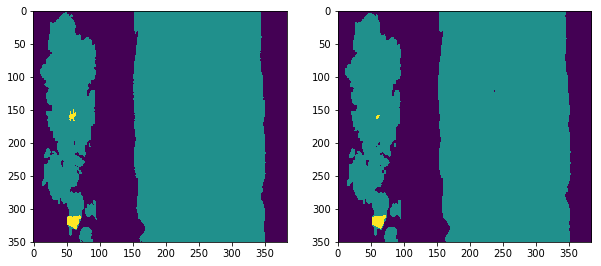

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 120, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


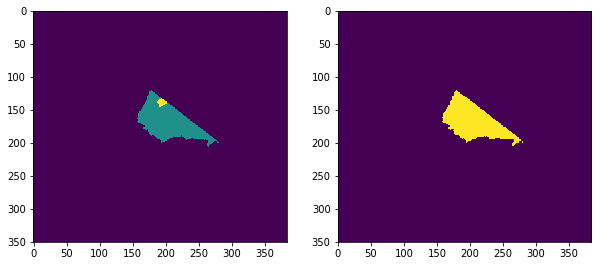

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 5, Metal: 0, Groups total: 1.0


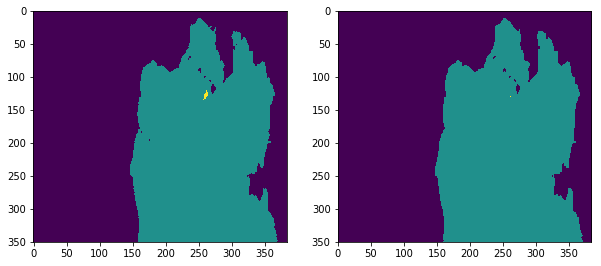

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 38, Metal: 0, Groups total: 1.0


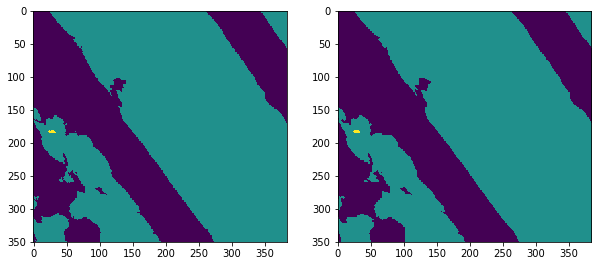

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 509, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 230, Metal: 0, Groups total: 2.0


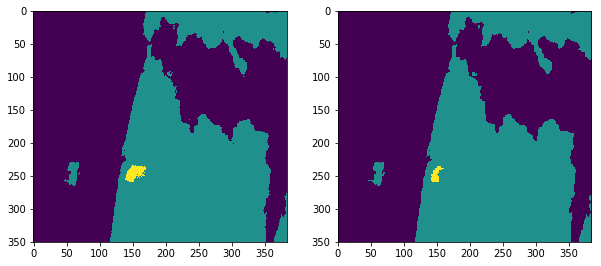

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 53, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 26, Metal: 0, Groups total: 2.0


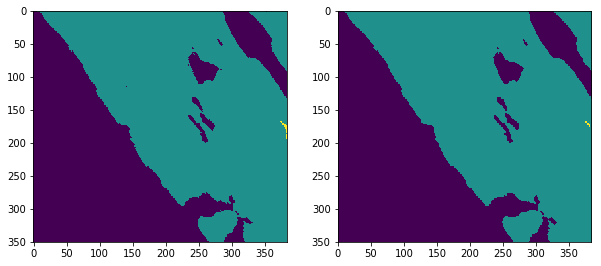

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 234, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 206, Metal: 0, Groups total: 1.0


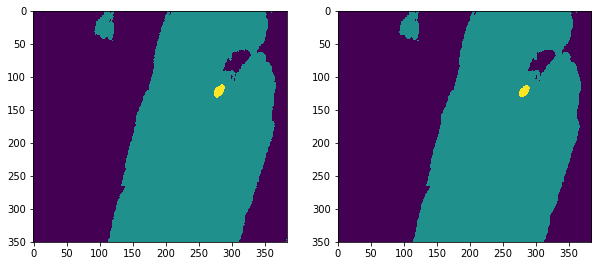

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 192, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 121, Metal: 0, Groups total: 1.0


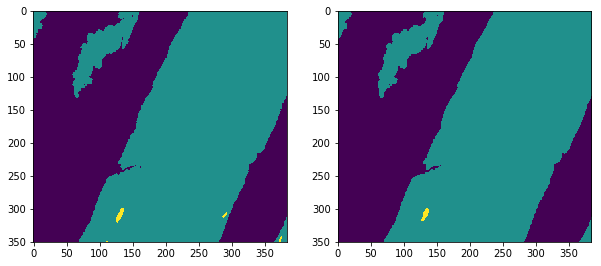

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 150, Metal: 0, Groups total: 1.0


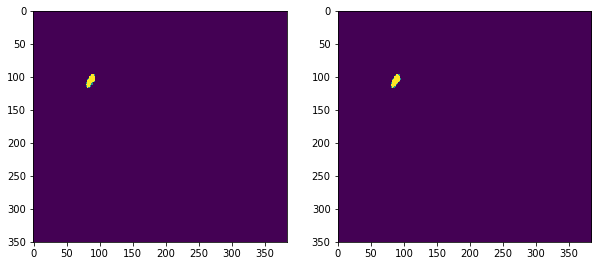

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 160, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 109, Metal: 0, Groups total: 4.0


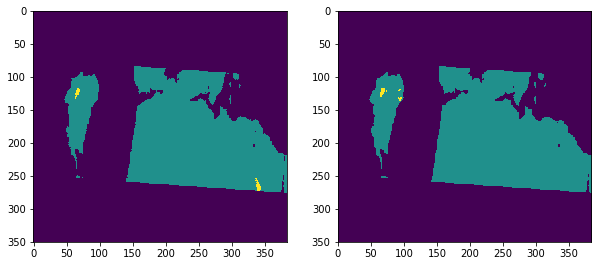

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 340, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 371, Metal: 0, Groups total: 1.0


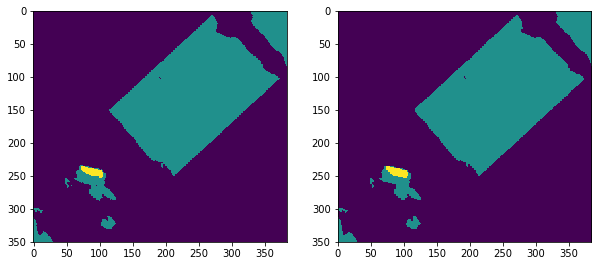

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 150, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 30, Metal: 0, Groups total: 8.0


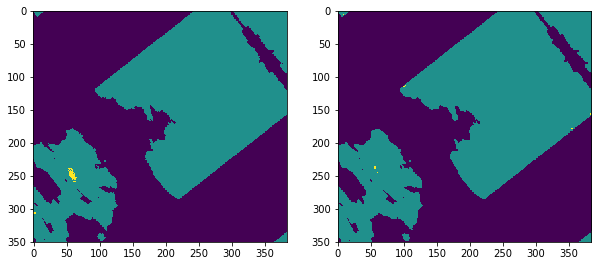

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 255, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 218, Metal: 0, Groups total: 1.0


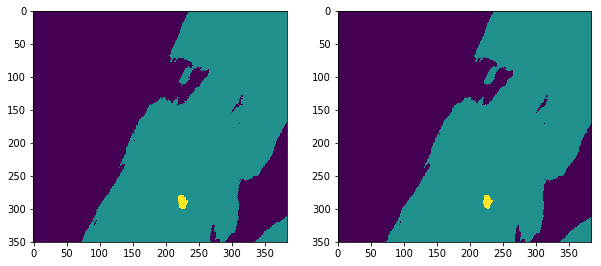

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 584, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 177, Metal: 0, Groups total: 2.0


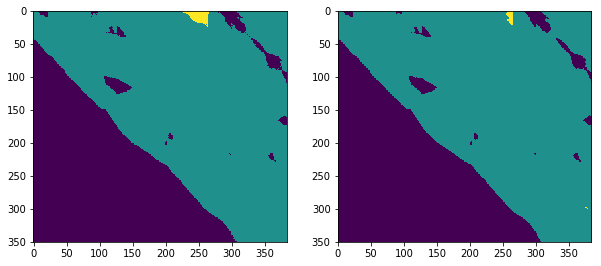

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


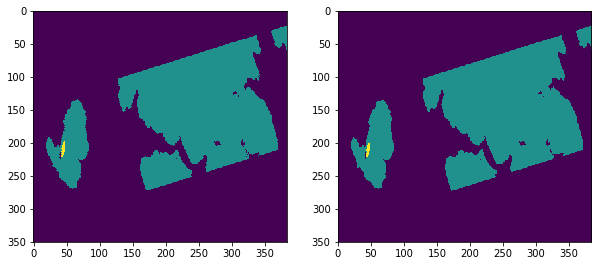

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 54, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 42, Metal: 0, Groups total: 1.0


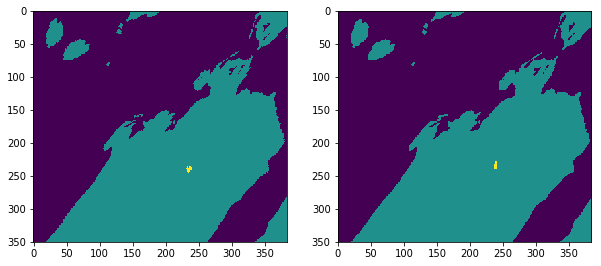

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 1.0


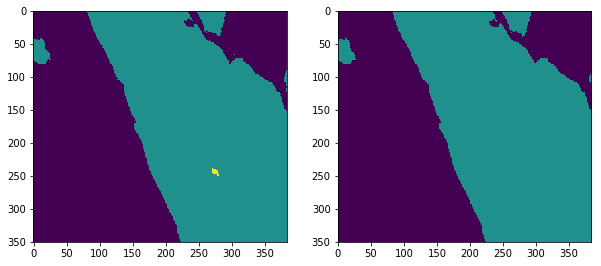

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 545, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 511, Metal: 0, Groups total: 2.0


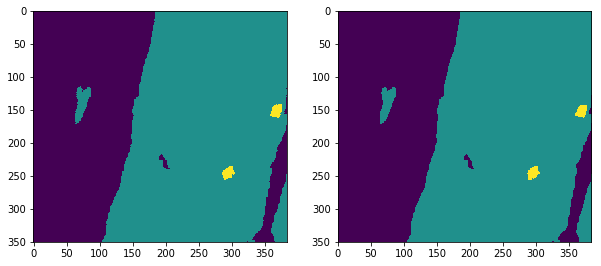

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 459, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 457, Metal: 0, Groups total: 2.0


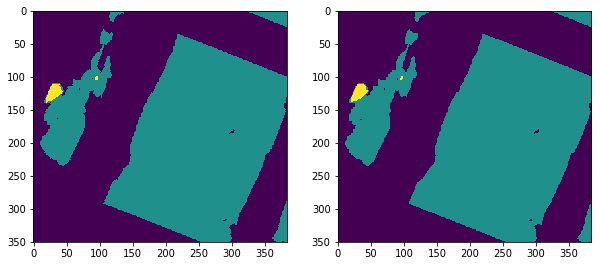

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 0, Groups total: 2.0


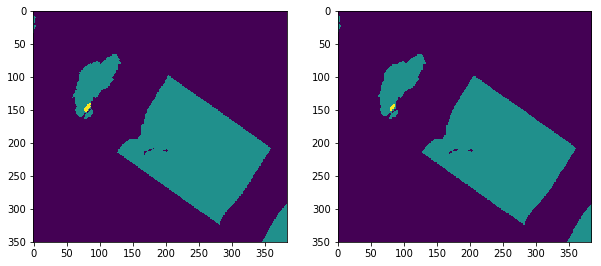

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 27, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


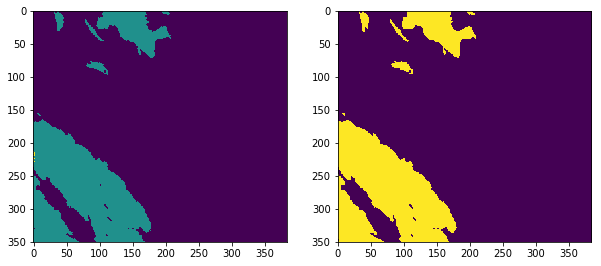

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 209, Metal: 0, Groups total: 6.0
Prediction   -> Bone: 211, Metal: 0, Groups total: 1.0


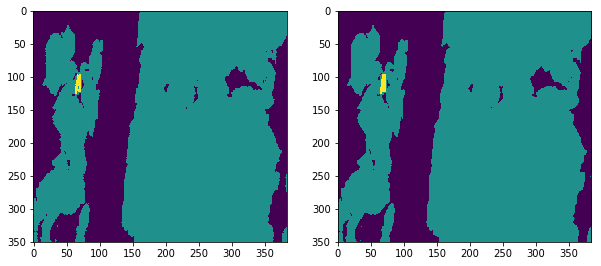

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 224, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 226, Metal: 0, Groups total: 2.0


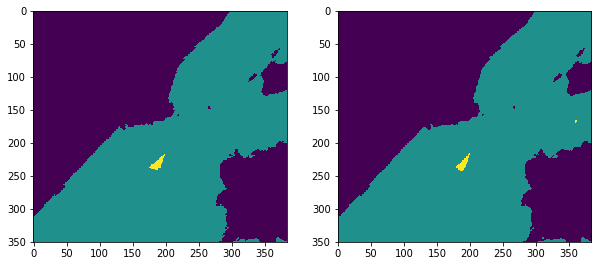

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 71, Metal: 0, Groups total: 1.0


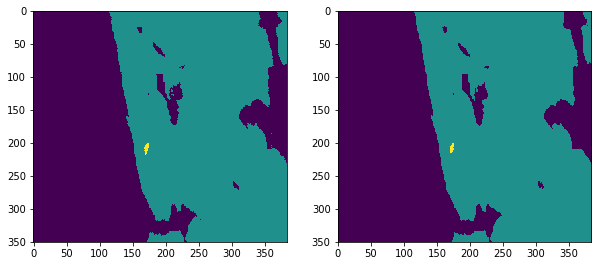

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 198, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 197, Metal: 0, Groups total: 1.0


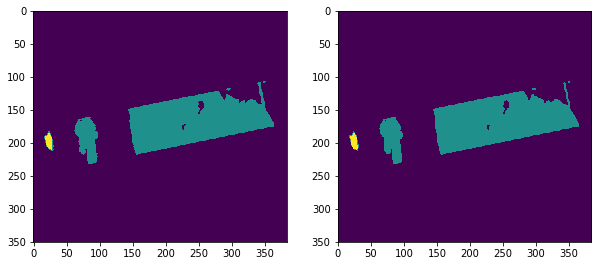

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 331, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 334, Metal: 0, Groups total: 1.0


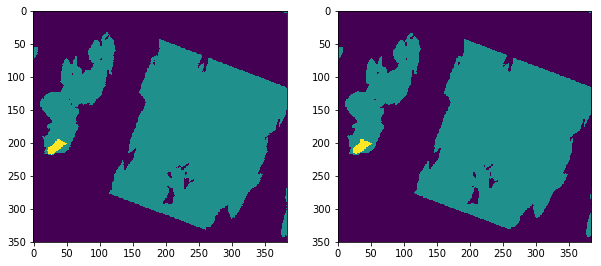

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 3576, Metal: 0, Groups total: 7.0
Prediction   -> Bone: 2770, Metal: 0, Groups total: 5.0


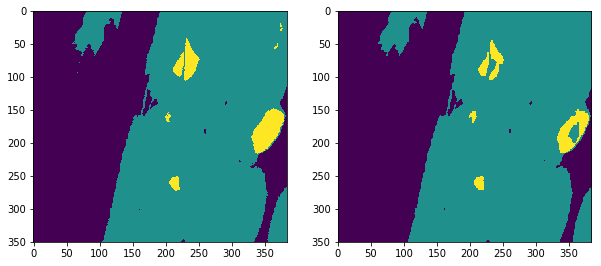

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 64, Metal: 0, Groups total: 1.0


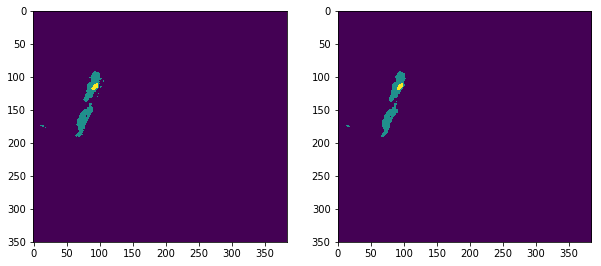

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2, Groups total: 1.0
Prediction   -> Bone: 16, Metal: 0, Groups total: 1.0


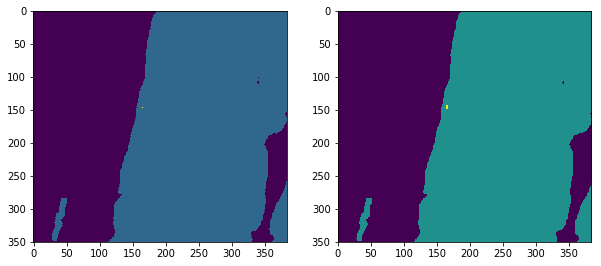

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 605, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 324, Metal: 0, Groups total: 2.0


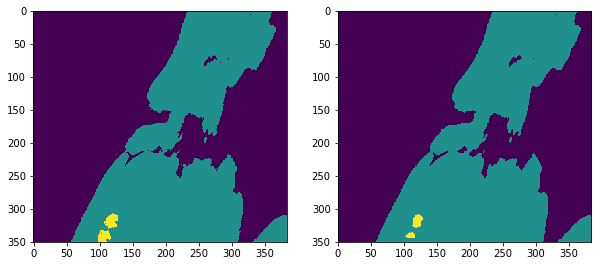

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 384, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 337, Metal: 0, Groups total: 4.0


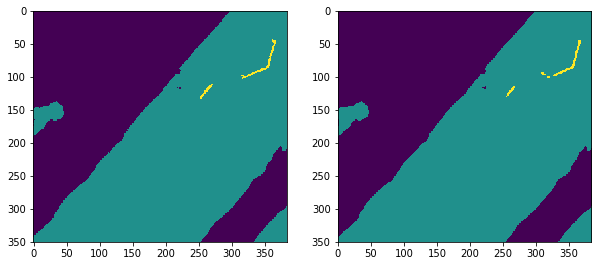

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 149, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 135, Metal: 0, Groups total: 3.0


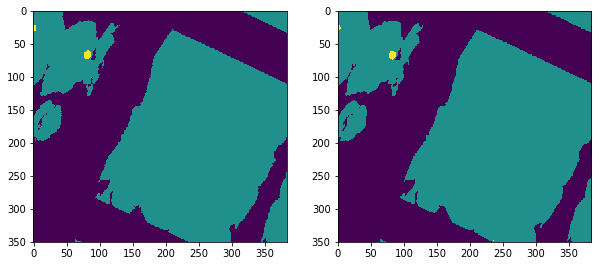

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 388, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 374, Metal: 0, Groups total: 1.0


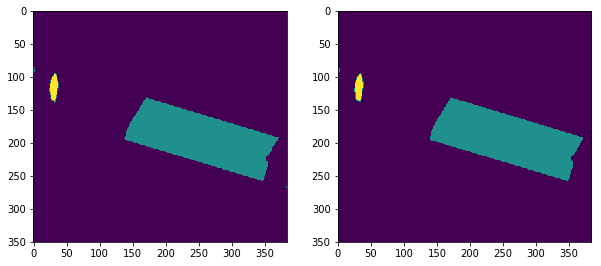

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 2.0


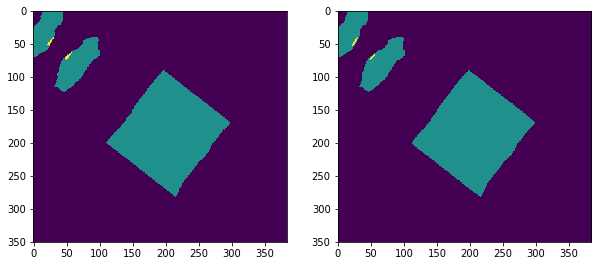

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 469, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 420, Metal: 0, Groups total: 2.0


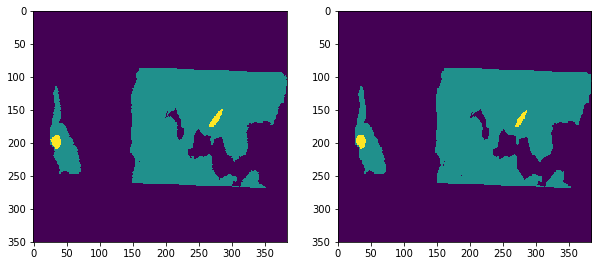

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 335, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 248, Metal: 0, Groups total: 3.0


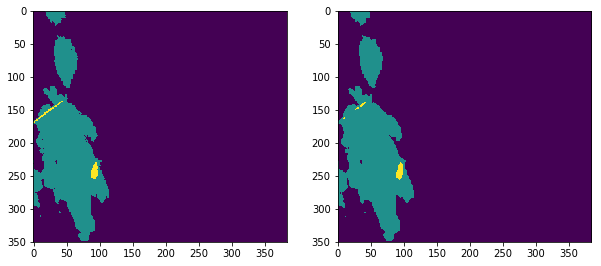

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 315, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 303, Metal: 0, Groups total: 2.0


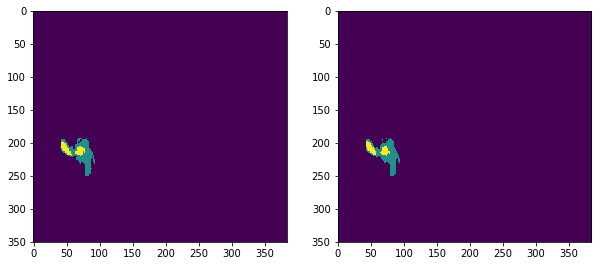

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 57, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 57, Metal: 0, Groups total: 1.0


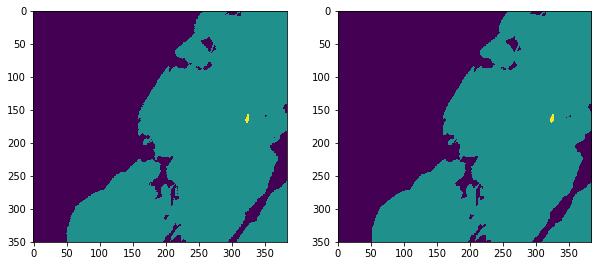

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1043, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 607, Metal: 0, Groups total: 3.0


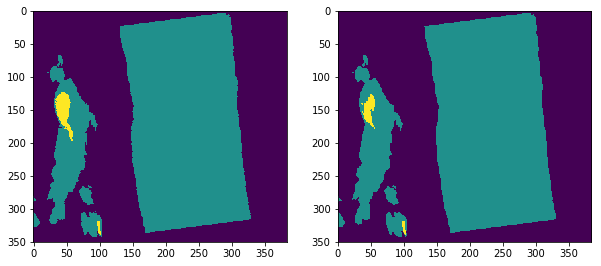

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 30, Metal: 0, Groups total: 1.0


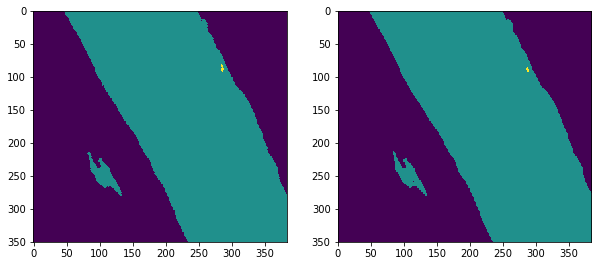

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 207, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 192, Metal: 0, Groups total: 3.0


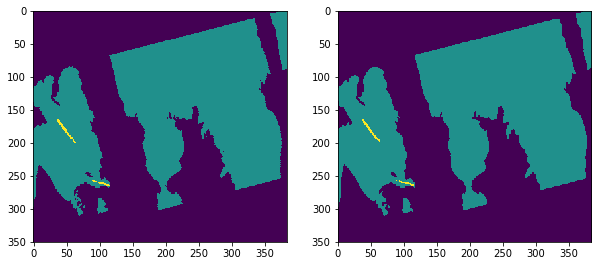

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 5, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


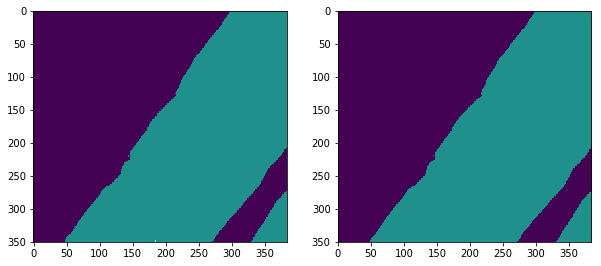

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 192, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 1.0


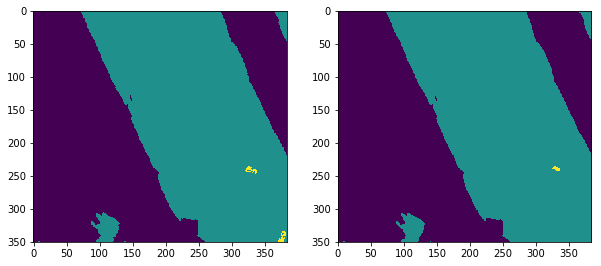

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 224, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


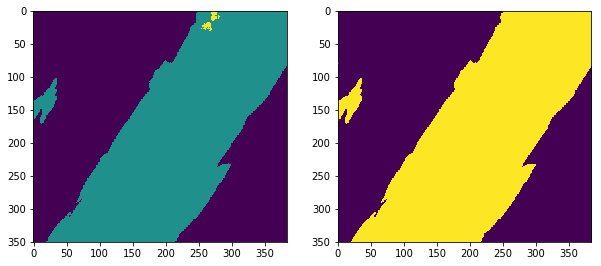

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 1.0


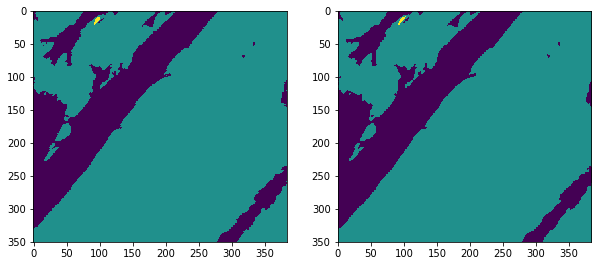

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 1.0


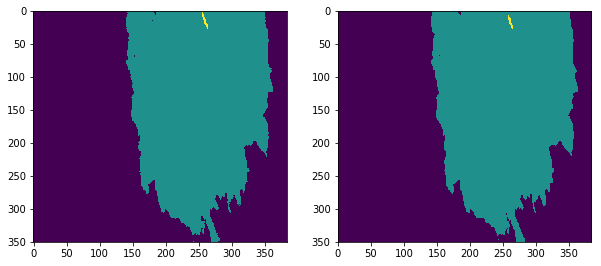

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 74, Metal: 0, Groups total: 1.0


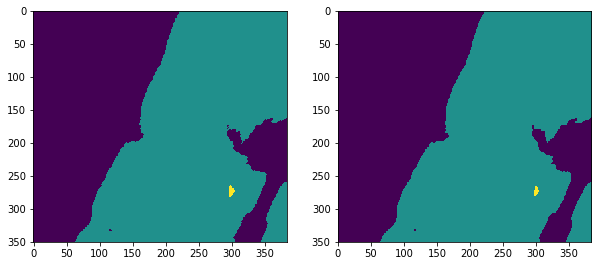

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 164, Metal: 0, Groups total: 1.0


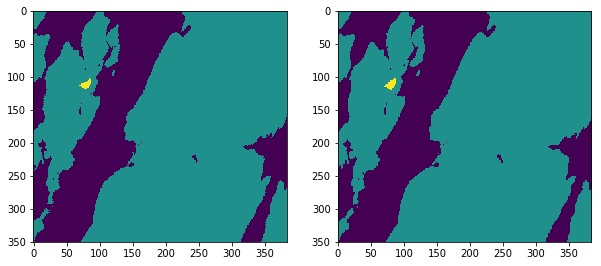

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 104, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


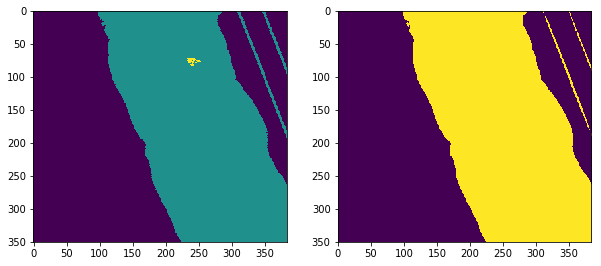

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 184, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 218, Metal: 0, Groups total: 15.0


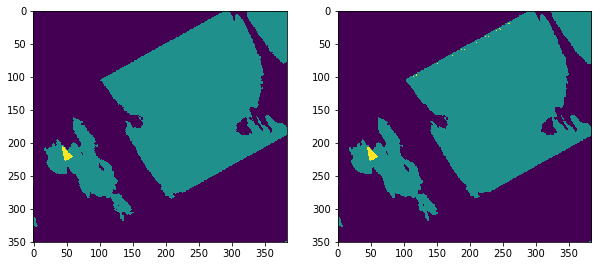

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 456, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 228, Metal: 0, Groups total: 1.0


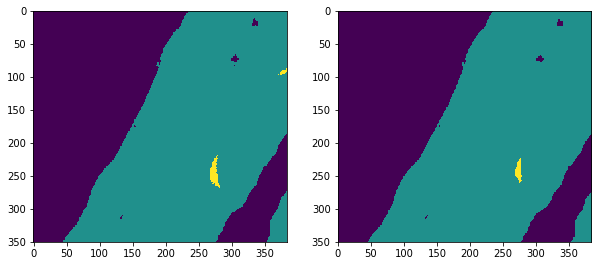

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 311, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 325, Metal: 0, Groups total: 1.0


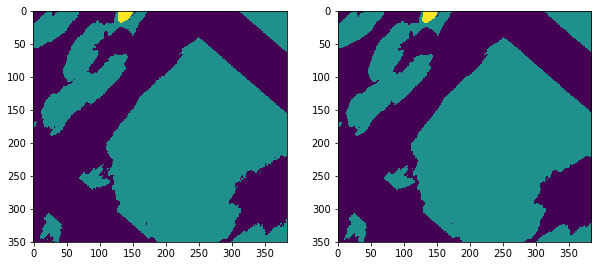

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 78, Metal: 0, Groups total: 2.0


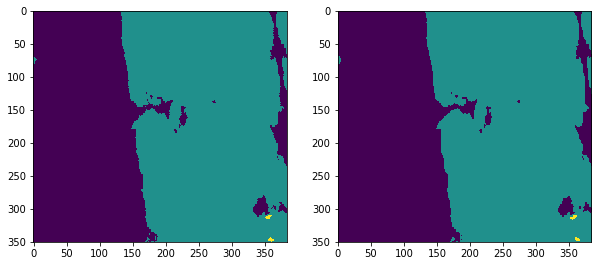

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 2.0


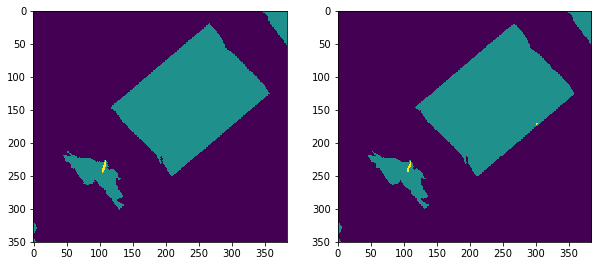

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 349, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 327, Metal: 0, Groups total: 7.0


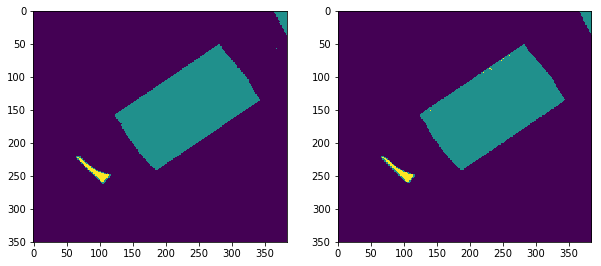

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


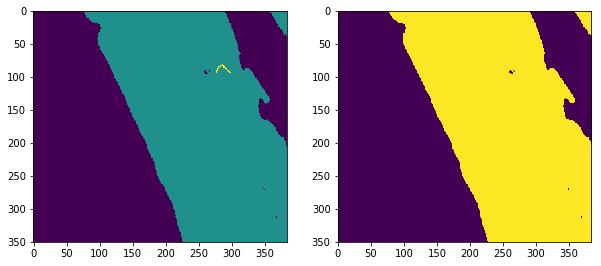

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 111, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 76, Metal: 0, Groups total: 2.0


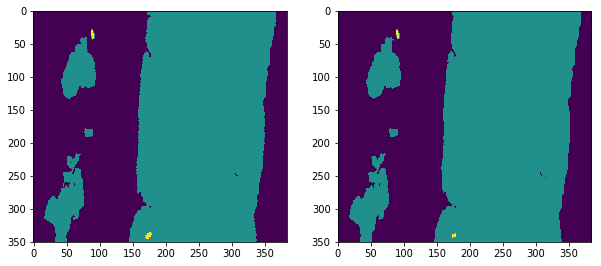

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 277, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 275, Metal: 0, Groups total: 6.0


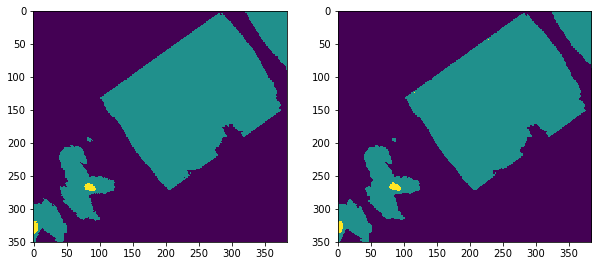

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 746, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 699, Metal: 0, Groups total: 2.0


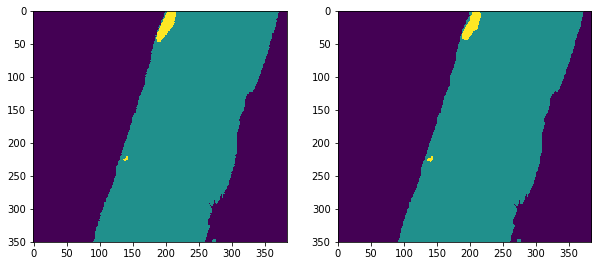

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 341, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


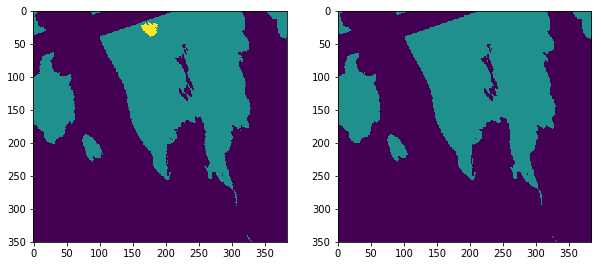

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 69, Metal: 0, Groups total: 2.0


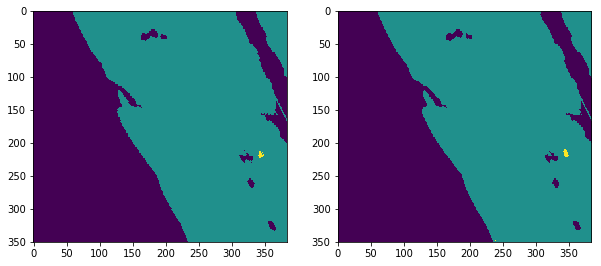

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 176, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 146, Metal: 0, Groups total: 2.0


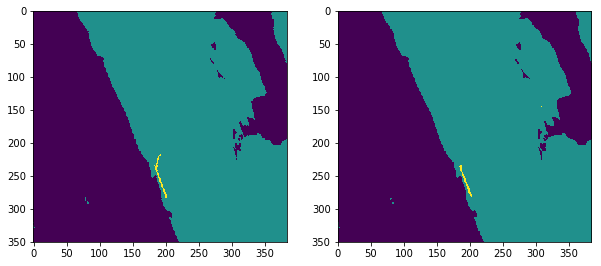

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 2882, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 2421, Metal: 0, Groups total: 5.0


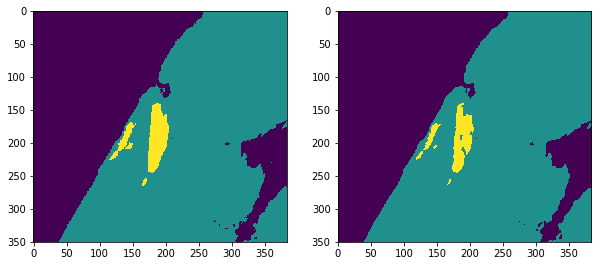

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 8, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 1.0


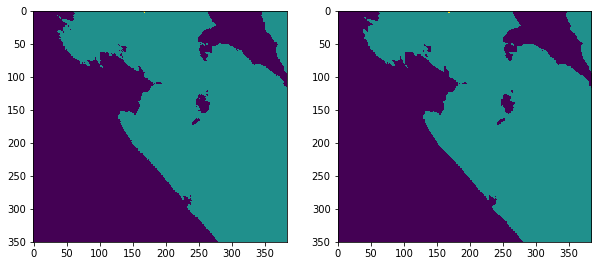

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 264, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 234, Metal: 0, Groups total: 4.0


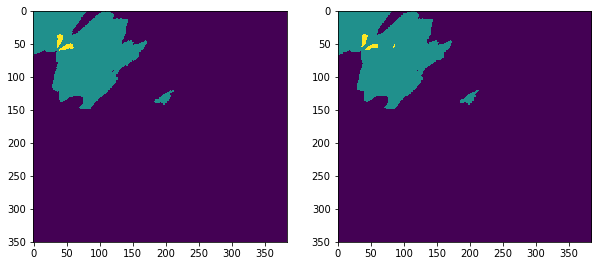

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 1.0


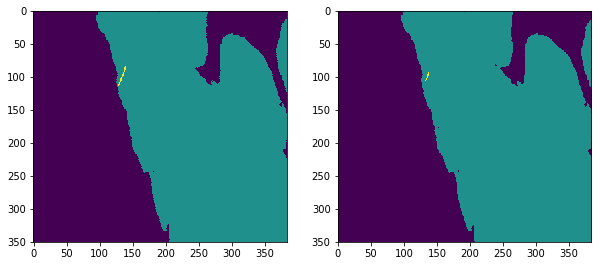

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 202, Metal: 0, Groups total: 2.0


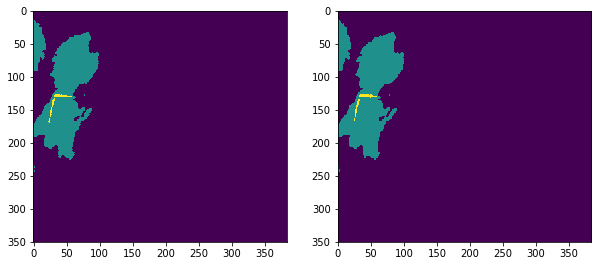

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 187, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 21, Metal: 0, Groups total: 1.0


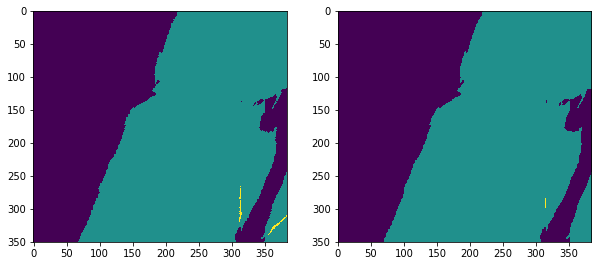

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 178, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 200, Metal: 0, Groups total: 4.0


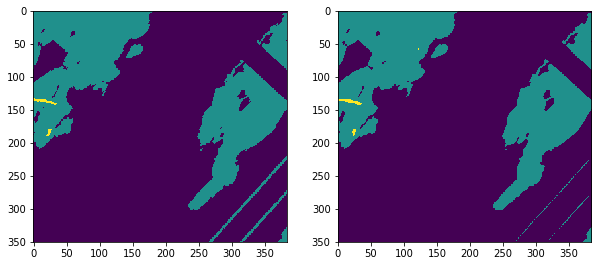

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 81, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


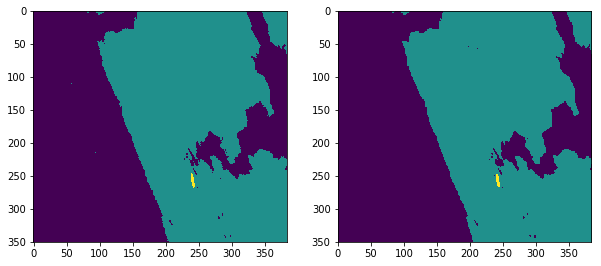

There is just Meat / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


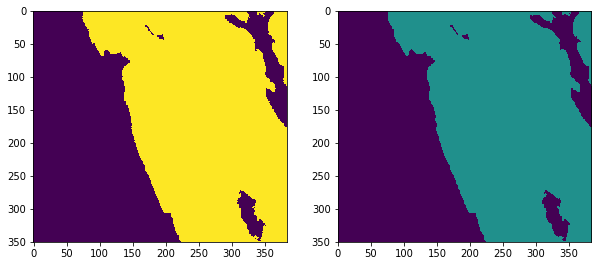

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 21, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


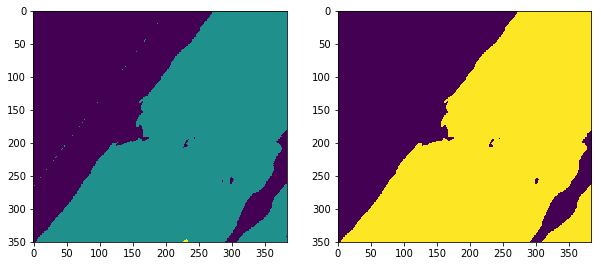

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 56, Metal: 0, Groups total: 3.0


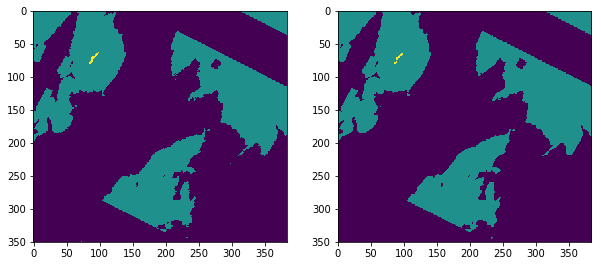

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 4, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


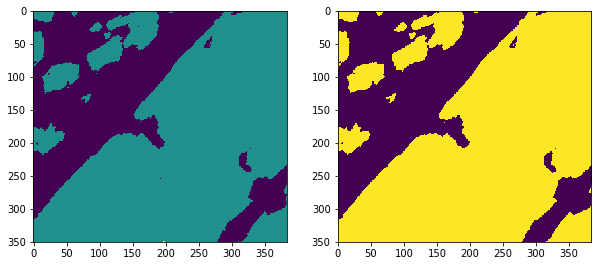

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 778, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 546, Metal: 0, Groups total: 3.0


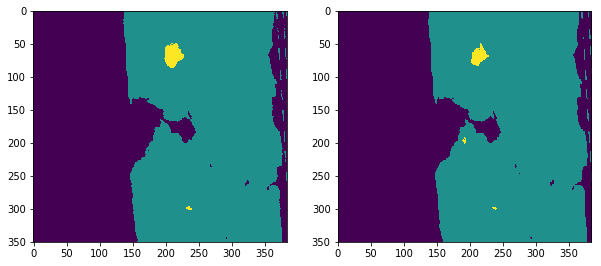

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 142, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 139, Metal: 0, Groups total: 1.0


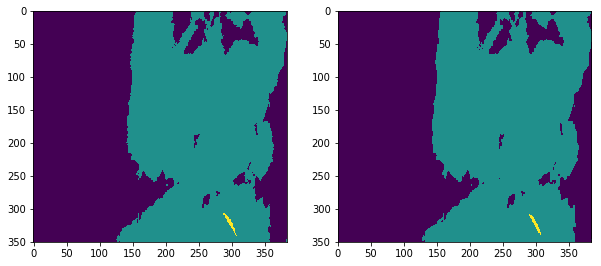

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 117, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 37, Metal: 0, Groups total: 3.0


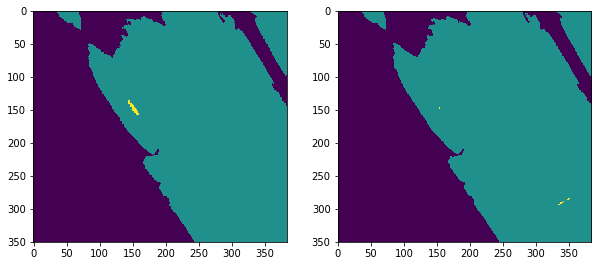

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 78, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


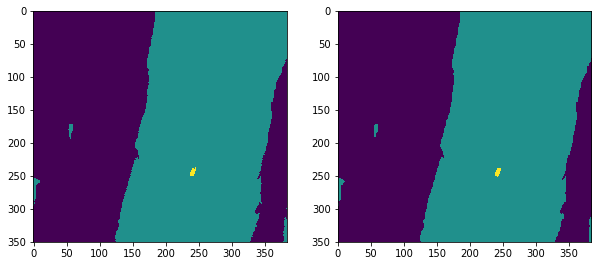

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 1.0


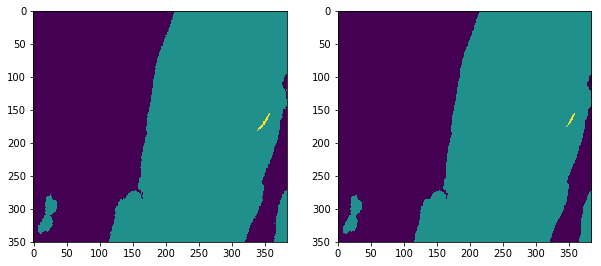

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 252, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 2.0


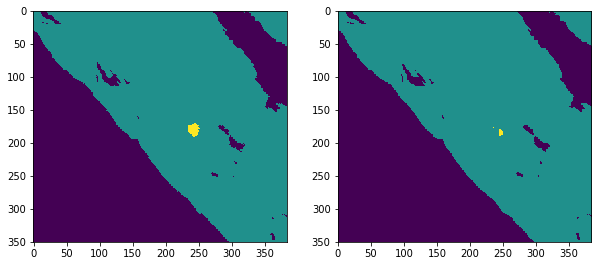

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 156, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


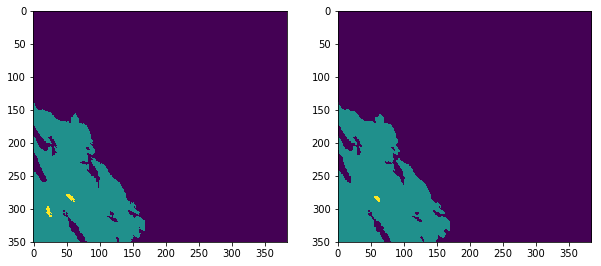

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 35, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 42, Metal: 0, Groups total: 1.0


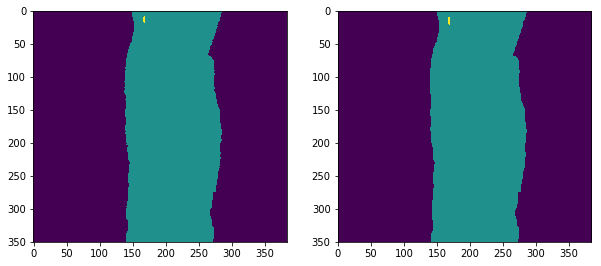

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 4, Groups total: 2.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 2.0


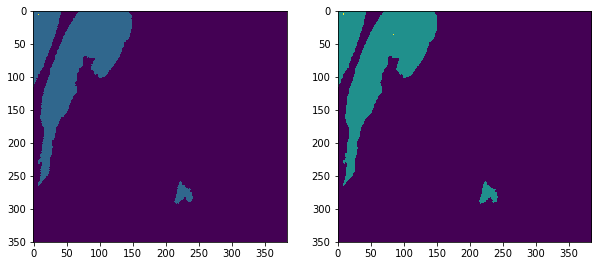

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 1.0


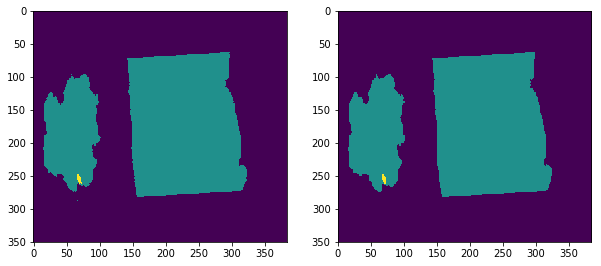

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 121, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 30, Metal: 0, Groups total: 3.0


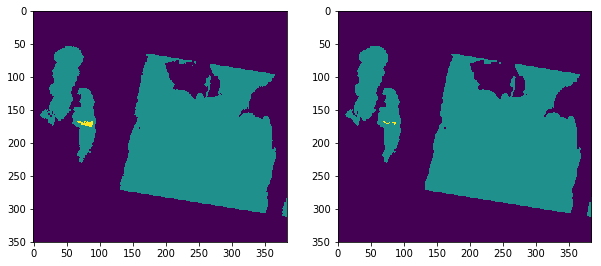

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 118, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 83, Metal: 0, Groups total: 4.0


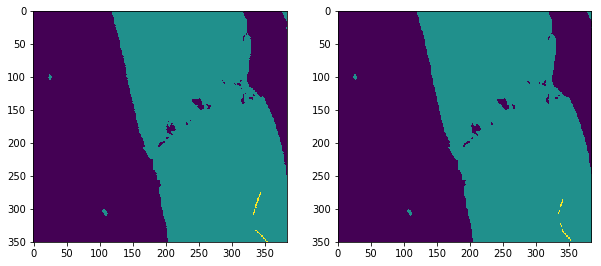

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 953, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 781, Metal: 0, Groups total: 4.0


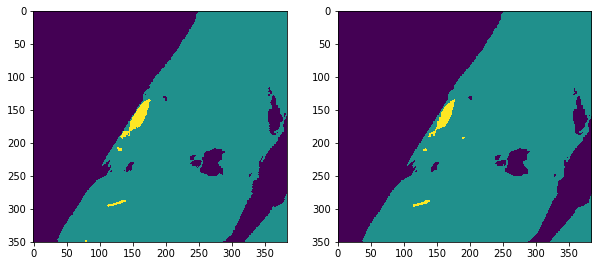

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 537, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 633, Metal: 0, Groups total: 2.0


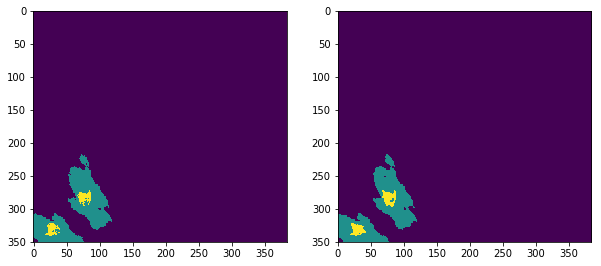

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 169, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 127, Metal: 0, Groups total: 1.0


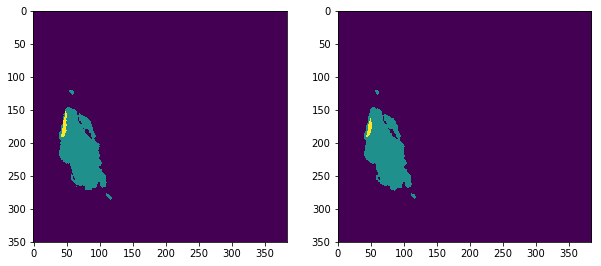

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 1.0


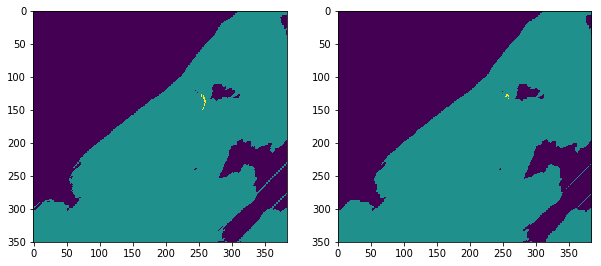

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 107, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 123, Metal: 0, Groups total: 1.0


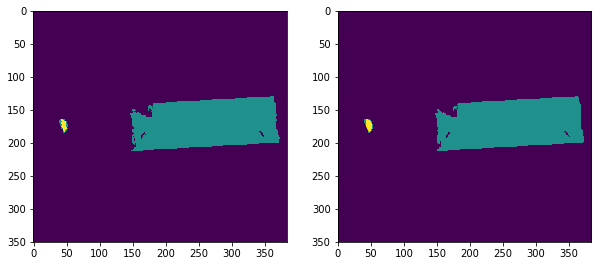

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 53, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 66, Metal: 0, Groups total: 1.0


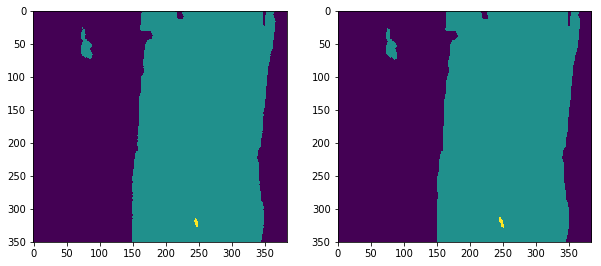

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 240, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 184, Metal: 0, Groups total: 2.0


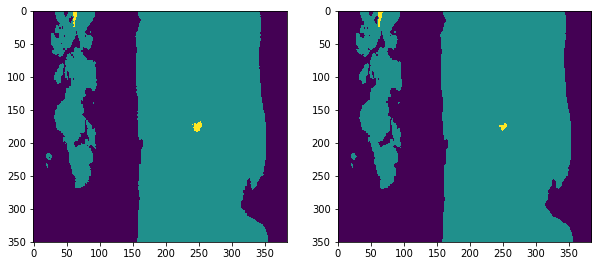

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 313, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 134, Metal: 0, Groups total: 2.0


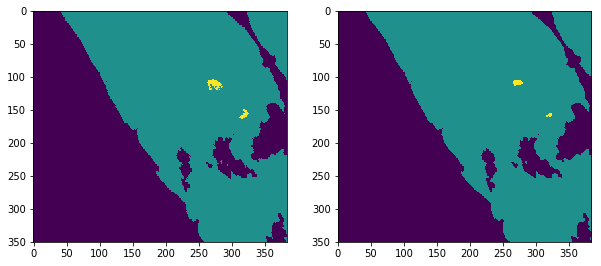

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 99, Metal: 0, Groups total: 1.0


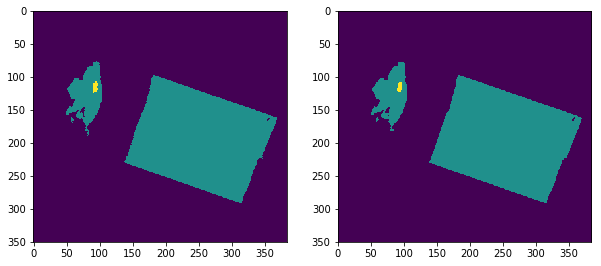

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 204, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 210, Metal: 0, Groups total: 1.0


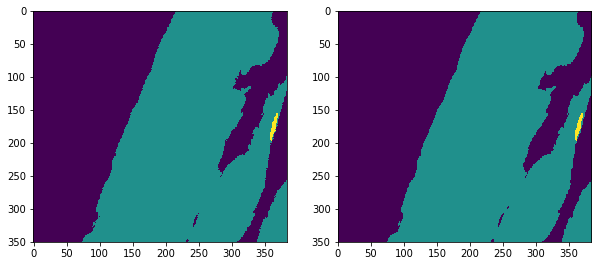

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


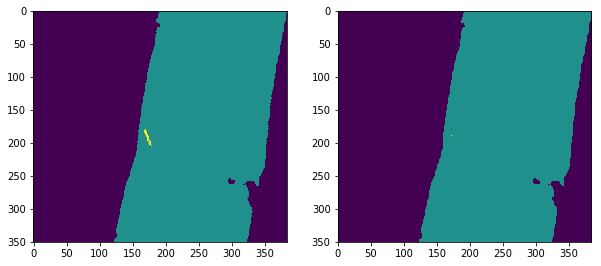

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 811, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 777, Metal: 0, Groups total: 13.0


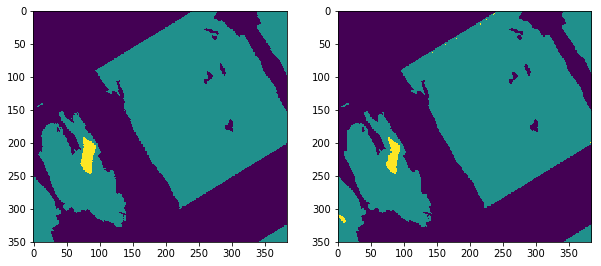

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1462, Metal: 0, Groups total: 10.0
Prediction   -> Bone: 1395, Metal: 0, Groups total: 11.0


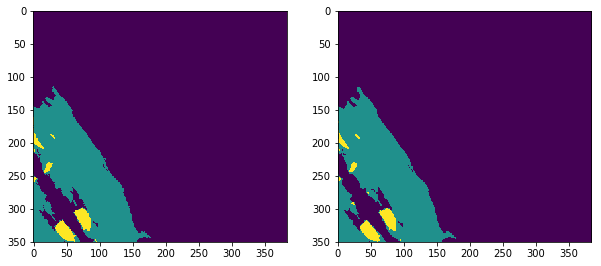

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 197, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 204, Metal: 0, Groups total: 1.0


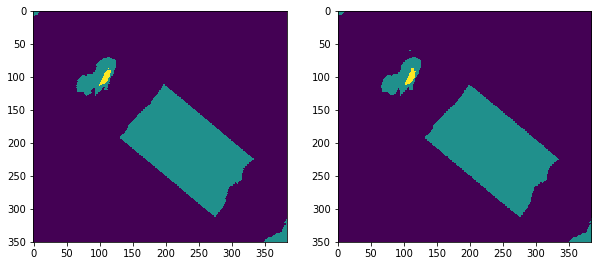

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 232, Metal: 0, Groups total: 1.0


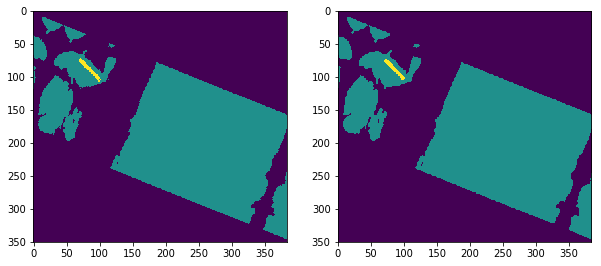

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 161, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 166, Metal: 0, Groups total: 1.0


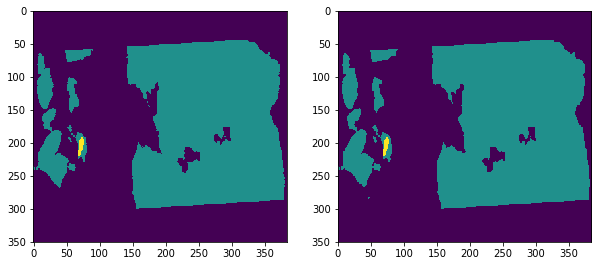

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


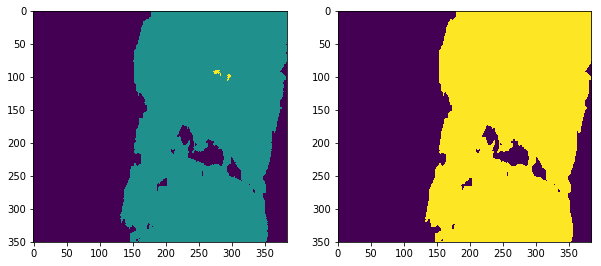

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 111, Metal: 0, Groups total: 1.0


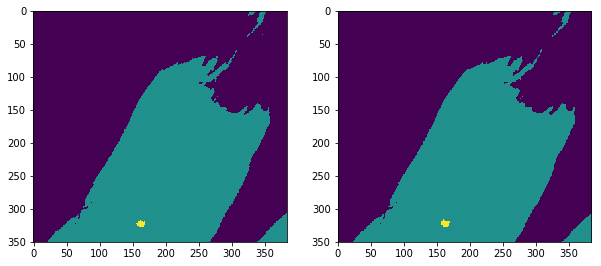

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


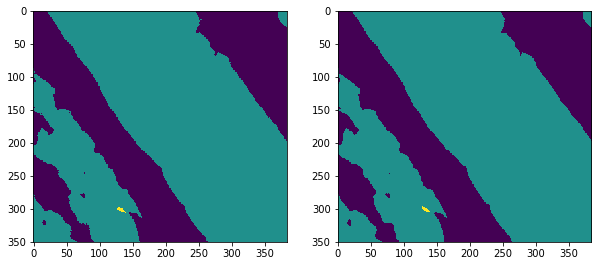

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 134, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 157, Metal: 0, Groups total: 2.0


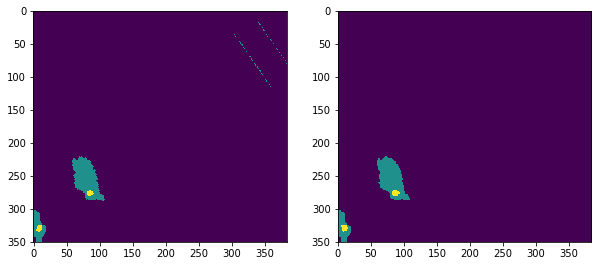

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 3.0


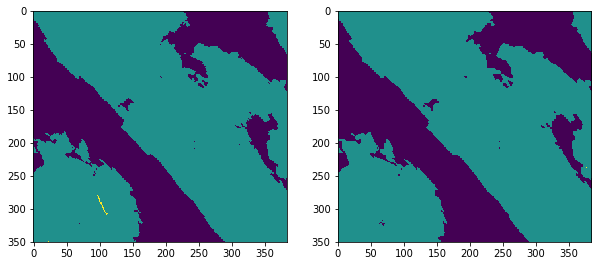

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 26, Metal: 0, Groups total: 3.0


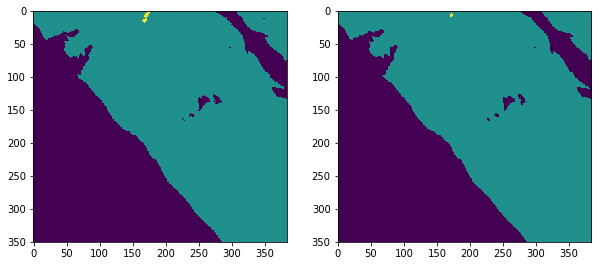

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 123, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 108, Metal: 0, Groups total: 4.0


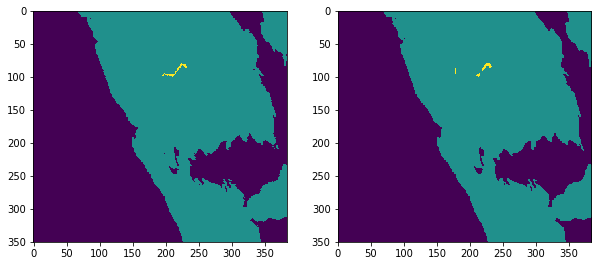

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 106, Metal: 0, Groups total: 1.0


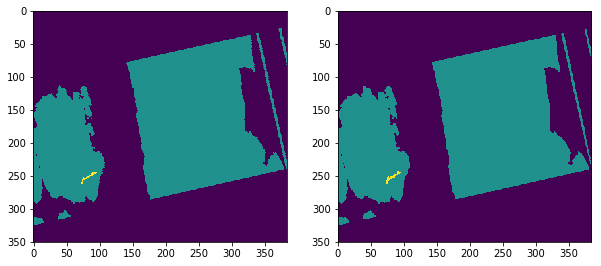

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


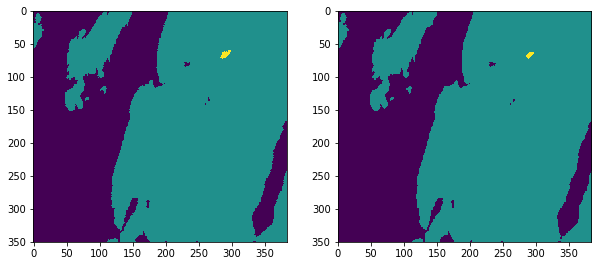

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1147, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1132, Metal: 0, Groups total: 2.0


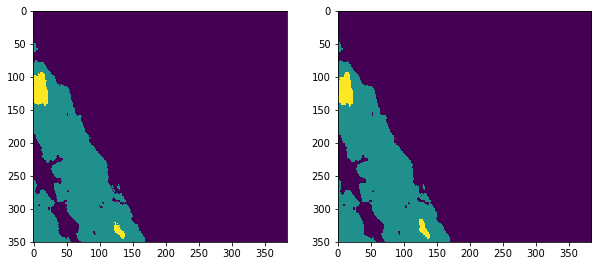

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 177, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 42, Metal: 0, Groups total: 3.0


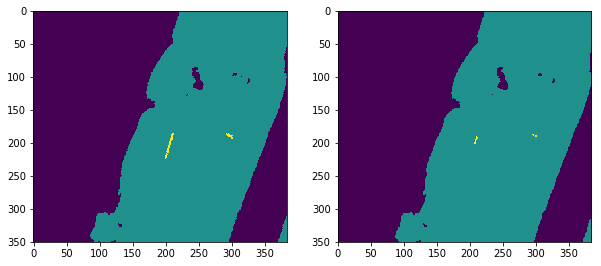

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 312, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 301, Metal: 0, Groups total: 1.0


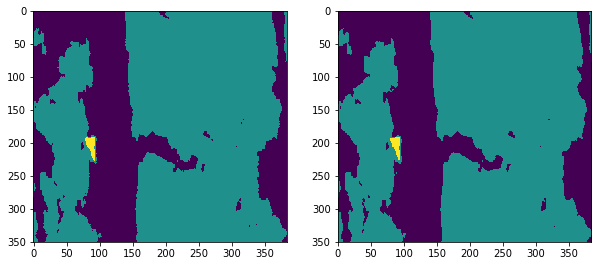

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 190, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 165, Metal: 0, Groups total: 1.0


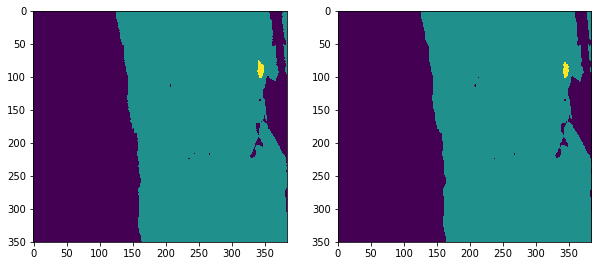

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 347, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 341, Metal: 0, Groups total: 2.0


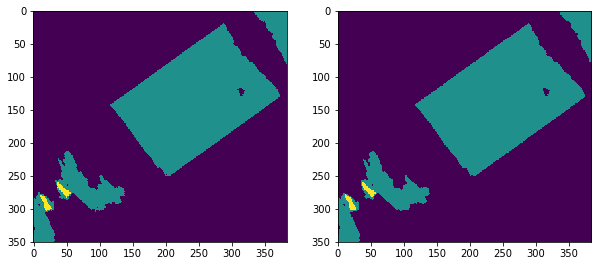

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 50, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


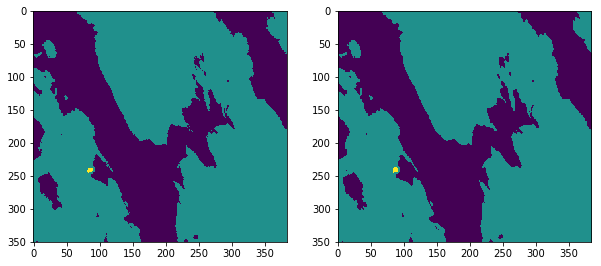

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 166, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


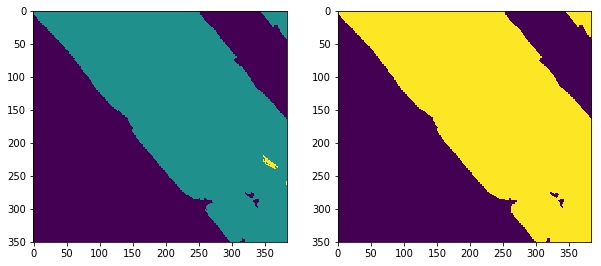

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 77, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 77, Metal: 0, Groups total: 1.0


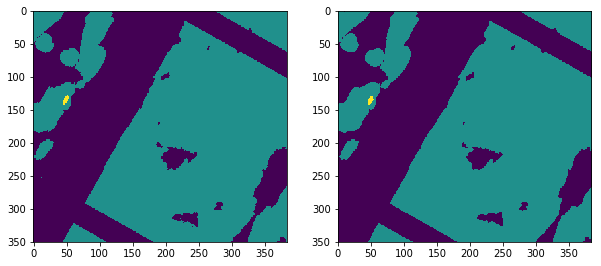

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 45, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 52, Metal: 0, Groups total: 1.0


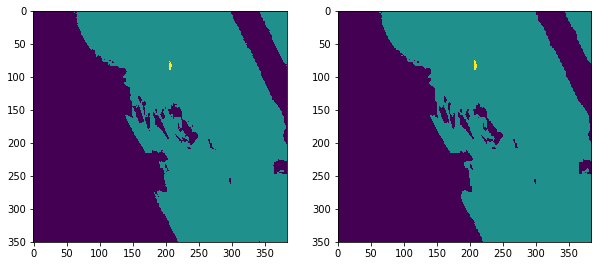

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 157, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 69, Metal: 0, Groups total: 1.0


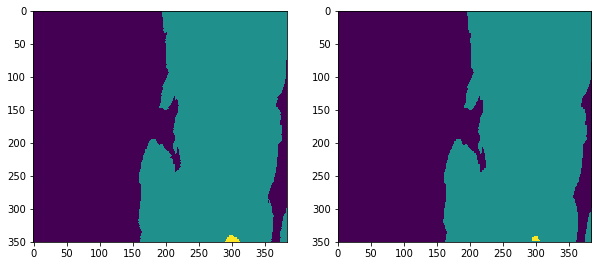

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 3538, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1904, Metal: 0, Groups total: 6.0


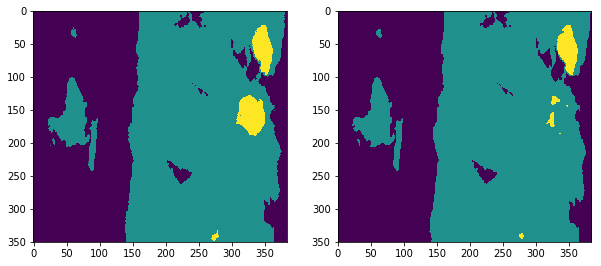

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 192, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 176, Metal: 0, Groups total: 1.0


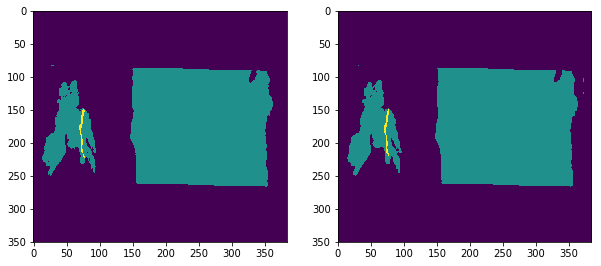

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 144, Metal: 0, Groups total: 7.0


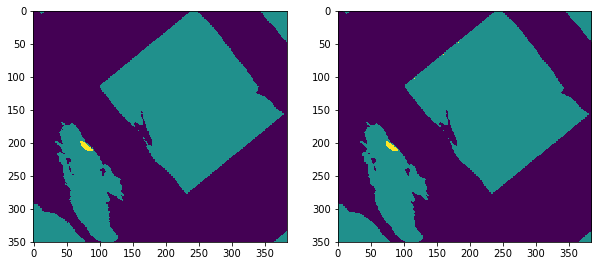

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 316, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 263, Metal: 0, Groups total: 1.0


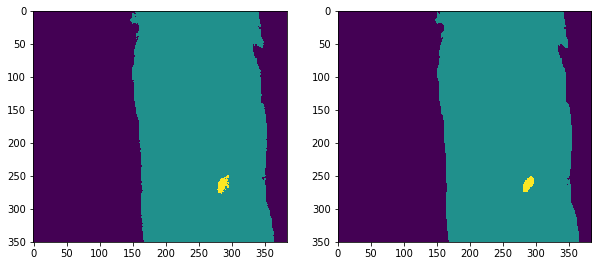

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 428, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 229, Metal: 0, Groups total: 6.0


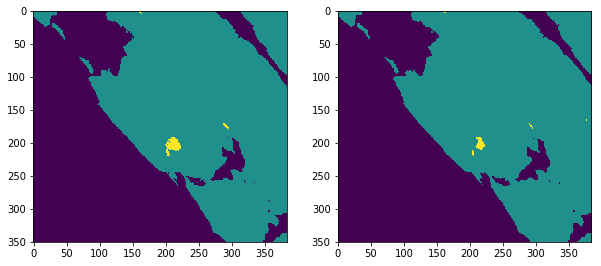

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 101, Metal: 0, Groups total: 2.0


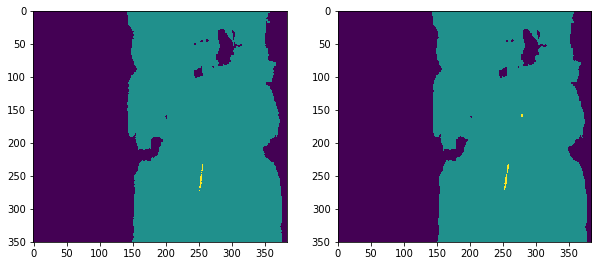

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 132, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 143, Metal: 0, Groups total: 3.0


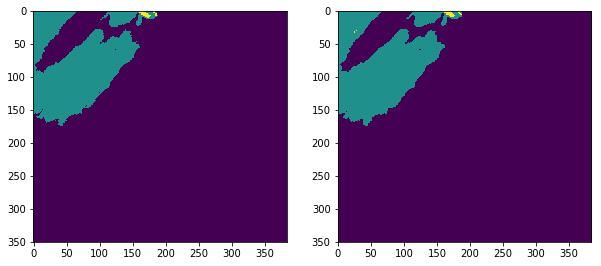

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 553, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 500, Metal: 0, Groups total: 4.0


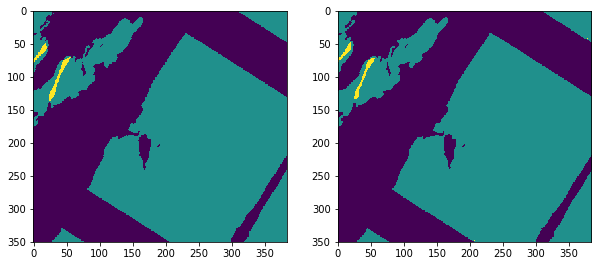

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 39, Metal: 0, Groups total: 1.0


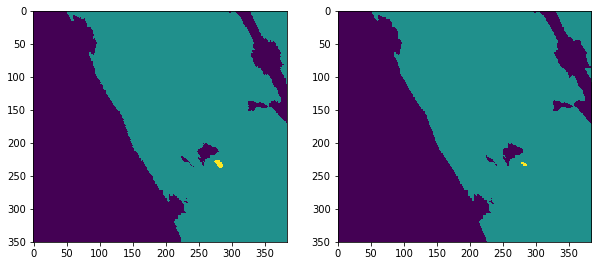

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 293, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 286, Metal: 0, Groups total: 6.0


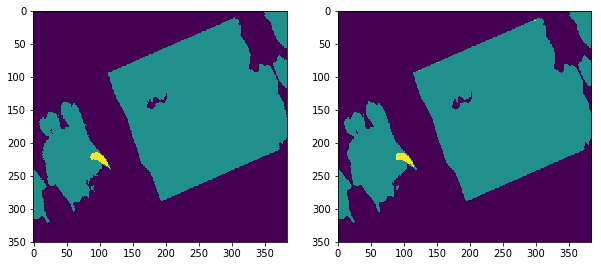

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 316, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 216, Metal: 0, Groups total: 1.0


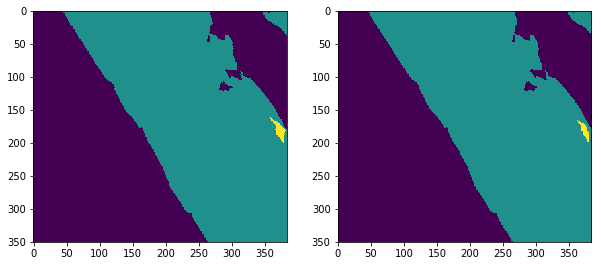

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 104, Metal: 0, Groups total: 3.0


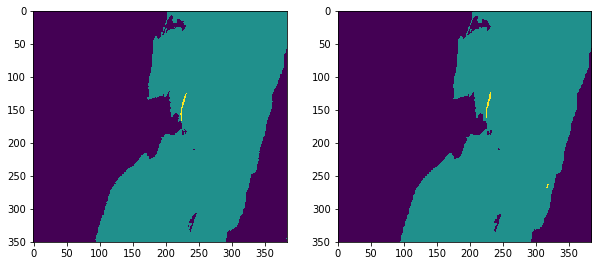

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 318, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 230, Metal: 0, Groups total: 3.0


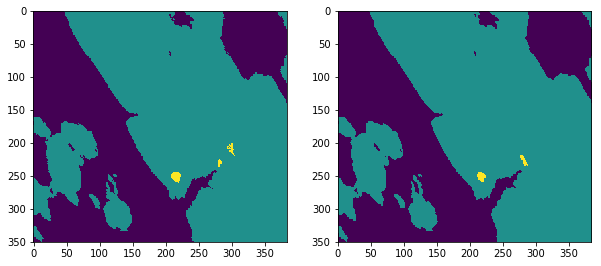

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 183, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


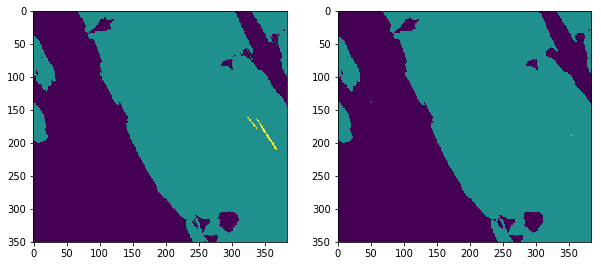

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 31, Metal: 0, Groups total: 5.0


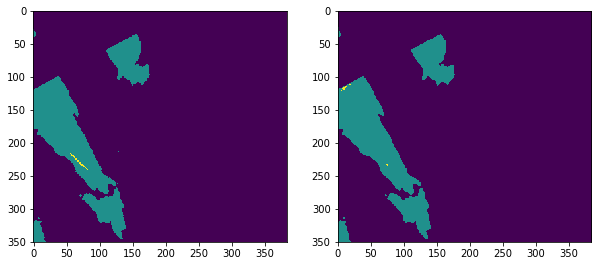

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 97, Metal: 0, Groups total: 2.0


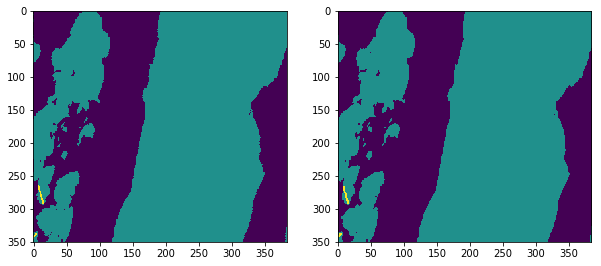

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 37, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 19, Metal: 0, Groups total: 1.0


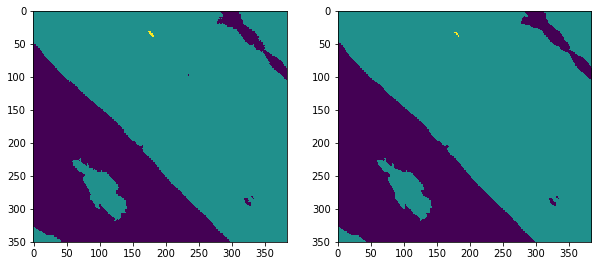

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1316, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 1091, Metal: 0, Groups total: 4.0


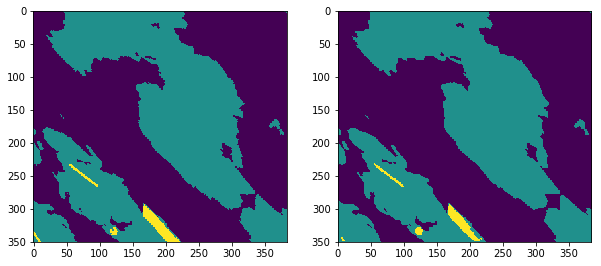

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 224, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 197, Metal: 0, Groups total: 1.0


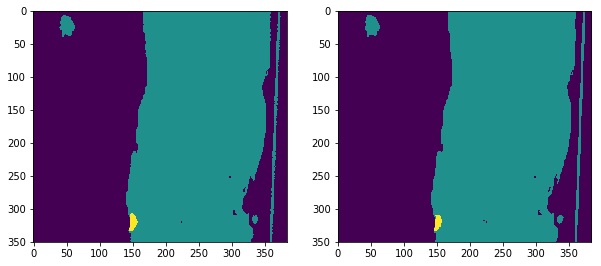

There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


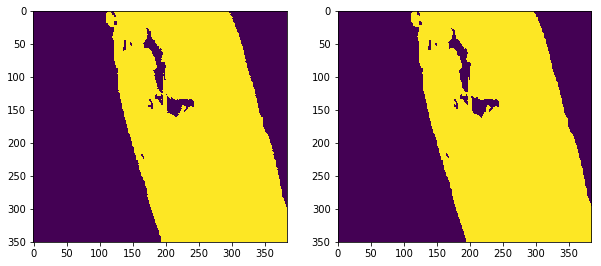

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 414, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 410, Metal: 0, Groups total: 1.0


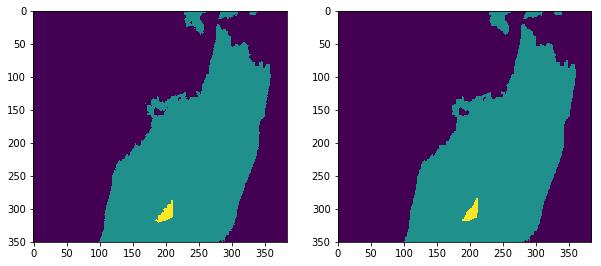

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 282, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 265, Metal: 0, Groups total: 1.0


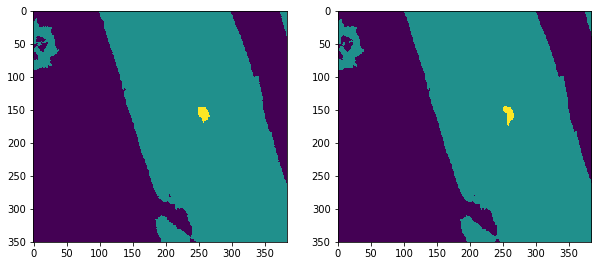

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 100, Metal: 0, Groups total: 2.0


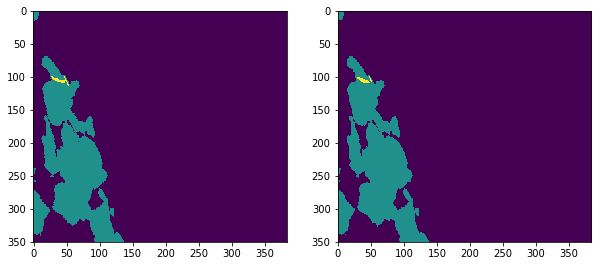

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 448, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 482, Metal: 0, Groups total: 2.0


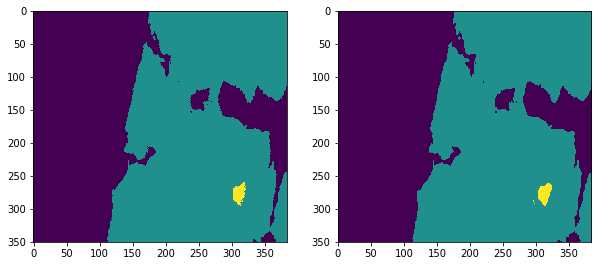

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 135, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 128, Metal: 0, Groups total: 1.0


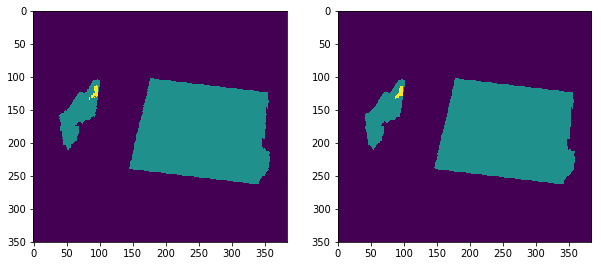

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 489, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 460, Metal: 0, Groups total: 3.0


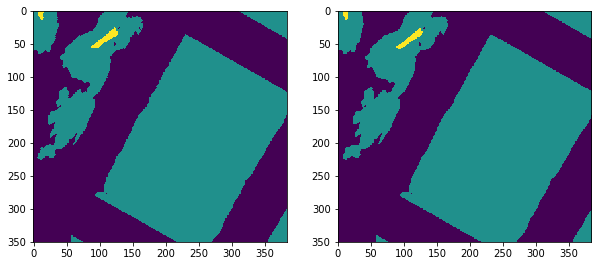

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 81, Metal: 0, Groups total: 1.0


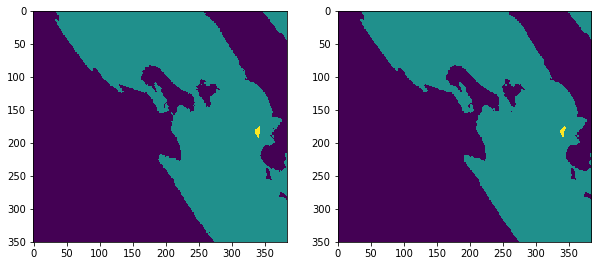

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 222, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 67, Metal: 0, Groups total: 2.0


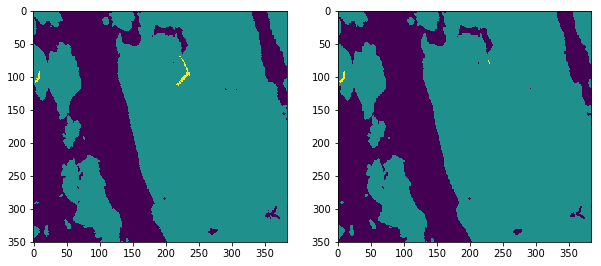

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 273, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 198, Metal: 0, Groups total: 3.0


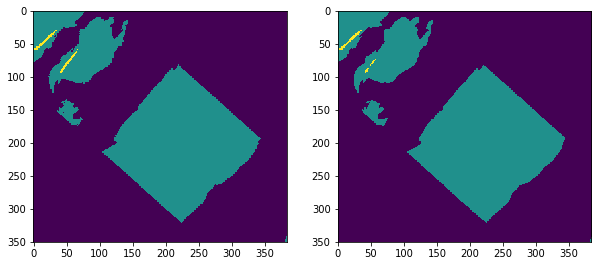

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


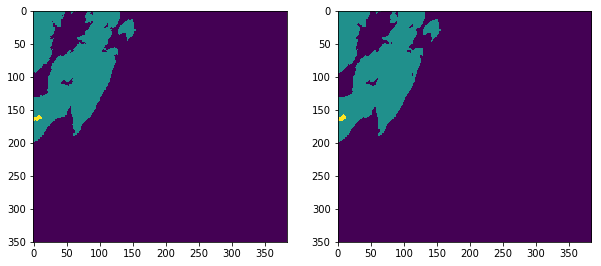

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 224, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 194, Metal: 0, Groups total: 1.0


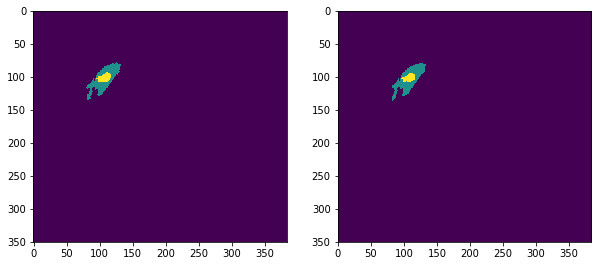

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 745, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 373, Metal: 0, Groups total: 3.0


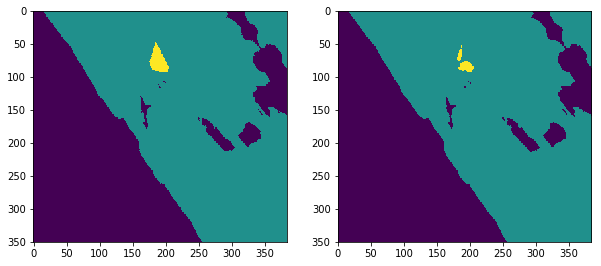

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 279, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 251, Metal: 0, Groups total: 5.0


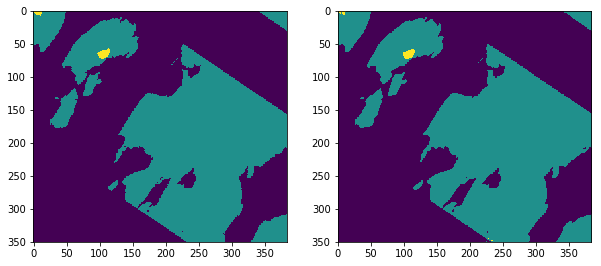

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 549, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 461, Metal: 0, Groups total: 2.0


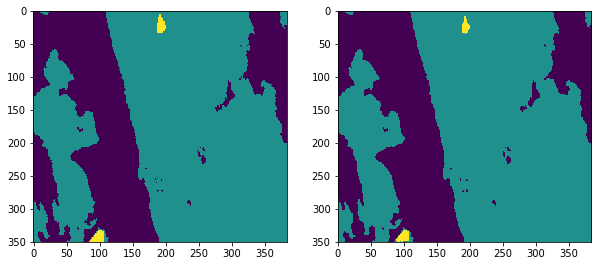

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 230, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 273, Metal: 0, Groups total: 2.0


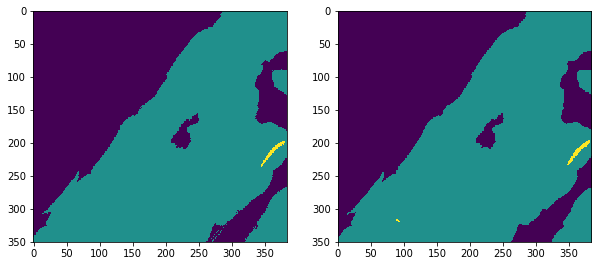

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 206, Metal: 0, Groups total: 3.0


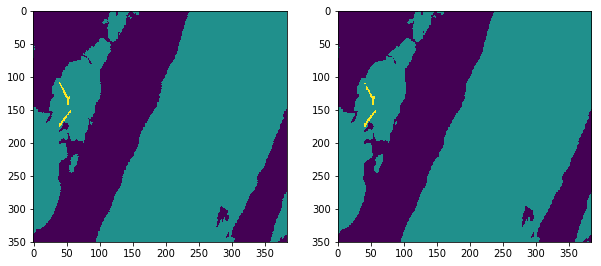

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 62, Metal: 0, Groups total: 1.0


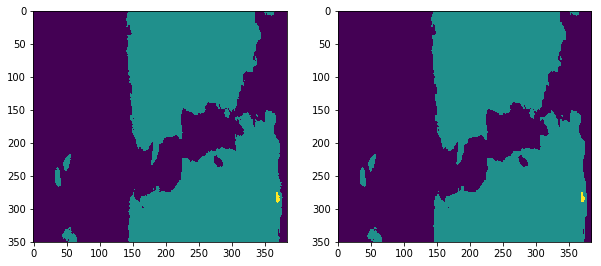

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 271, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 95, Metal: 0, Groups total: 3.0


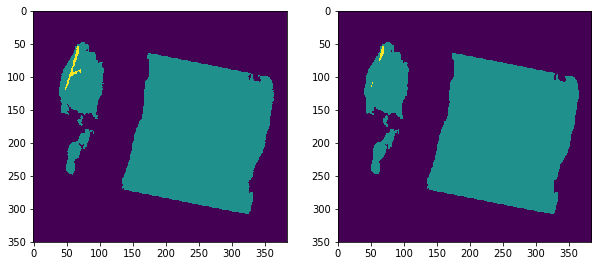

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 118, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 134, Metal: 0, Groups total: 1.0


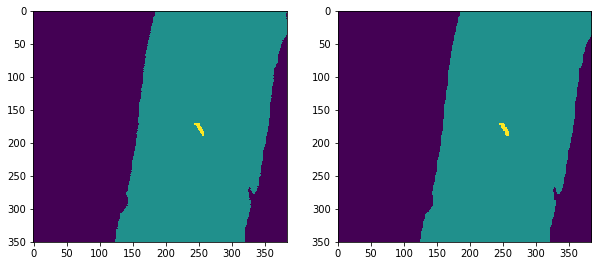

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 311, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 305, Metal: 0, Groups total: 1.0


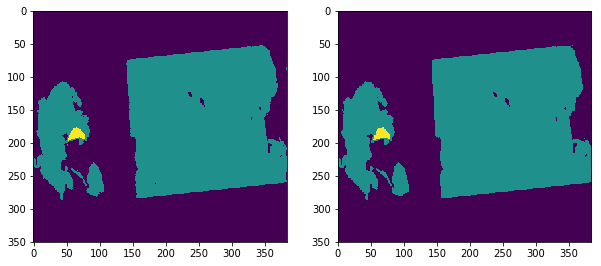

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 371, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 352, Metal: 0, Groups total: 6.0


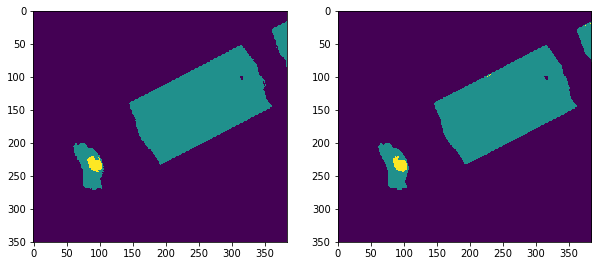

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 635, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 620, Metal: 0, Groups total: 13.0


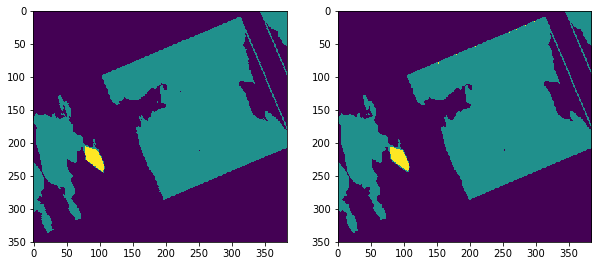

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 181, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 10, Metal: 0, Groups total: 2.0


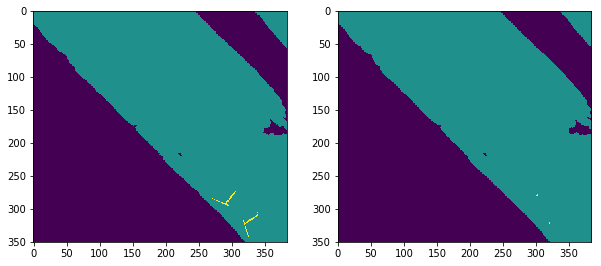

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 1.0


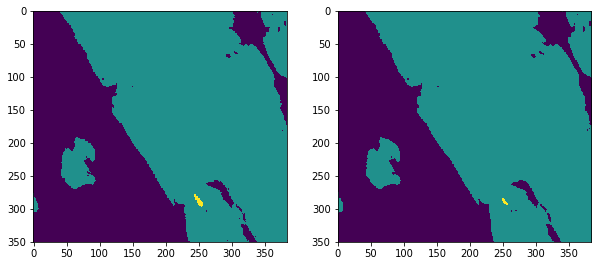

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


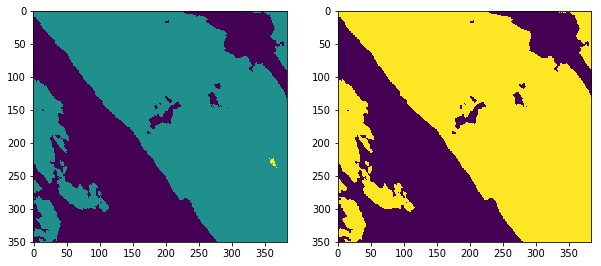

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 315, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 241, Metal: 0, Groups total: 1.0


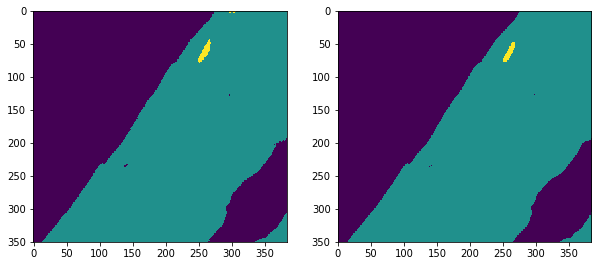

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 136, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 1.0


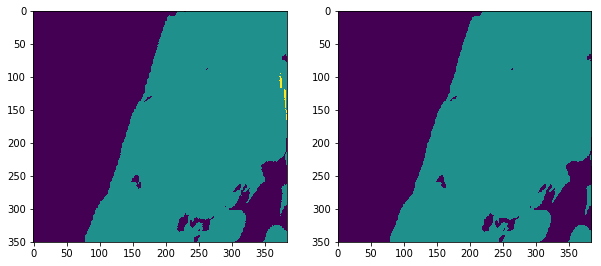

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 70, Metal: 0, Groups total: 1.0


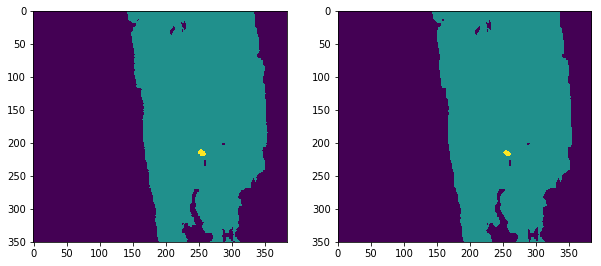

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 170, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 83, Metal: 0, Groups total: 2.0


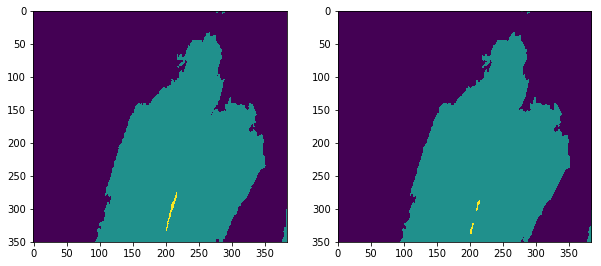

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 1.0


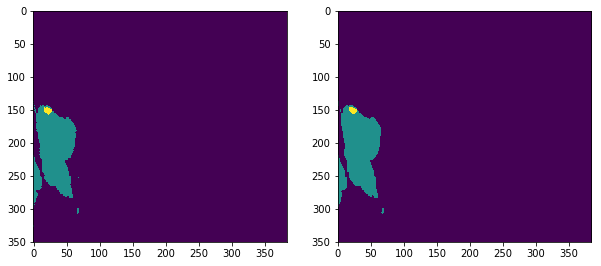

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 57, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 1.0


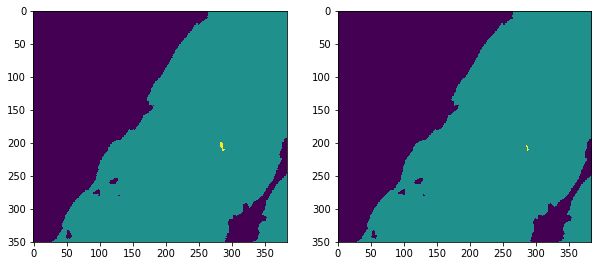

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 264, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 264, Metal: 0, Groups total: 4.0


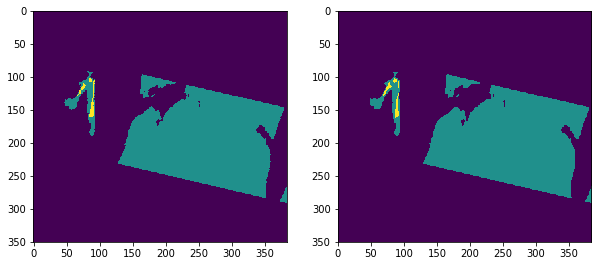

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 97, Metal: 0, Groups total: 3.0


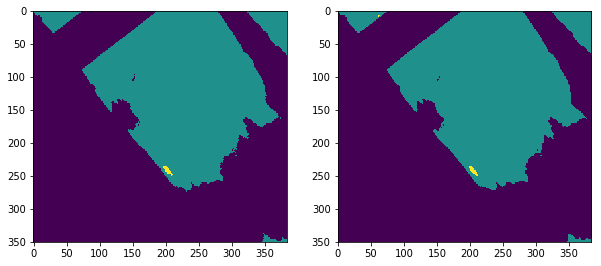

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 87, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 4, Metal: 0, Groups total: 1.0


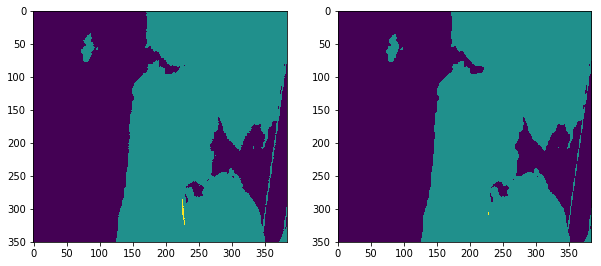

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 47, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 43, Metal: 0, Groups total: 1.0


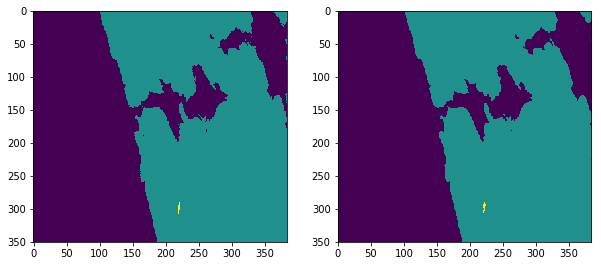

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 305, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 257, Metal: 0, Groups total: 2.0


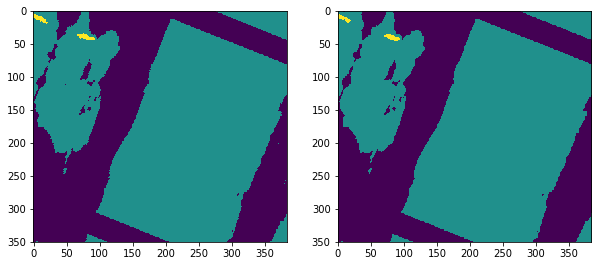

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1808, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 976, Metal: 0, Groups total: 2.0


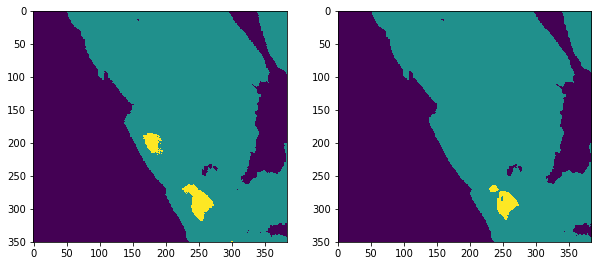

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 186, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 193, Metal: 0, Groups total: 2.0


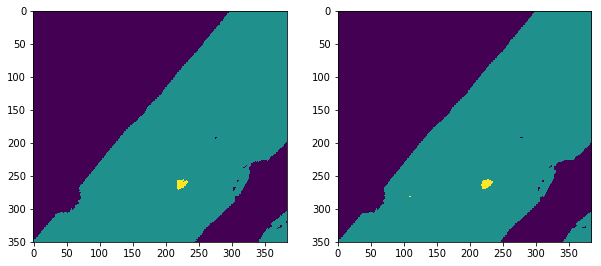

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 227, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 238, Metal: 0, Groups total: 1.0


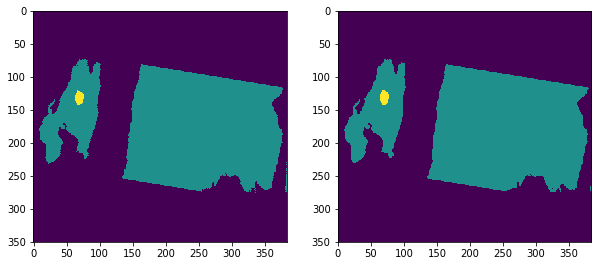

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 5696, Metal: 0, Groups total: 18.0
Prediction   -> Bone: 2544, Metal: 0, Groups total: 20.0


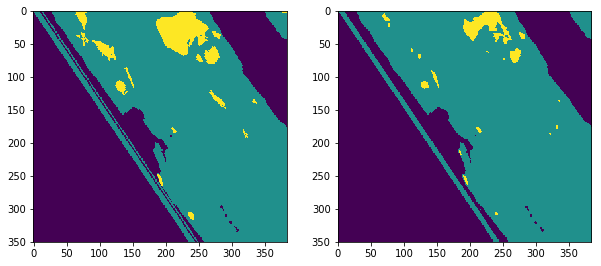

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 1.0


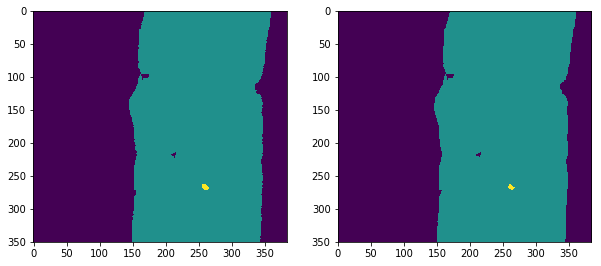

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 201, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 87, Metal: 0, Groups total: 5.0


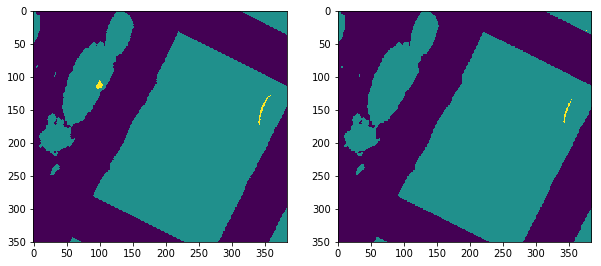

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 133, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 109, Metal: 0, Groups total: 1.0


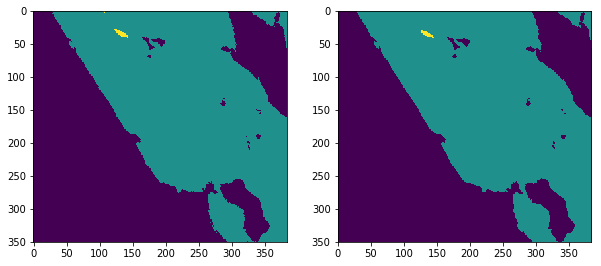

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 2.0


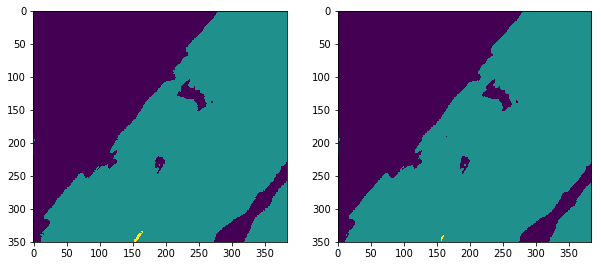

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1219, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1137, Metal: 0, Groups total: 3.0


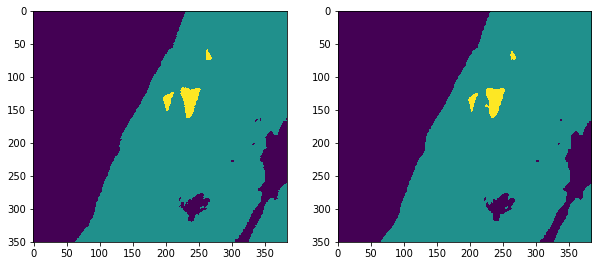

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 2111, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1178, Metal: 0, Groups total: 3.0


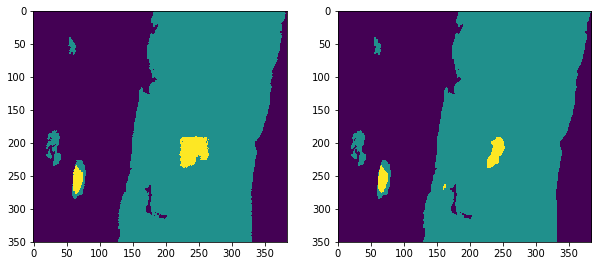

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 13, Metal: 0, Groups total: 1.0


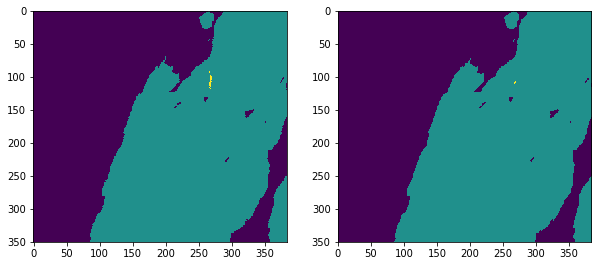

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 209, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 199, Metal: 0, Groups total: 3.0


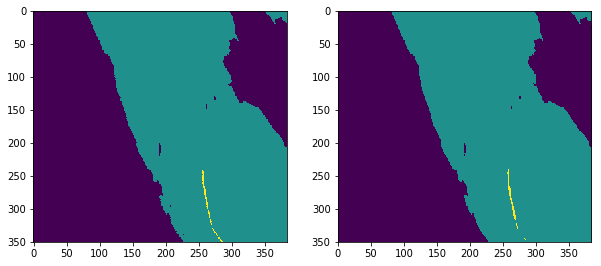

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 683, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 655, Metal: 0, Groups total: 4.0


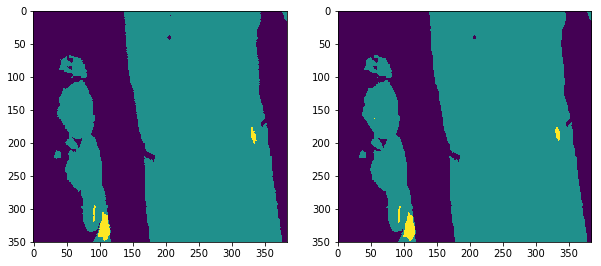

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 448, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 441, Metal: 0, Groups total: 1.0


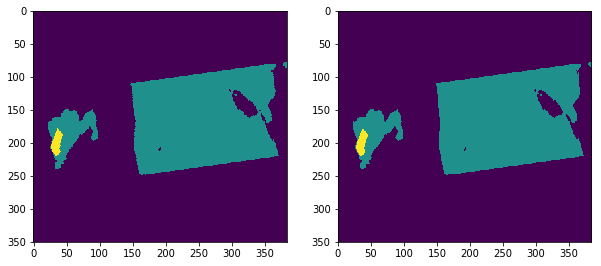

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 1.0


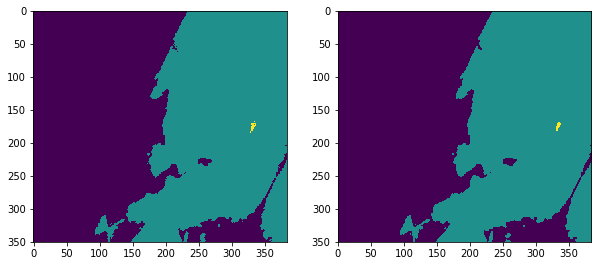

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 145, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 127, Metal: 0, Groups total: 1.0


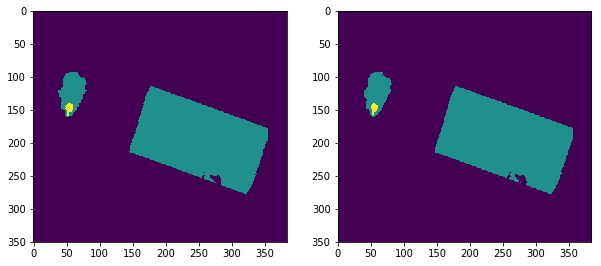

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 65, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 2.0


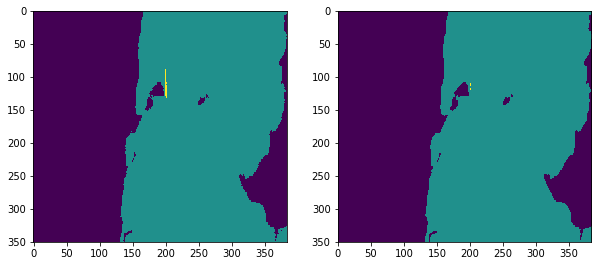

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 153, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 35, Metal: 0, Groups total: 1.0


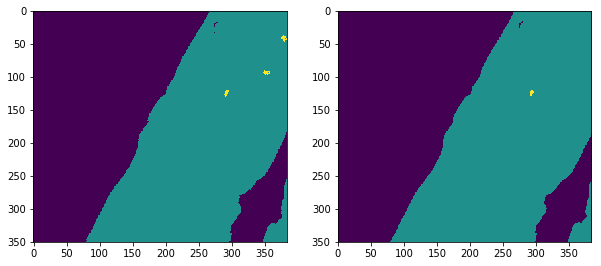

There is just Meat / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


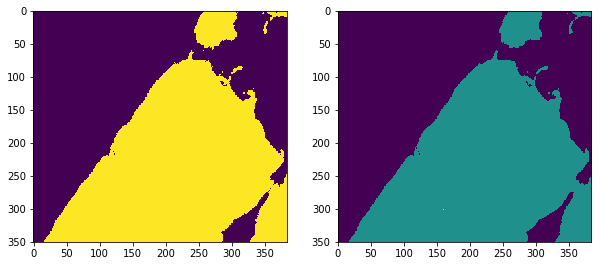

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 2.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 2.0


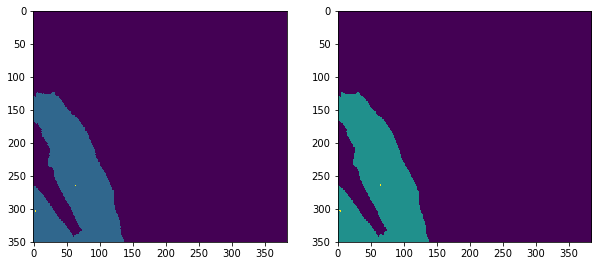

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 139, Metal: 0, Groups total: 5.0


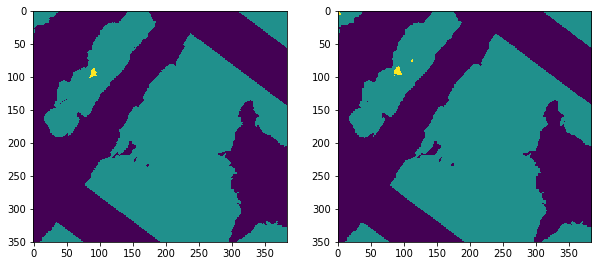

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 67, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 7.0


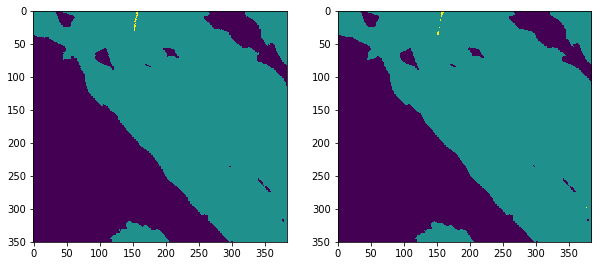

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 155, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 112, Metal: 0, Groups total: 1.0


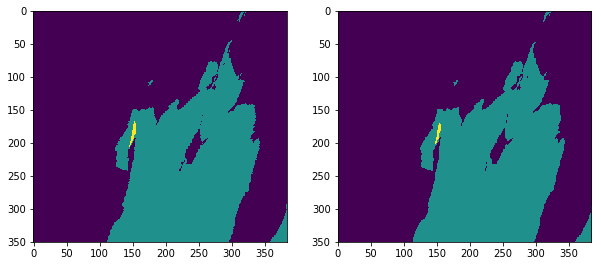

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 416, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 247, Metal: 0, Groups total: 2.0


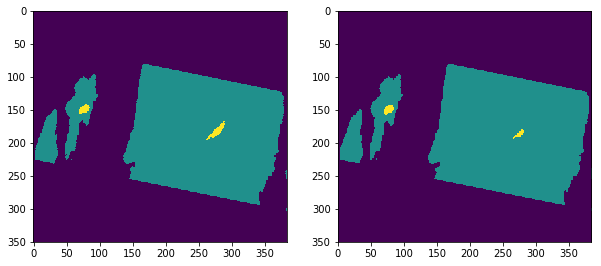

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 196, Metal: 0, Groups total: 1.0


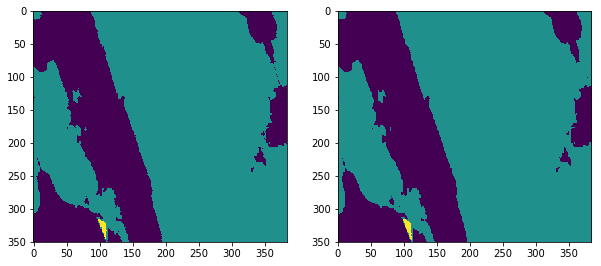

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 156, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 83, Metal: 0, Groups total: 2.0


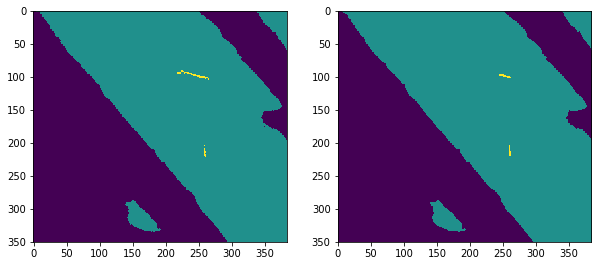

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 2.0


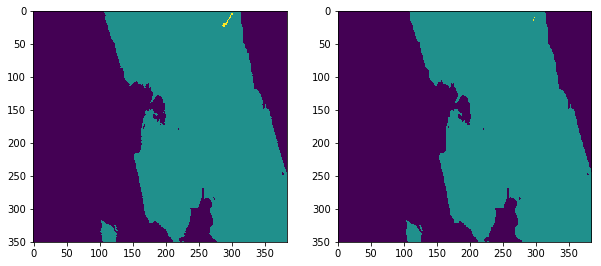

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 2.0


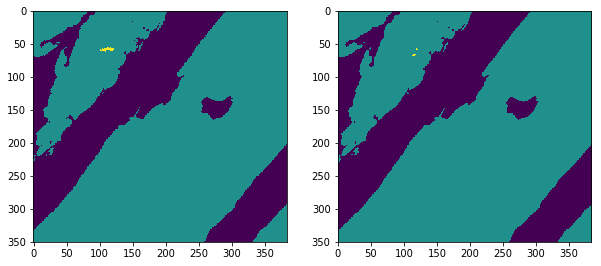

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 38, Metal: 0, Groups total: 3.0


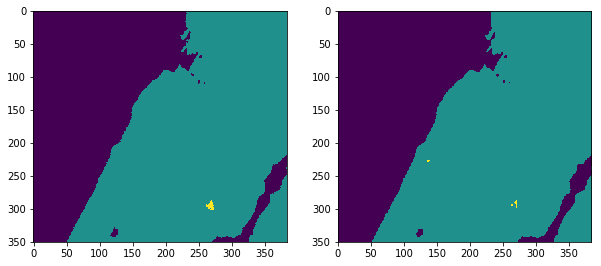

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 74, Metal: 0, Groups total: 2.0


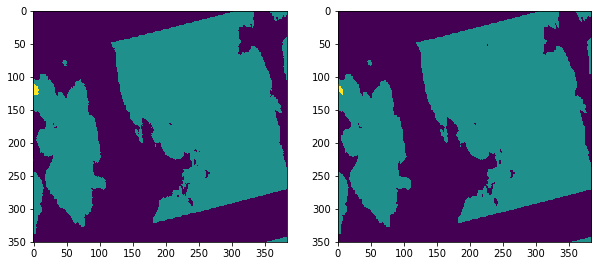

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 66, Metal: 0, Groups total: 6.0


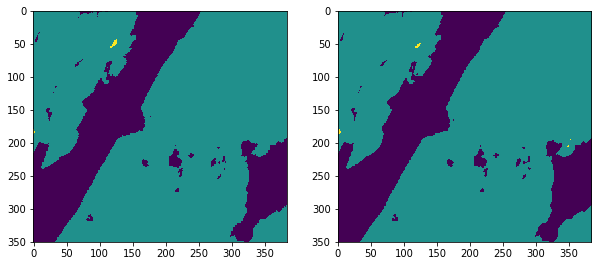

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 108, Metal: 0, Groups total: 2.0


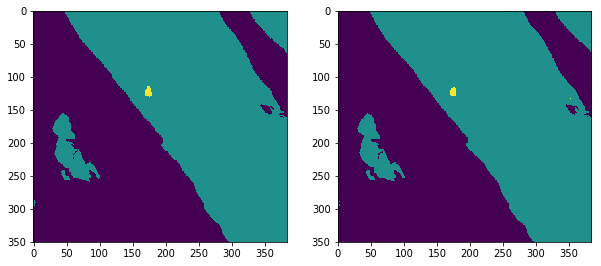

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 54, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 2.0


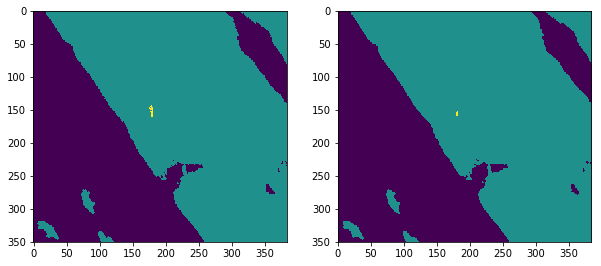

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 186, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 219, Metal: 0, Groups total: 2.0


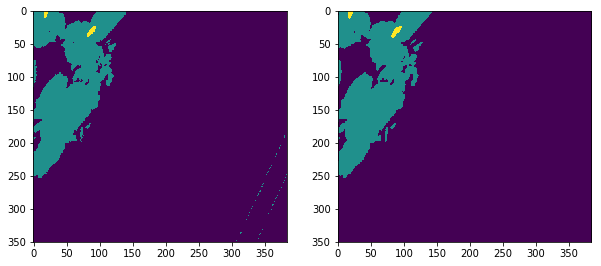

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 584, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 471, Metal: 0, Groups total: 3.0


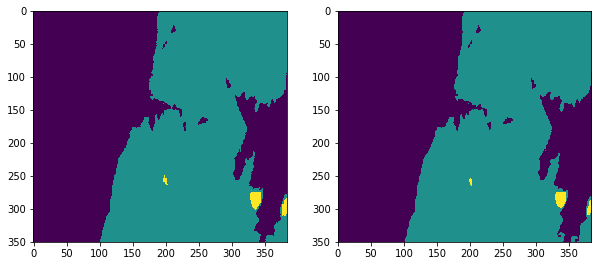

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 38, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


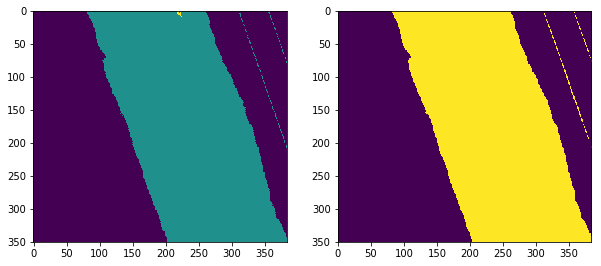

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 29, Metal: 0, Groups total: 2.0


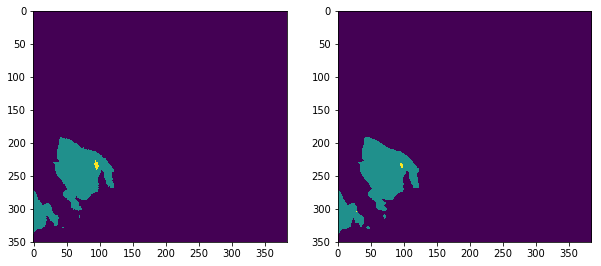

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 256, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 242, Metal: 0, Groups total: 1.0


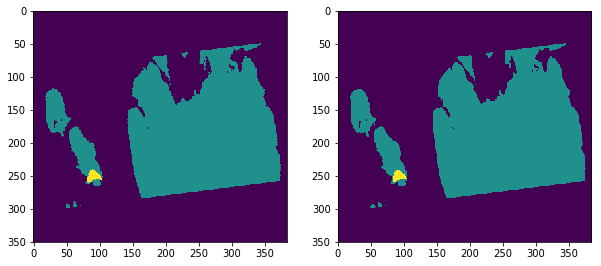

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 78, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 34, Metal: 0, Groups total: 3.0


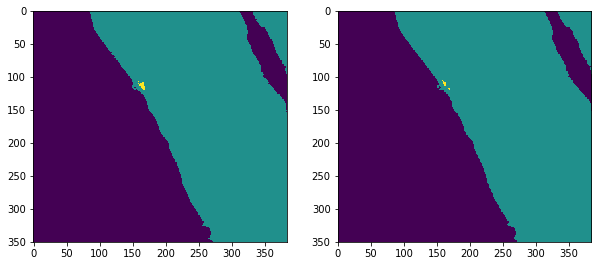

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 208, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 189, Metal: 0, Groups total: 3.0


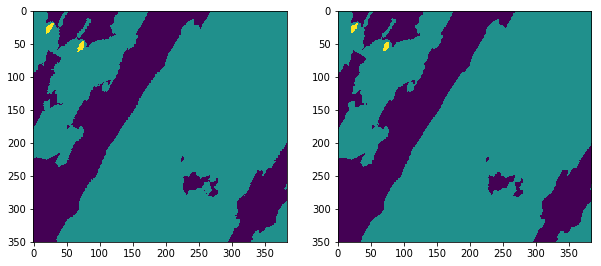

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 1.0


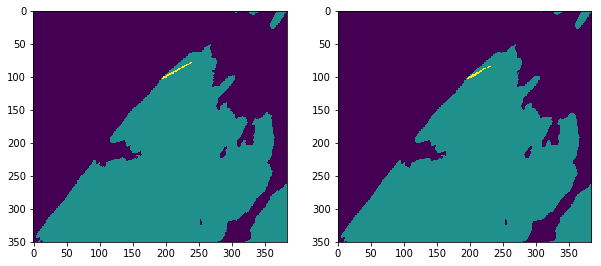

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 67, Metal: 0, Groups total: 1.0


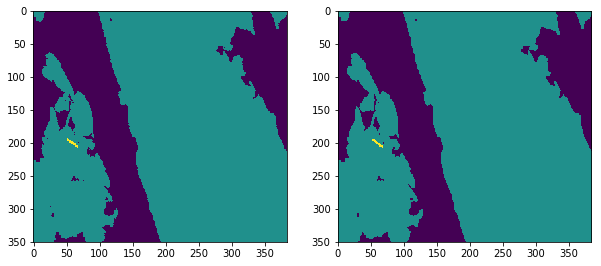

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 74, Metal: 0, Groups total: 1.0


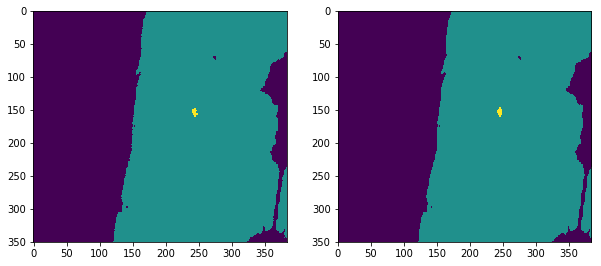

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 133, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 132, Metal: 0, Groups total: 1.0


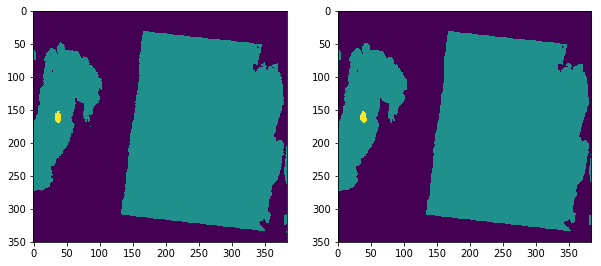

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


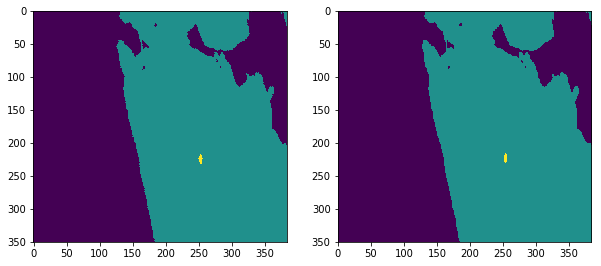

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 67, Metal: 0, Groups total: 1.0


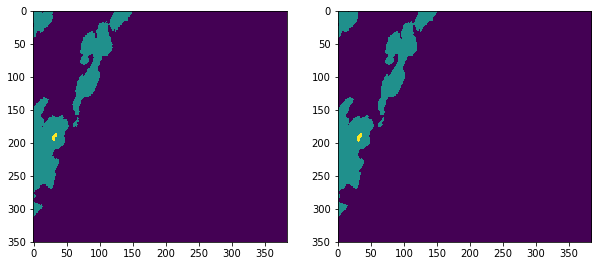

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 746, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 728, Metal: 0, Groups total: 1.0


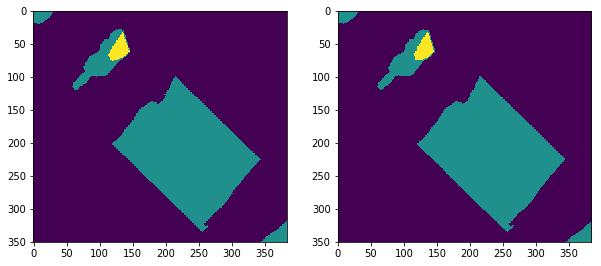

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 2080, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1437, Metal: 0, Groups total: 6.0


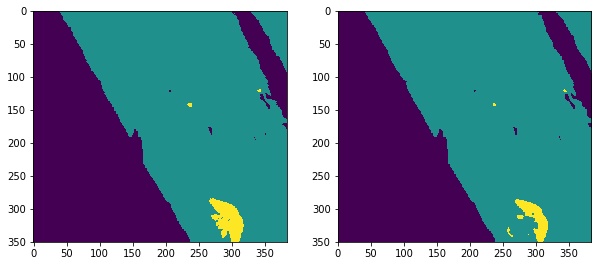

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1262, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 845, Metal: 0, Groups total: 4.0


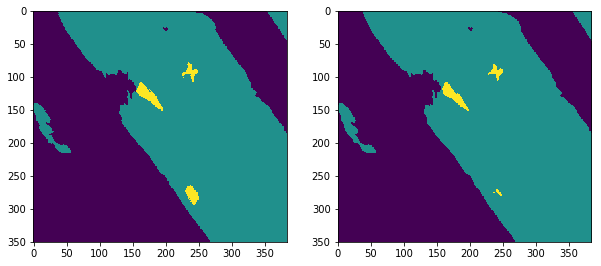

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 2.0


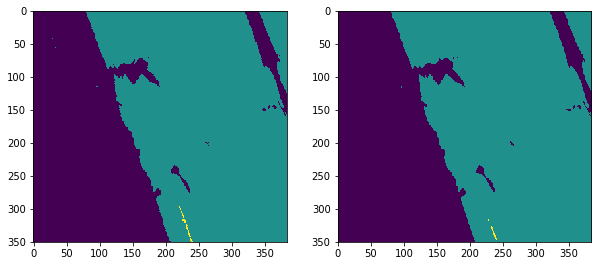

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 21, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


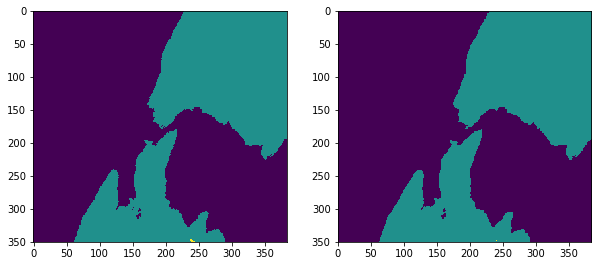

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 206, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


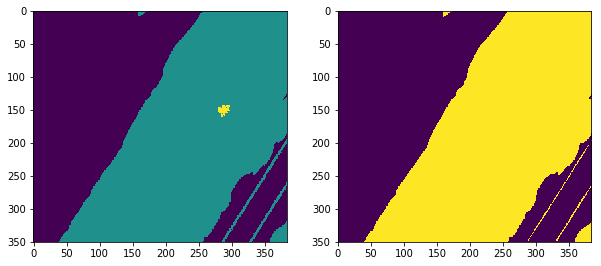

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


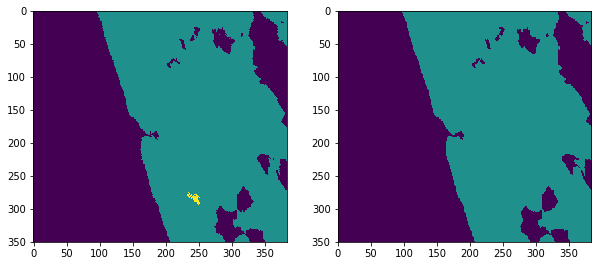

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 143, Metal: 0, Groups total: 1.0


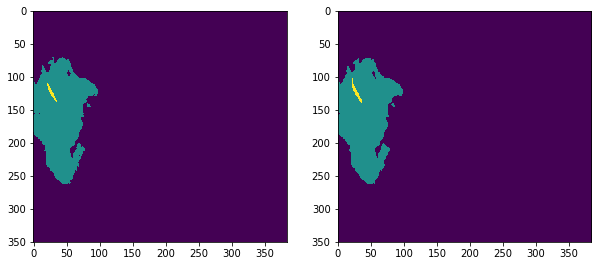

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 10, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


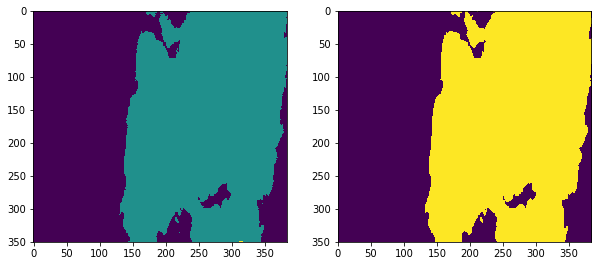

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 188, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 77, Metal: 0, Groups total: 3.0


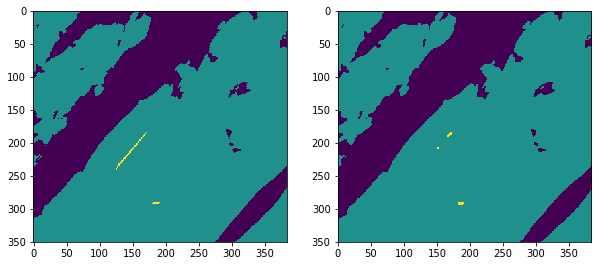

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1253, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 952, Metal: 0, Groups total: 3.0


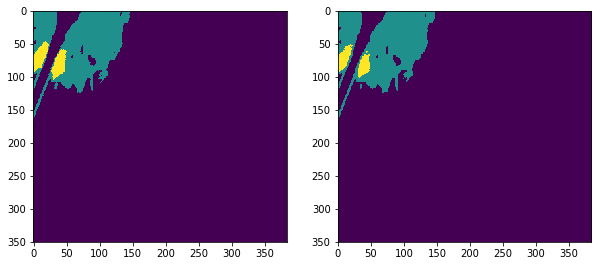

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 155, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 61, Metal: 0, Groups total: 3.0


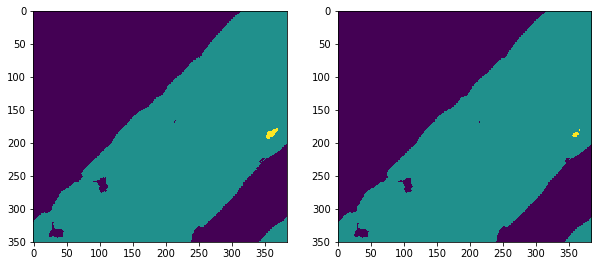

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 814, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 789, Metal: 0, Groups total: 2.0


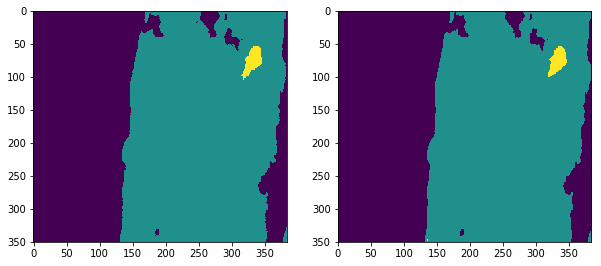

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 2.0


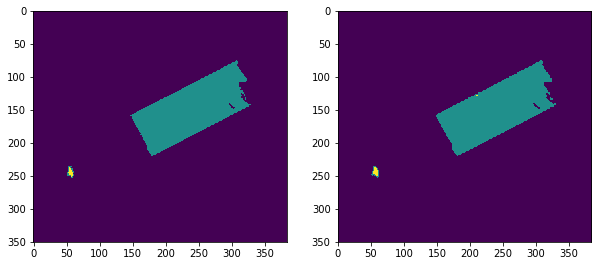

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 160, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 162, Metal: 0, Groups total: 4.0


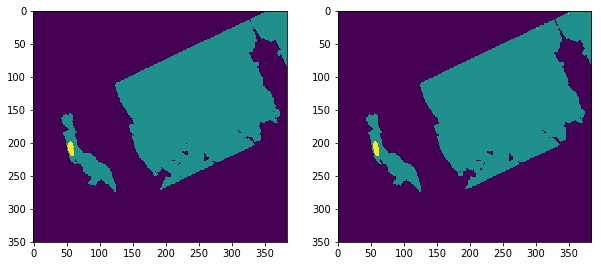

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 363, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 133, Metal: 0, Groups total: 6.0


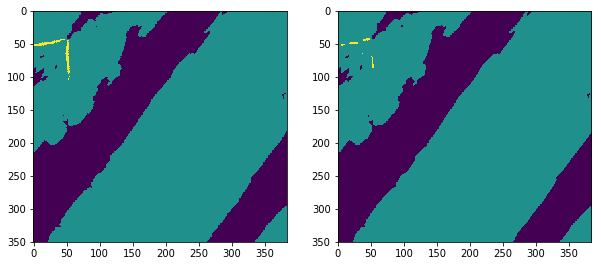

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 225, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 181, Metal: 0, Groups total: 2.0


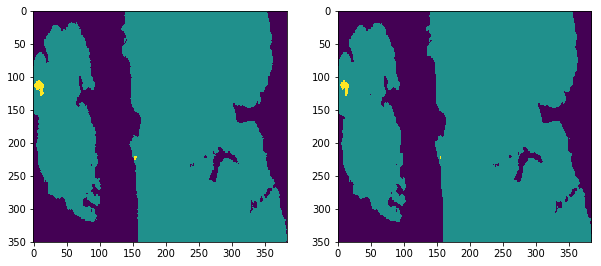

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 1.0


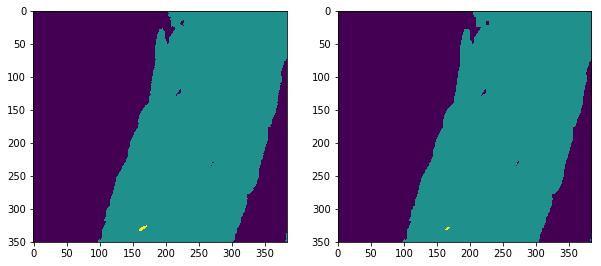

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 186, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 172, Metal: 0, Groups total: 1.0


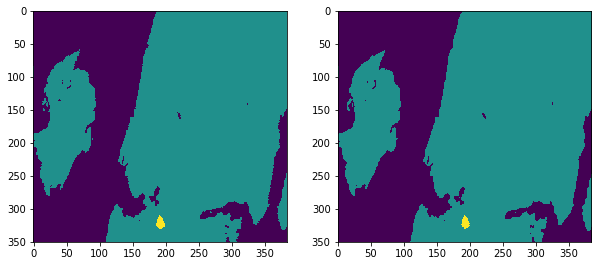

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


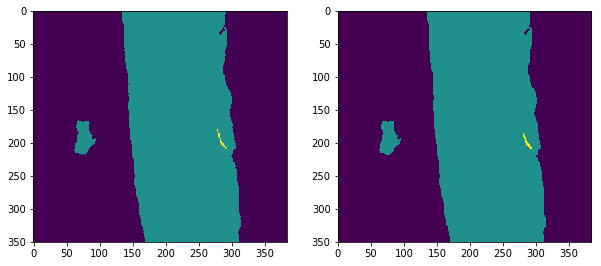

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 776, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 713, Metal: 0, Groups total: 2.0


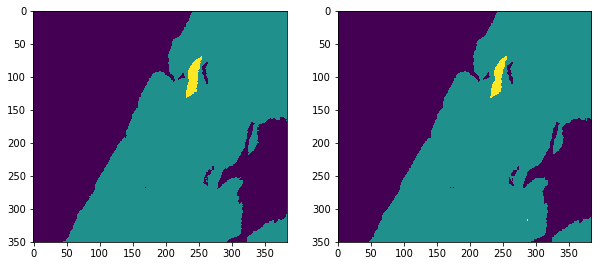

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 99, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 2.0


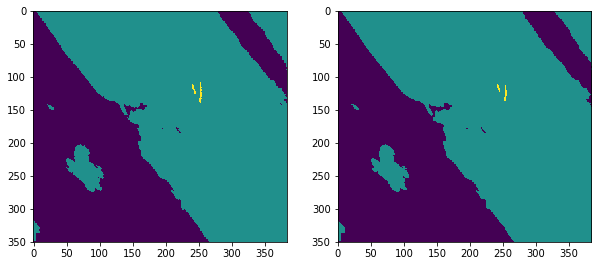

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 86, Metal: 0, Groups total: 1.0


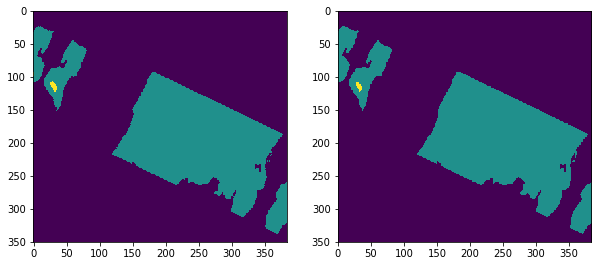

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 283, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 235, Metal: 0, Groups total: 2.0


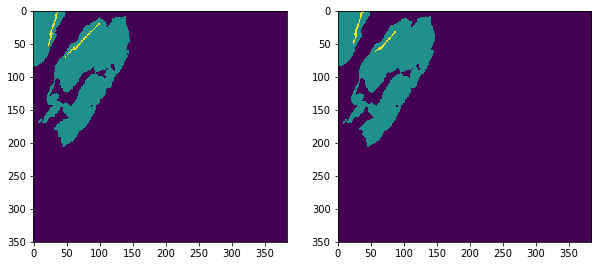

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 23, Metal: 0, Groups total: 1.0


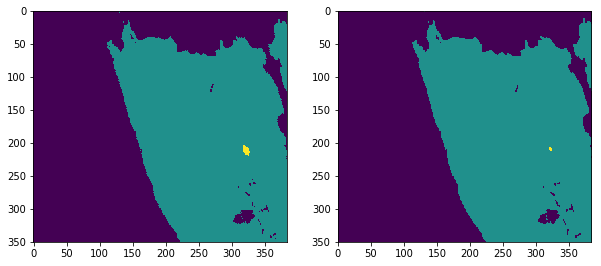

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 145, Metal: 0, Groups total: 1.0


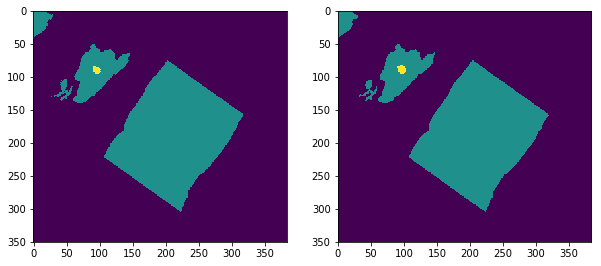

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 229, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 233, Metal: 0, Groups total: 1.0


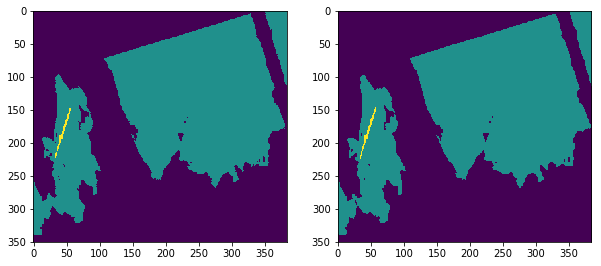

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 41, Metal: 0, Groups total: 1.0


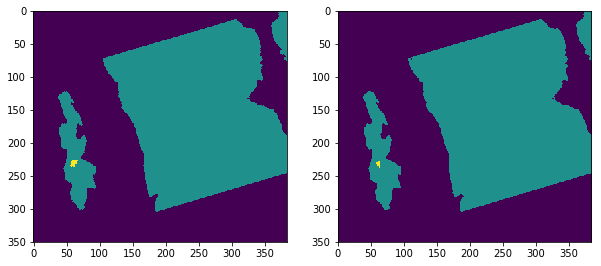

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 155, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


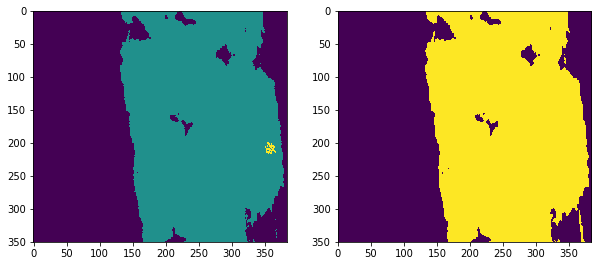

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 1.0


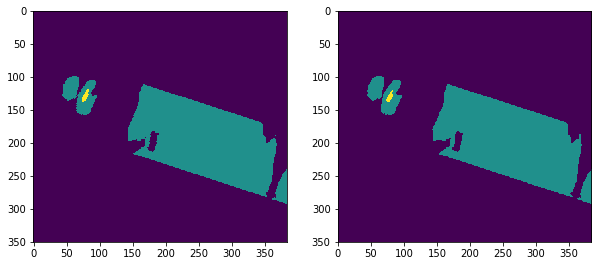

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


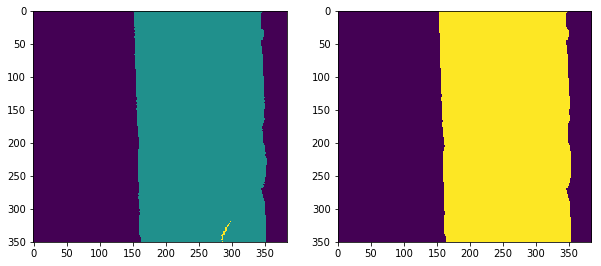

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 52, Metal: 0, Groups total: 2.0


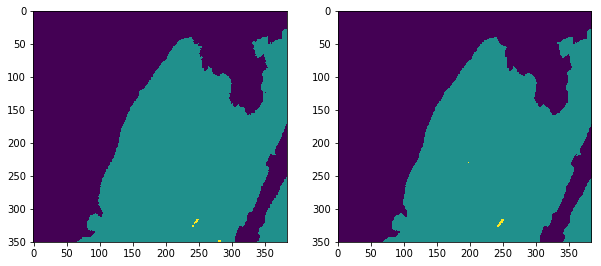

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 100, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 121, Metal: 0, Groups total: 2.0


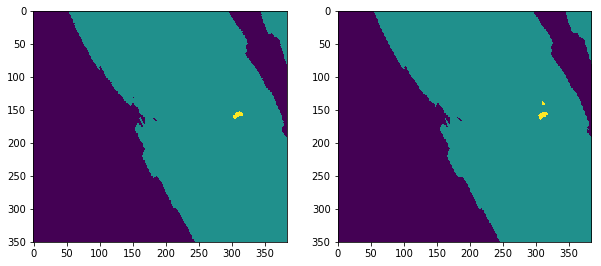

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 64, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 1.0


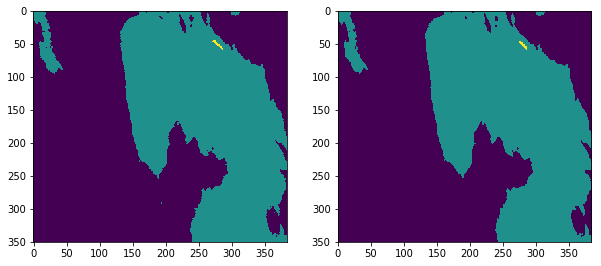

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 175, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 189, Metal: 0, Groups total: 2.0


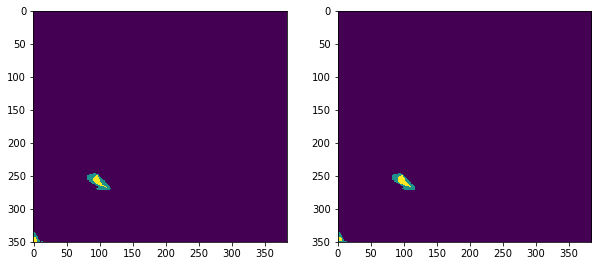

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 2.0


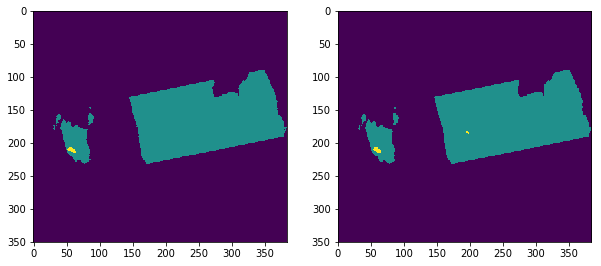

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 34, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 37, Metal: 0, Groups total: 1.0


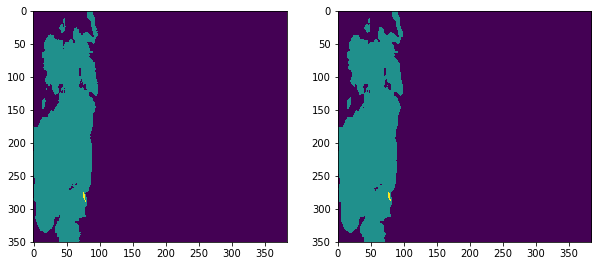

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 170, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 136, Metal: 0, Groups total: 1.0


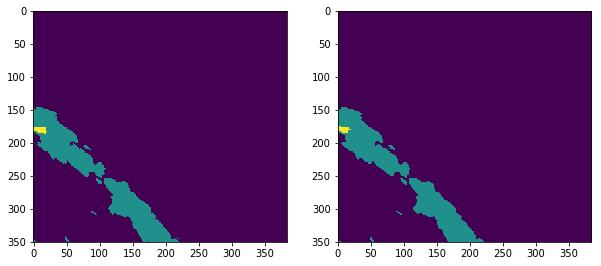

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1118, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1137, Metal: 0, Groups total: 2.0


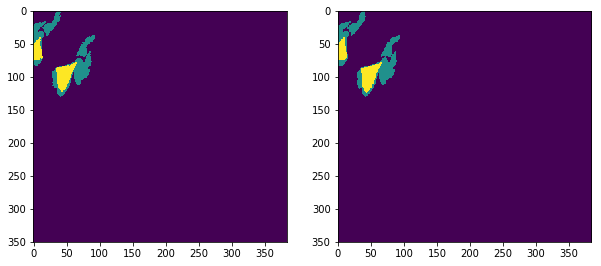

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 93, Metal: 0, Groups total: 1.0


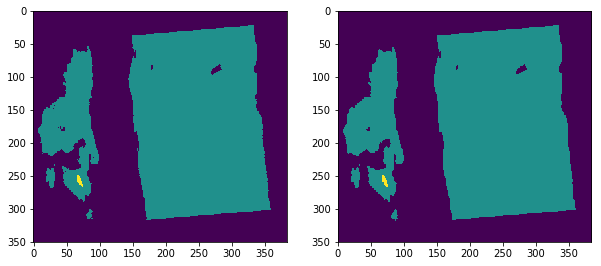

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 217, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 2.0


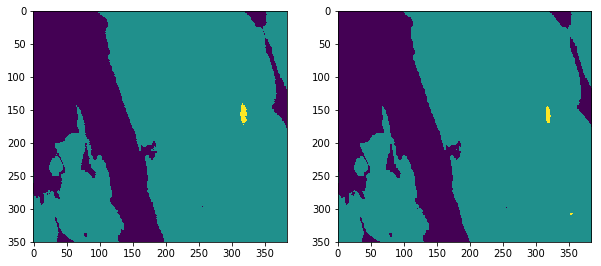

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 226, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 31, Metal: 0, Groups total: 1.0


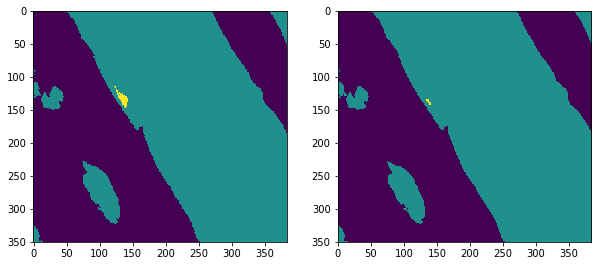

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 127, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


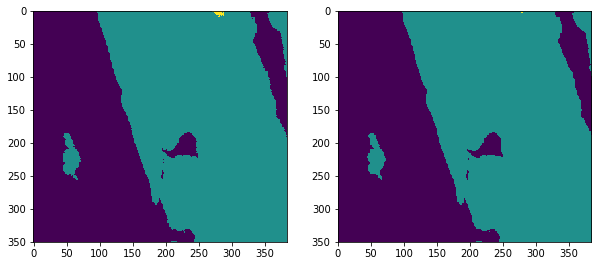

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 307, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 277, Metal: 0, Groups total: 1.0


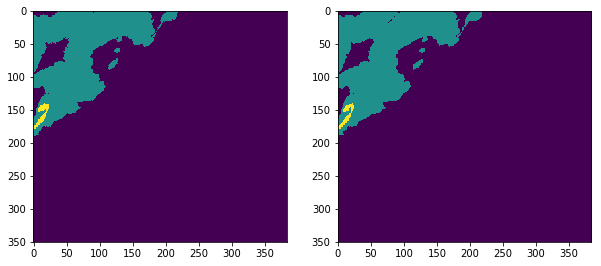

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 8273, Metal: 0, Groups total: 12.0
Prediction   -> Bone: 7407, Metal: 0, Groups total: 15.0


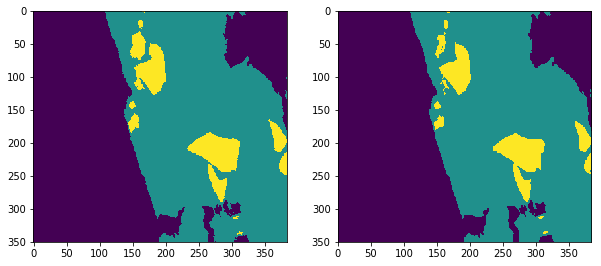

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 72, Metal: 0, Groups total: 4.0


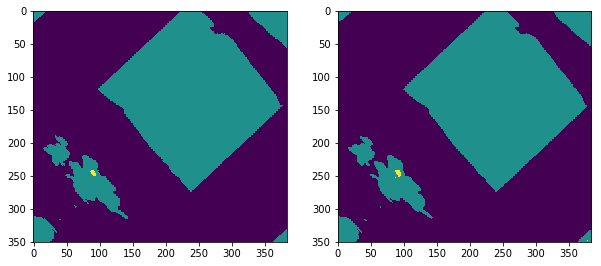

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 179, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 173, Metal: 0, Groups total: 1.0


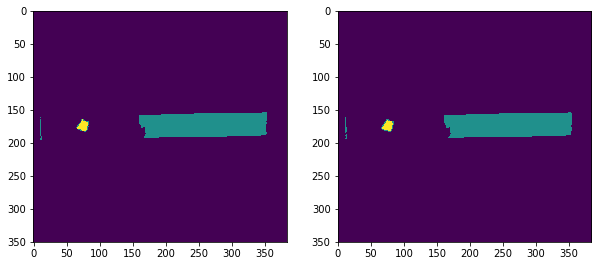

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 79, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


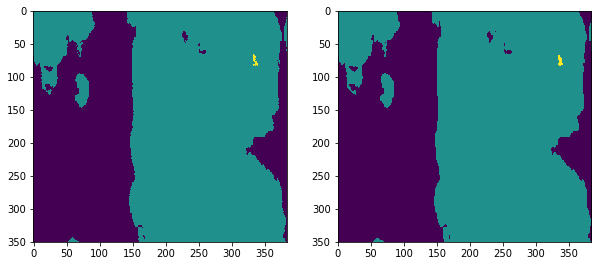

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1158, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 480, Metal: 0, Groups total: 6.0


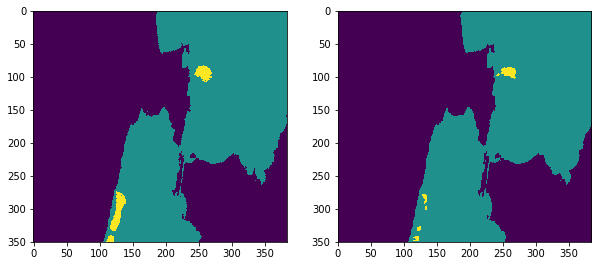

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 316, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 249, Metal: 0, Groups total: 3.0


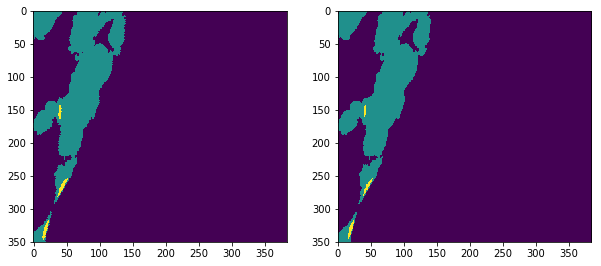

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 26, Metal: 0, Groups total: 2.0


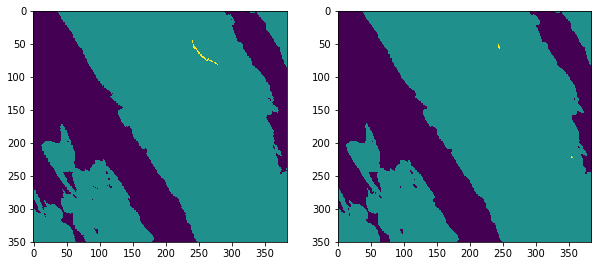

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 59, Metal: 0, Groups total: 1.0


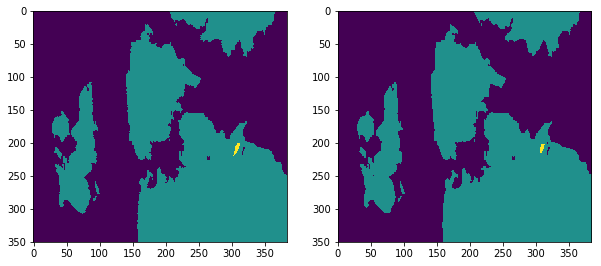

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 251, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 210, Metal: 0, Groups total: 4.0


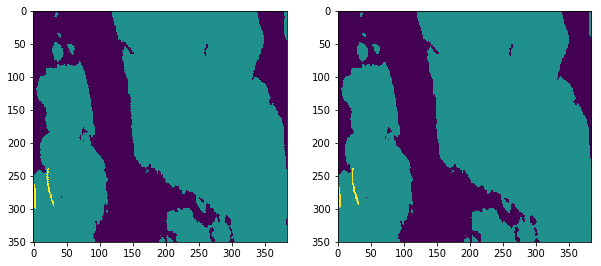

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 209, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 152, Metal: 0, Groups total: 1.0


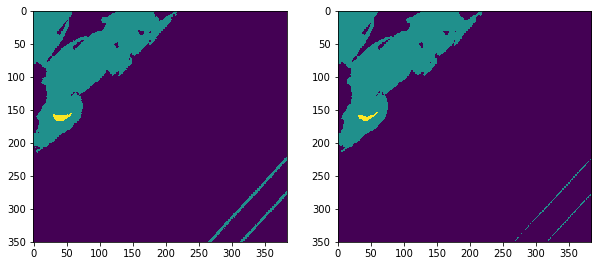

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 918, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 941, Metal: 0, Groups total: 3.0


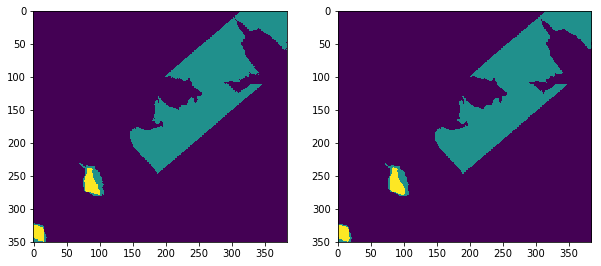

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 278, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 263, Metal: 0, Groups total: 1.0


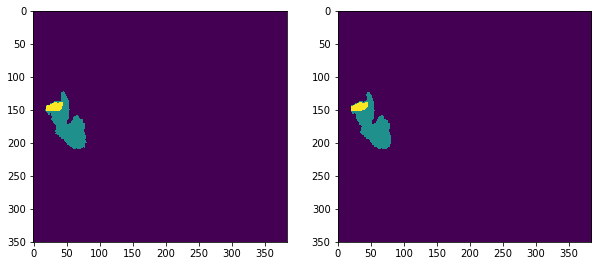

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 561, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 516, Metal: 0, Groups total: 1.0


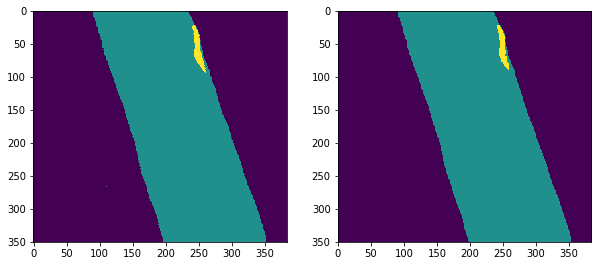

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 489, Metal: 0, Groups total: 6.0
Prediction   -> Bone: 271, Metal: 0, Groups total: 5.0


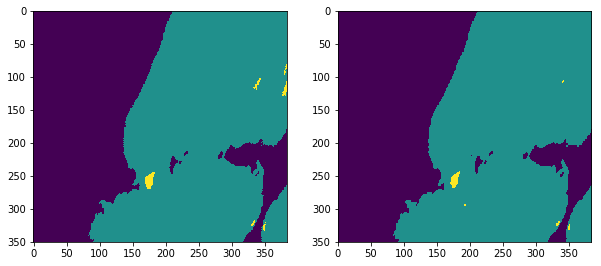

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 1.0


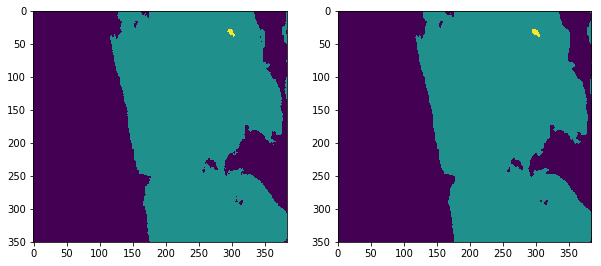

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 295, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 294, Metal: 0, Groups total: 2.0


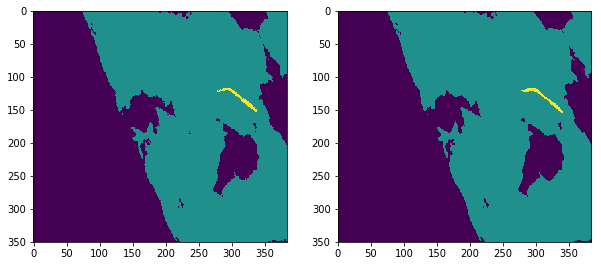

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 588, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 155, Metal: 0, Groups total: 4.0


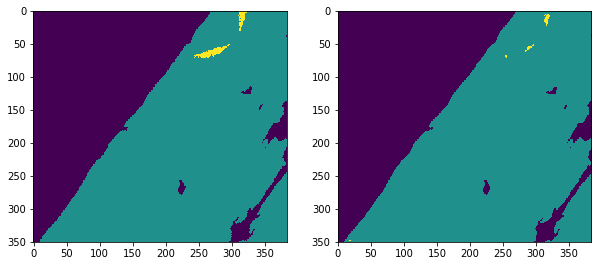

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 49, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 1.0


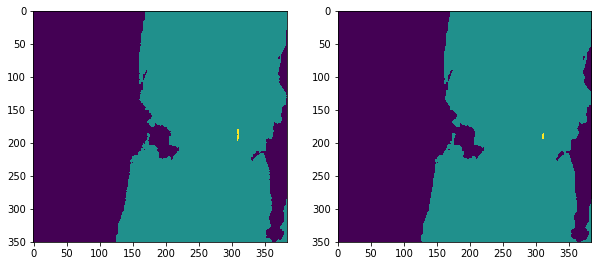

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 124, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 111, Metal: 0, Groups total: 1.0


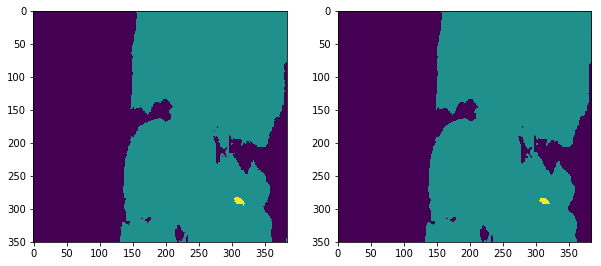

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 123, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


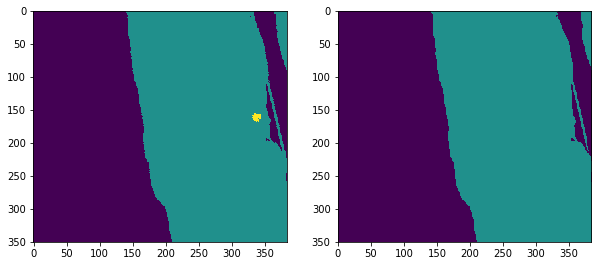

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 104, Metal: 0, Groups total: 1.0


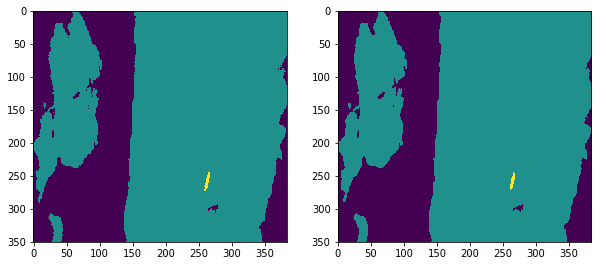

There is just Meat / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 4, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 140, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 4.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


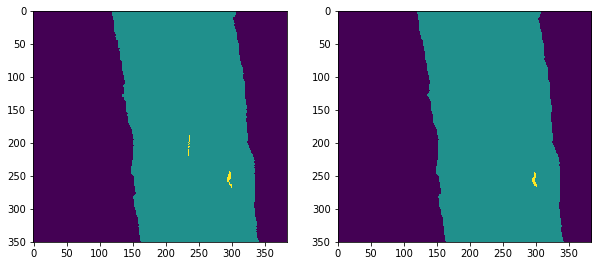

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 65, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


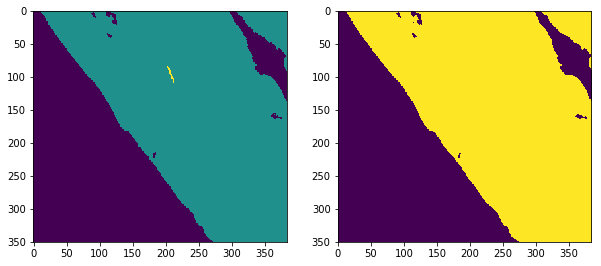

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 412, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 219, Metal: 0, Groups total: 3.0


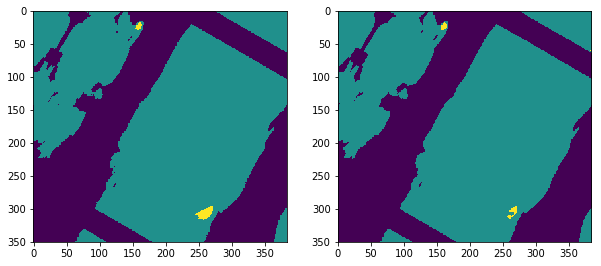

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 319, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 261, Metal: 0, Groups total: 1.0


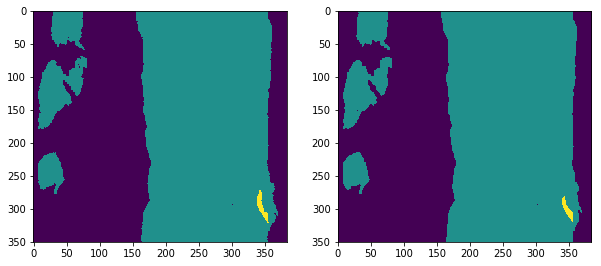

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 155, Metal: 0, Groups total: 3.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 145, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 139, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 337, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 151, Metal: 0, Groups total: 5.0


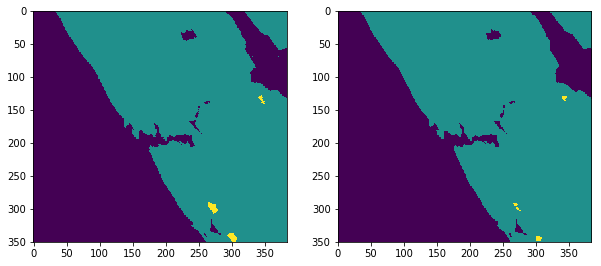

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 52, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 106, Metal: 0, Groups total: 2.0


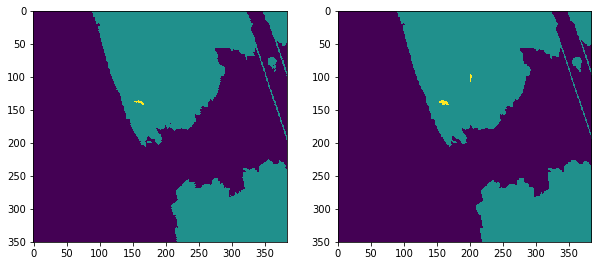

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 187, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 176, Metal: 0, Groups total: 1.0


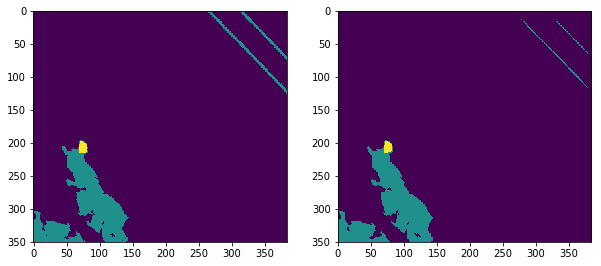

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 46, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 4.0


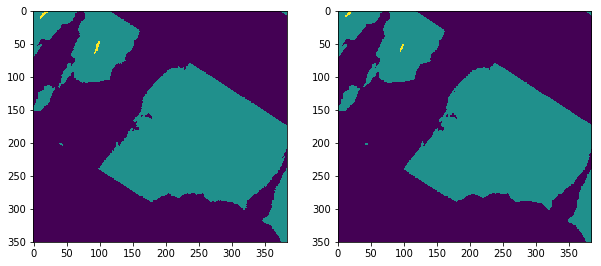

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 123, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 1.0


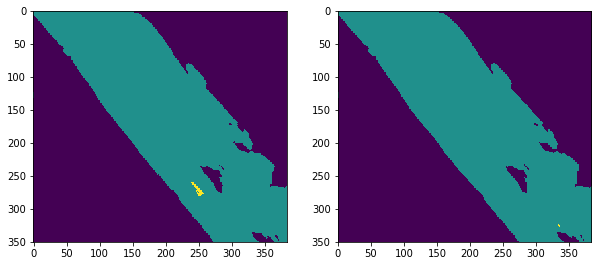

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1463, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 596, Metal: 0, Groups total: 6.0


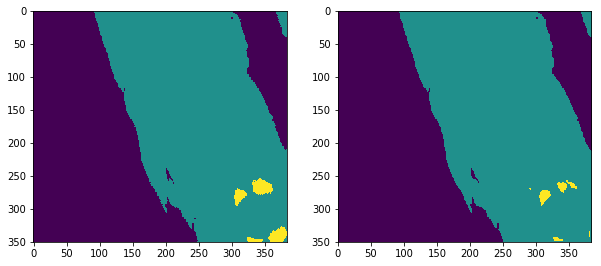

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 15, Metal: 0, Groups total: 1.0


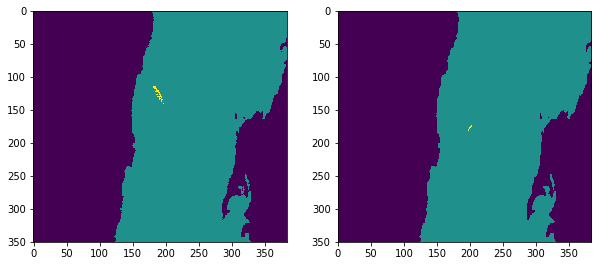

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


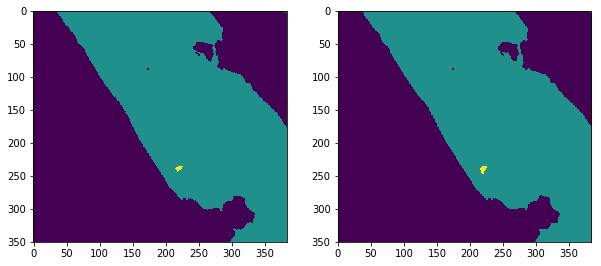

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 2.0


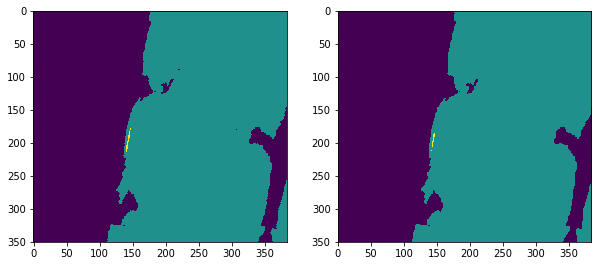

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 7, Metal: 0, Groups total: 1.0


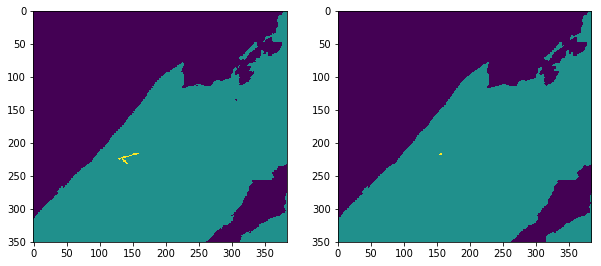

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 3.0


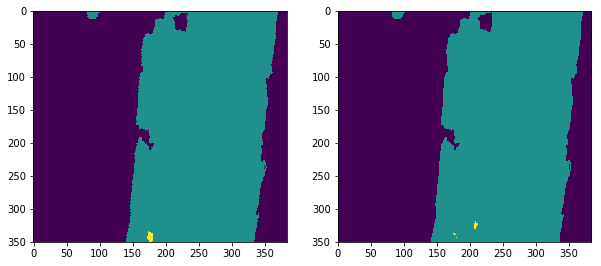

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


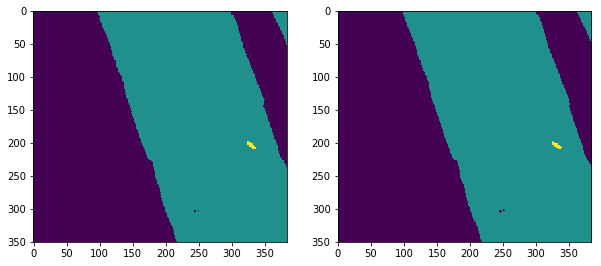

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 184, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 3.0


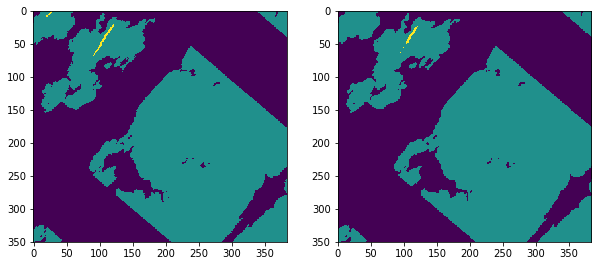

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 72, Metal: 0, Groups total: 1.0


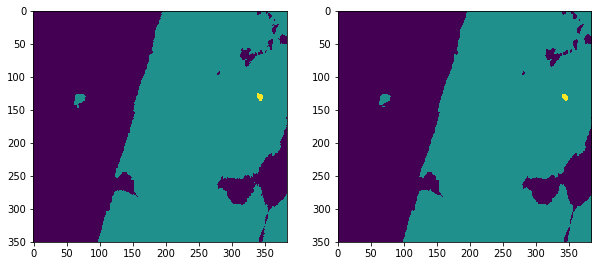

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 170, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 161, Metal: 0, Groups total: 1.0


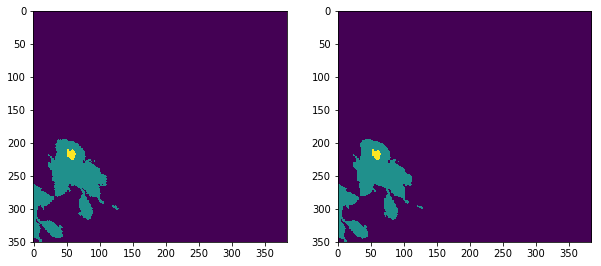

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 310, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 308, Metal: 0, Groups total: 3.0


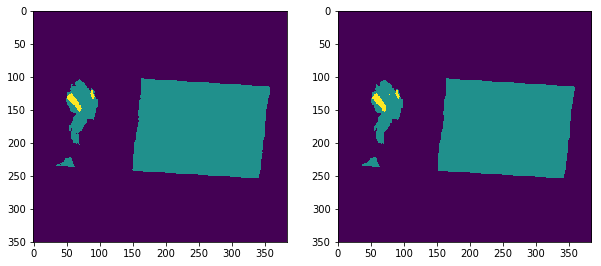

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 560, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 2.0


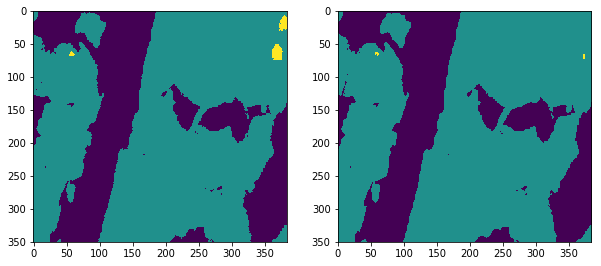

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 9, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 3.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 312, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 291, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 254, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 214, Metal: 0, Groups total: 1.0


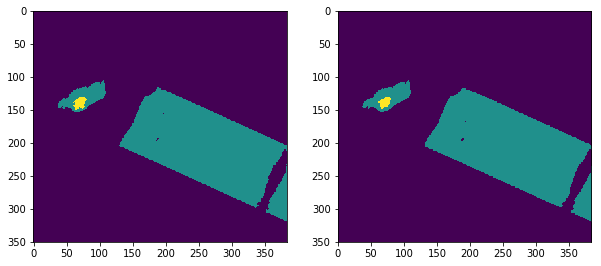

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 384, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 294, Metal: 0, Groups total: 2.0


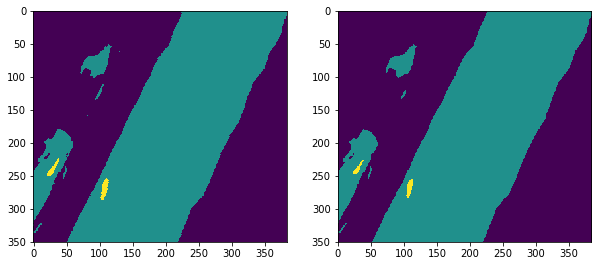

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 67, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 327, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 294, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 303, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 259, Metal: 0, Groups total: 2.0


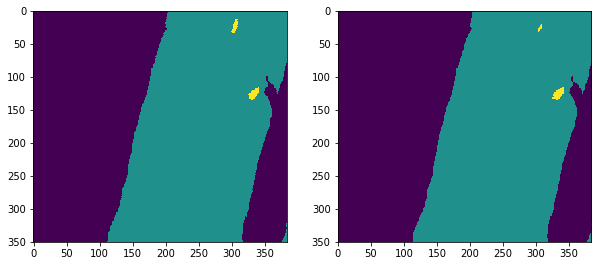

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 159, Metal: 0, Groups total: 1.0


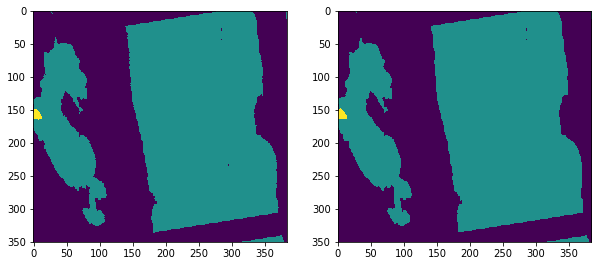

There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1068, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 168, Metal: 0, Groups total: 2.0


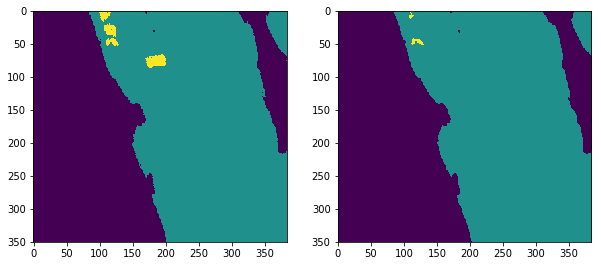

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 75, Metal: 0, Groups total: 1.0


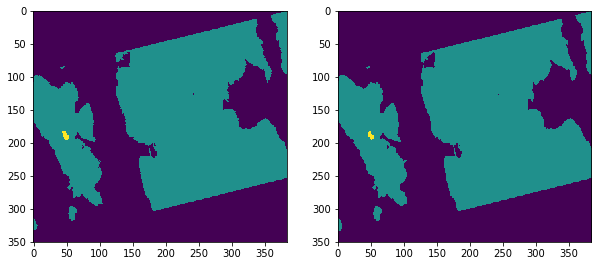

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 143, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 131, Metal: 0, Groups total: 1.0


There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


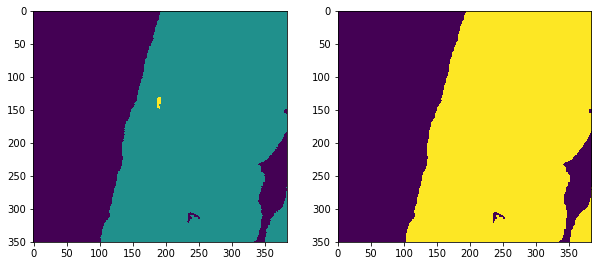

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 194, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 196, Metal: 0, Groups total: 3.0


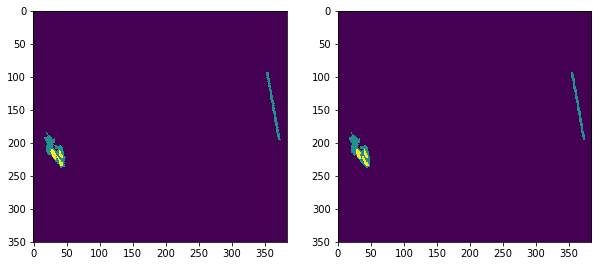

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 342, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 306, Metal: 0, Groups total: 1.0


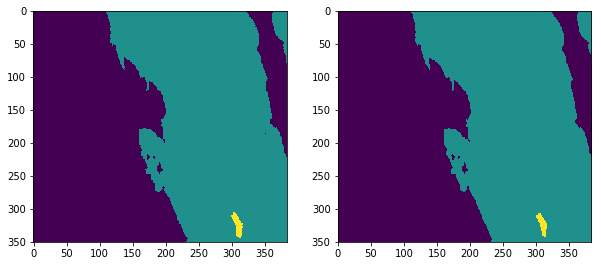

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 314, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 403, Metal: 0, Groups total: 3.0


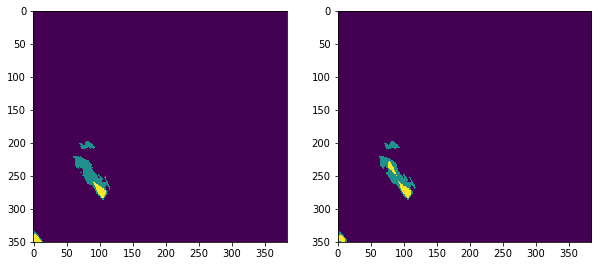

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 538, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 293, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 721, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 659, Metal: 0, Groups total: 2.0


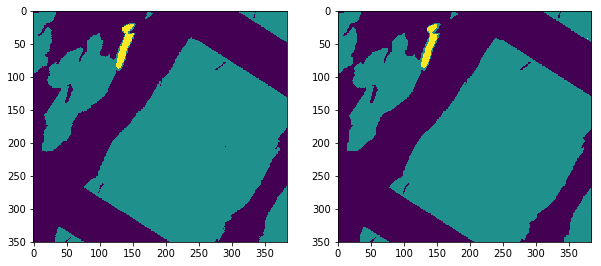

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 500, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 473, Metal: 0, Groups total: 2.0


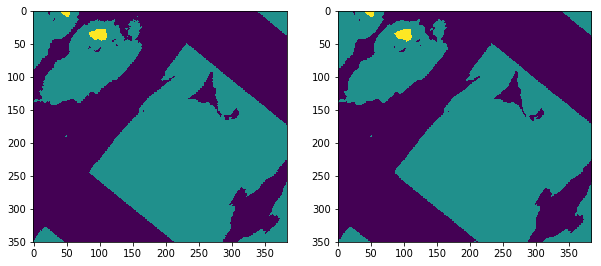

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 10264, Metal: 0, Groups total: 13.0
Prediction   -> Bone: 4645, Metal: 0, Groups total: 20.0


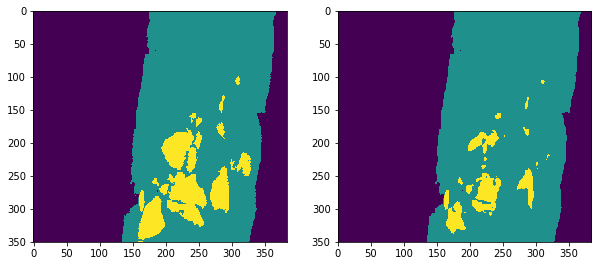

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 131, Metal: 0, Groups total: 3.0


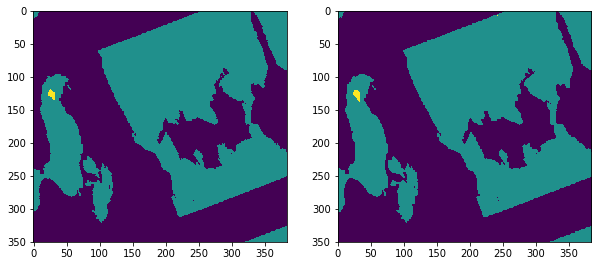

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 350, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 2.0


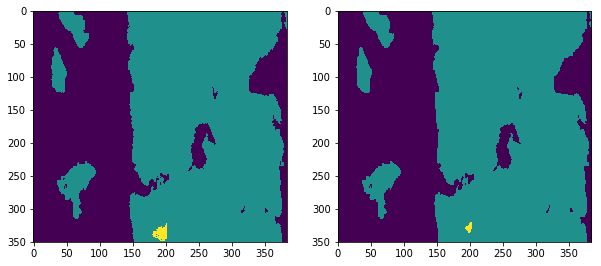

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 130, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


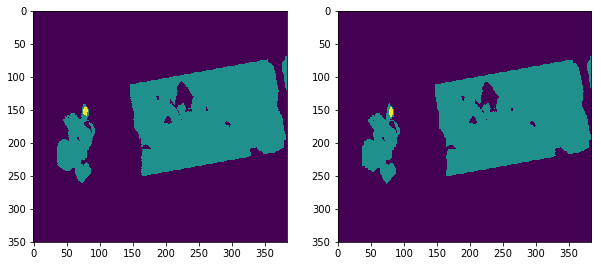

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 56, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 13.0


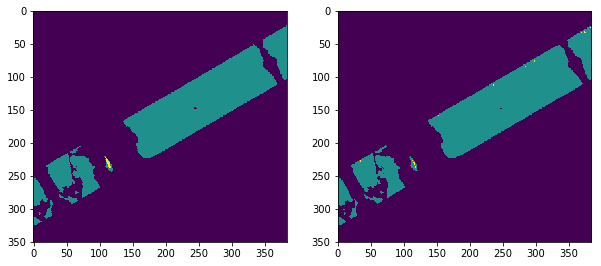

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 216, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 140, Metal: 0, Groups total: 2.0


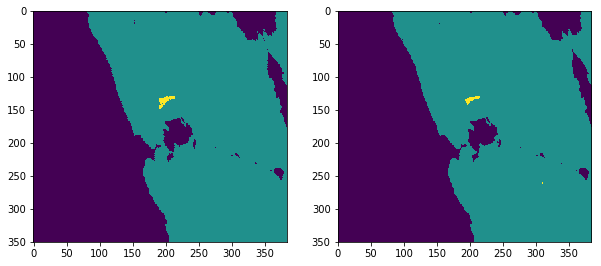

There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 150, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


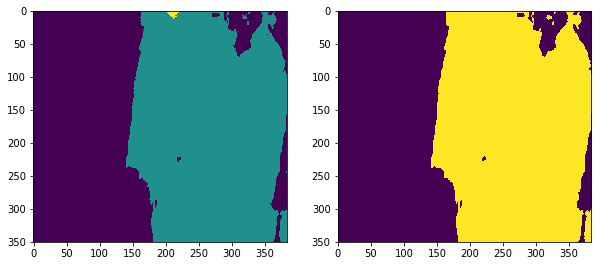

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 257, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 248, Metal: 0, Groups total: 1.0


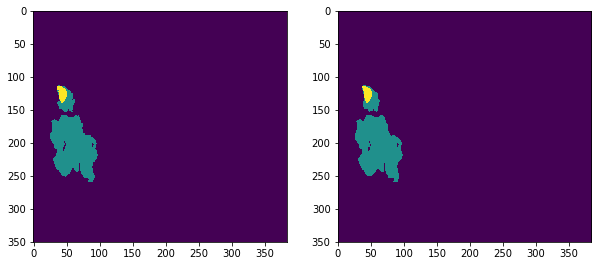

There is just Meat / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 1.0


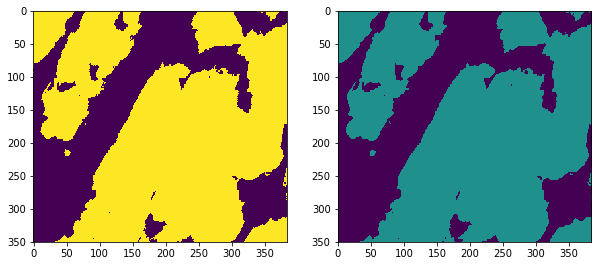

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 3.0


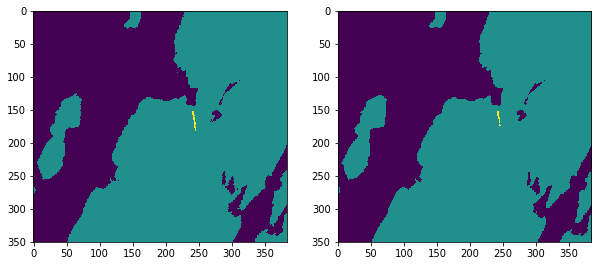

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 593, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 522, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 35, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 39, Metal: 0, Groups total: 1.0


There is just Meat / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 97, Metal: 0, Groups total: 1.0


There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 83, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 81, Metal: 0, Groups total: 1.0


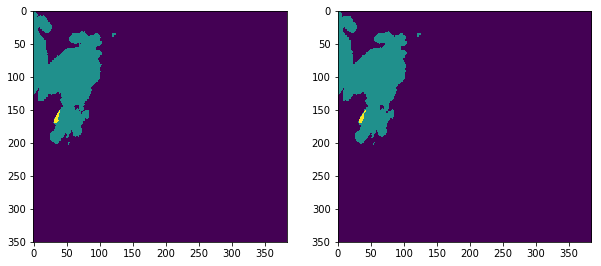

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 377, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 341, Metal: 0, Groups total: 1.0


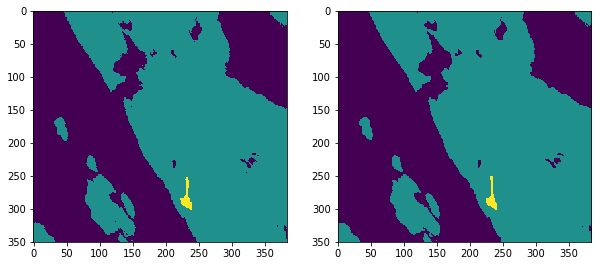

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 101, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 112, Metal: 0, Groups total: 1.0


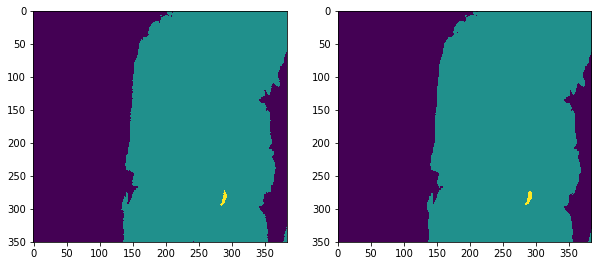

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 49, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 44, Metal: 0, Groups total: 1.0


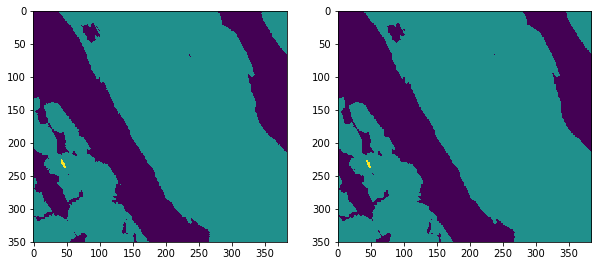

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 13, Metal: 0, Groups total: 1.0


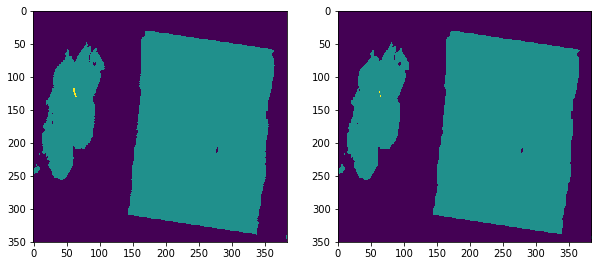

In [37]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(385): #learn.data.batch_size-1):
    prediction = preds.argmax(dim=1)[i]
    print(validation_files[i])
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3]), numb_contaminants(y[i])))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()
    

In [35]:
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
                             'MAGNA_54_-1CL_0.441927kg.tif']
for name in validation_metal:
#     print(path, name)
    name = path / ('images/' + name)
    print(name)
#     help(learn.predict)
#     ground_truth = open_image(name.replace('images', 'masks'))
    prediction = learn.predict(open_image(name))
    prediction = prediction[1]
#     print(ground_truth)
    print(np.unique(prediction))
    
#     print("There is {} / Found {}".format(getContanimentInfo(ground_truth), getContanimentInfo(prediction)))
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(1, 2, 1)
#     plt.imshow(ground_truth)
#     fig.add_subplot(1, 2, 2)
#     plt.imshow(prediction)
#     print("Pixel count")
#     print("Ground truth -> Bone: {}, Metal: {}".format(len(ground_truth[ground_truth == 2]), len(ground_truth[ground_truth == 3])))
#     print("Prediction   -> Bone: {}, Metal: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3])))
#     plt.show()
#     break

/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_56_-1CL_0.446517kg.tif
[0 1 2]
/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_61_83.7706CL_3.88116kg.tif
[0 1 2]
/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_54_-1CL_0.441927kg.tif
[0 1 2]
